In [1]:
#use wdtools_env_pip environment

import numpy as np
from math import log10, floor
from bisect import bisect_left
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#for machine learning
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model


# This notebook trains a machine learning method to reconstruct the correlation length in the simulation with thin H envelope contamination added (simulation=1)
- Use a deep learning approach with a convolutional neural network. CNNs are designed to automatically learn hierarchical features from raw data (usually images), so they are well suited to detect the peak/drop-off structure in the Moran's I x Z-Score curve that is useful in identifying the correlation length without me needing to do manual feature extraction. 
    - Use just the 1D Moran's I x Z-Score curve, don't include the distance array since the CNN will learn that scale from the labeled true correlation length
    - Don't cut the peak at small distances since the CNN should learn that feature doesn't necessarily drive the labeled true correlation length

# Import the simulation outputs

In [2]:
def get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,sample_type,nonzero_weight_cut=20,plot=True):
    #read back in measurements
    noise_label="".join(noise_effect_array)
    
    #sample_type='training','testing', or 'bootstrap'
    if sample_type=='training':
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/training_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']
        
    if sample_type=='testing':
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/testing_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']

    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.axvline(corr_length,color='green')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.axvline(corr_length,color='green')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index)


In [3]:
def count_simulations(corr_lengths,epsilons,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,sample_type):
    
    #turn into combined simulation parameter array
    simulation_params=[]
    for corr_length in corr_lengths:
        for epsilon in epsilons:
            simulation_params.append([corr_length,epsilon])
            
    noise_label="".join(noise_effect_array)
    
    simulation_params_not_run=[]
    simulation_params_run=[]
    
    #check if each training data simulation has been run
    for i in range(len(simulation_params)):
        simulation=simulation_params[i]
        corr_length=simulation[0]
        epsilon=simulation[1]
        try:
            if sample_type=='training':
                #read back in measurements
                npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/training_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
            if sample_type=='testing':
                #read back in measurements
                npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/testing_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
            simulation_params_run.append(simulation)
            #print('Simulation exists, ', simulation)
        except:
            simulation_params_not_run.append(simulation)
            #print('No simulation exists, ', simulation)

    return(simulation_params_run,simulation_params_not_run)


In [4]:
#for training data
corr_lengths=np.round(np.append(np.linspace(1,98,30)[1:],np.logspace(2,3,num=100)[1:-1]),2)
def round_sig(x,sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)
epsilons_init=np.append(np.logspace(-10,-1,num=20),np.linspace(0.1,0.5,4)[1:])
epsilons=[]
for e in epsilons_init:
    epsilons.append(round_sig(e,2))

#for testing data
corr_lengths_testing=[10,25,50,75,100,150,200,250,300,400,500,600,700,800,900,1000]
epsilons_testing=[1e-10,1e-7,1e-4,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

In [5]:
sample_size=10207
noise_effect_array=['1','0','0','0','0']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='0'

#count how many simulations have been run

simulation_params_run,simulation_params_not_run=count_simulations(corr_lengths,epsilons,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

print('training')
print(len(simulation_params_run))
print(len(simulation_params_not_run))
print('')

simulation_params_run_testing,simulation_params_not_run_testing=count_simulations(corr_lengths_testing,epsilons_testing,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'testing')
print('testing')
print(len(simulation_params_run_testing))
print(len(simulation_params_not_run_testing))

training
2921
0

testing
256
0


911.16 0.0013


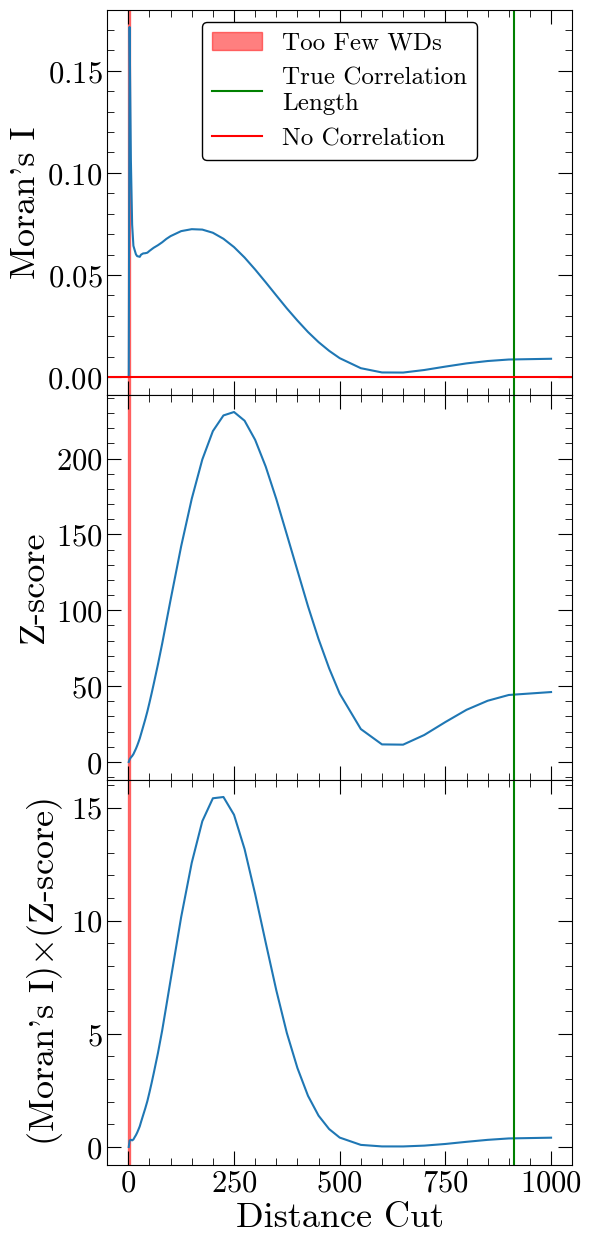

225.7 0.00043


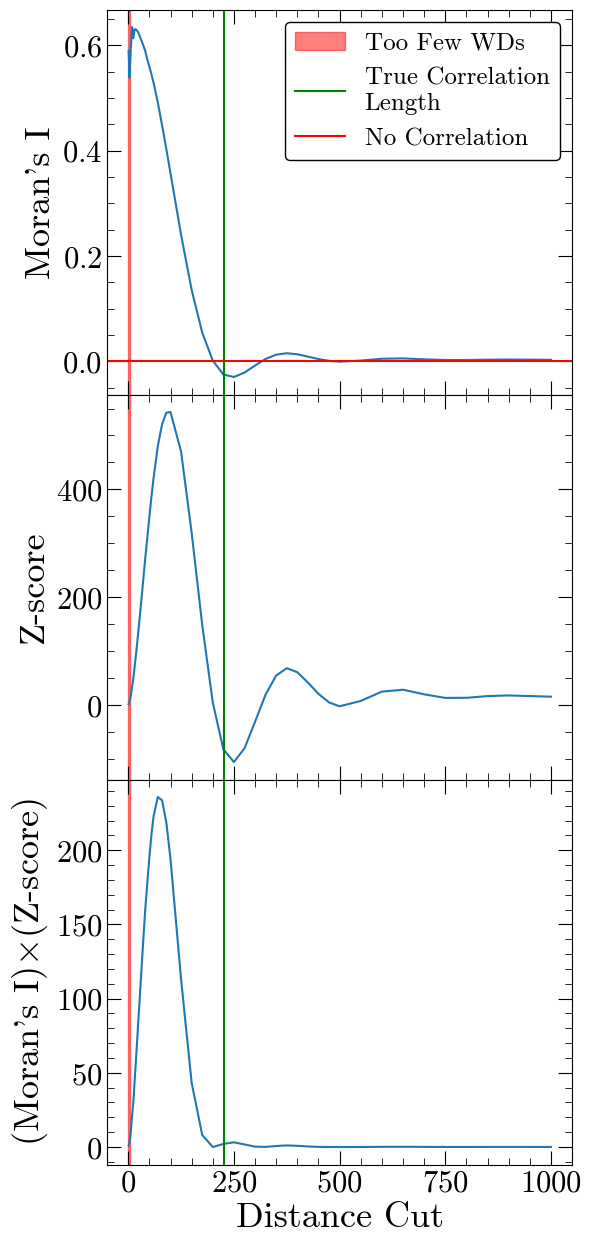

51.17 1e-10


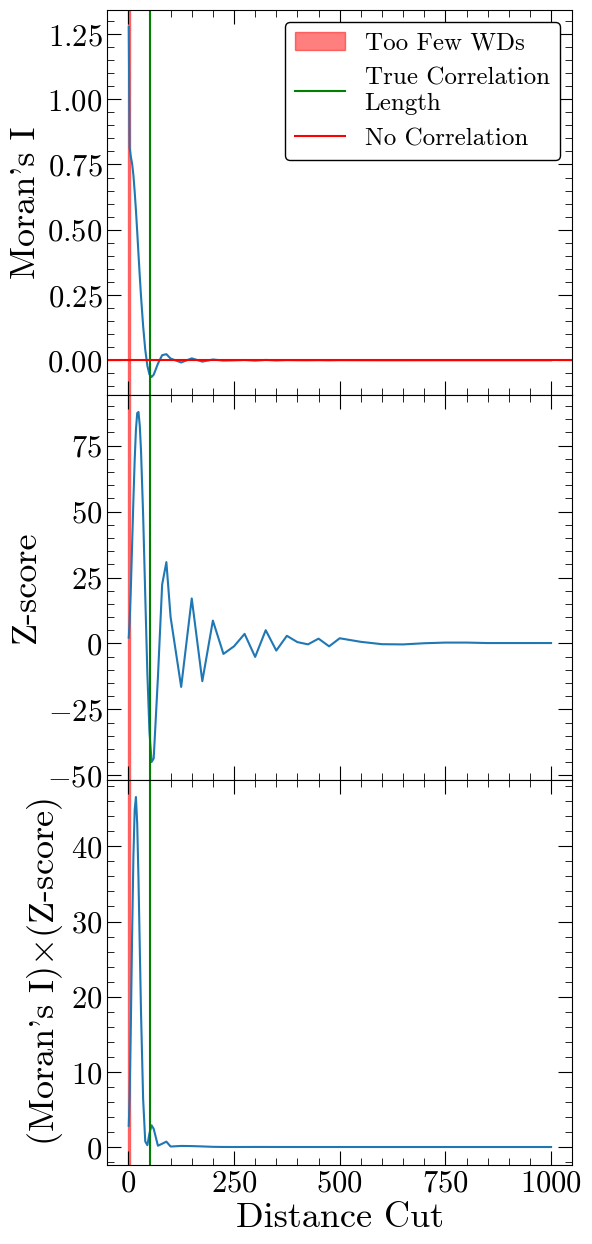

98.0 2.6e-09


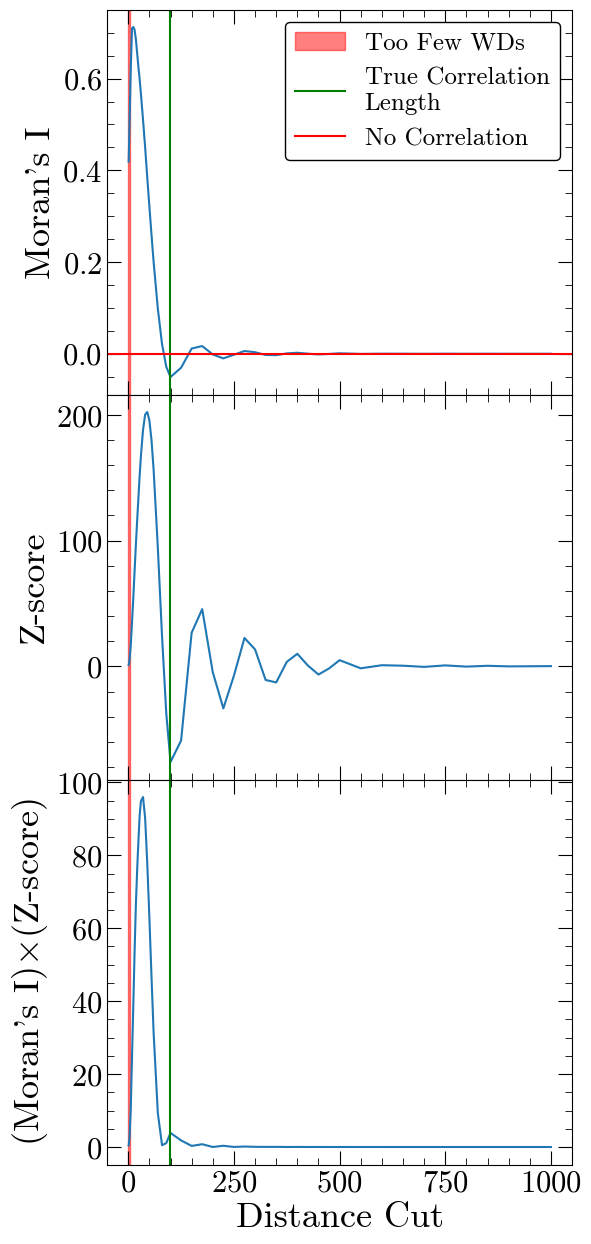

298.36 0.23


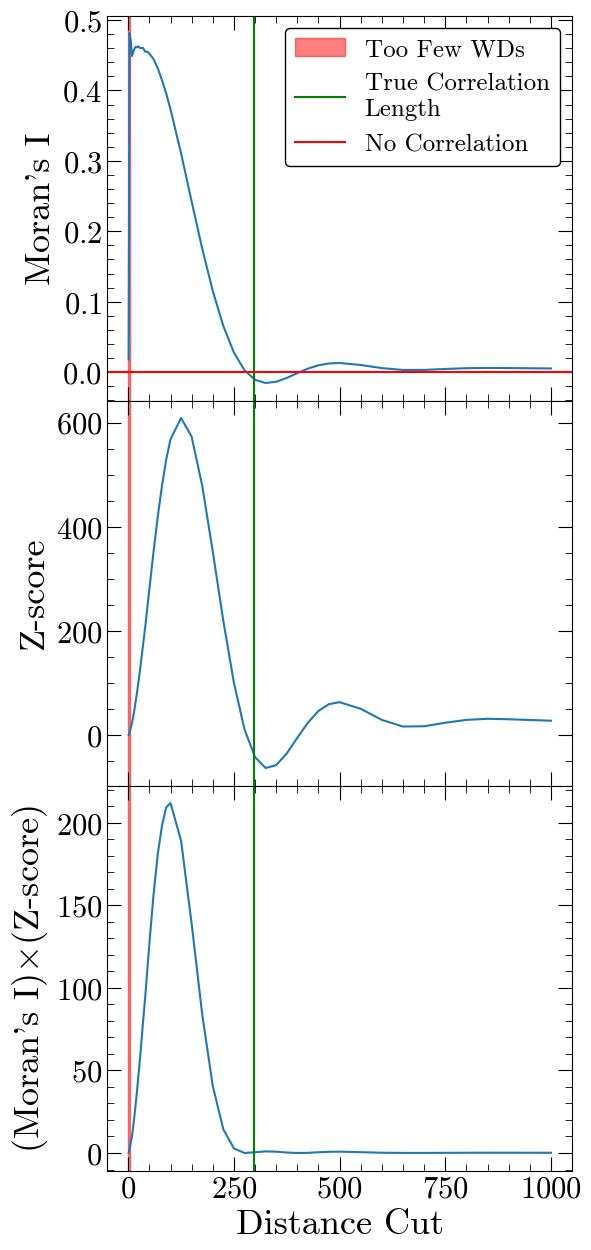

422.92 8.9e-10


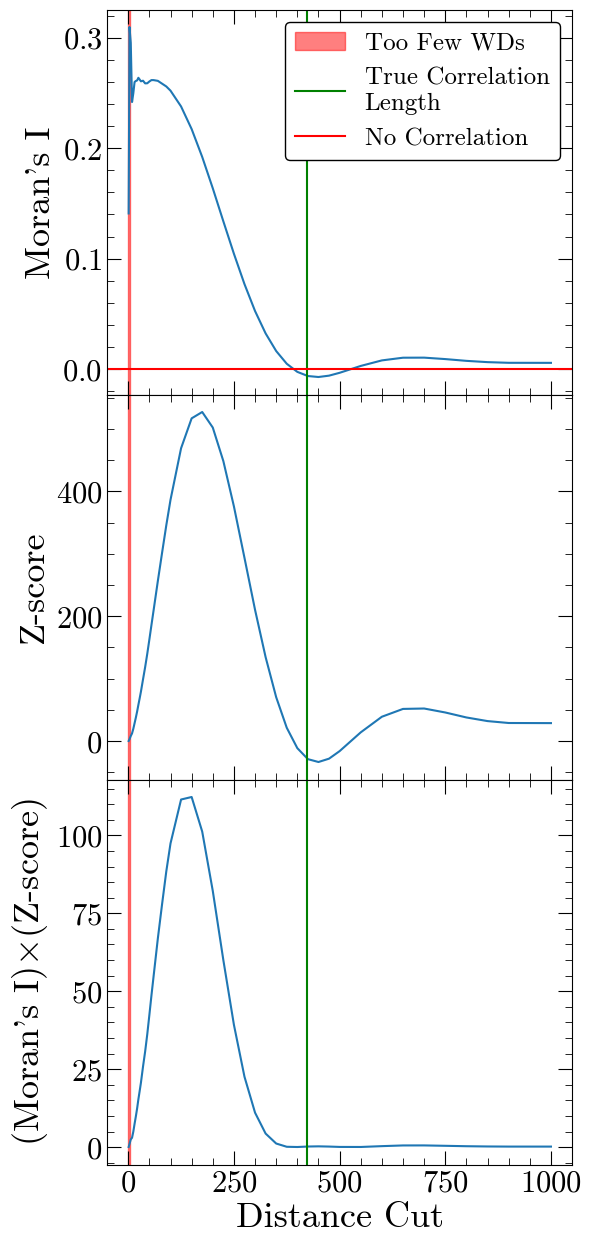

98.0 1e-10


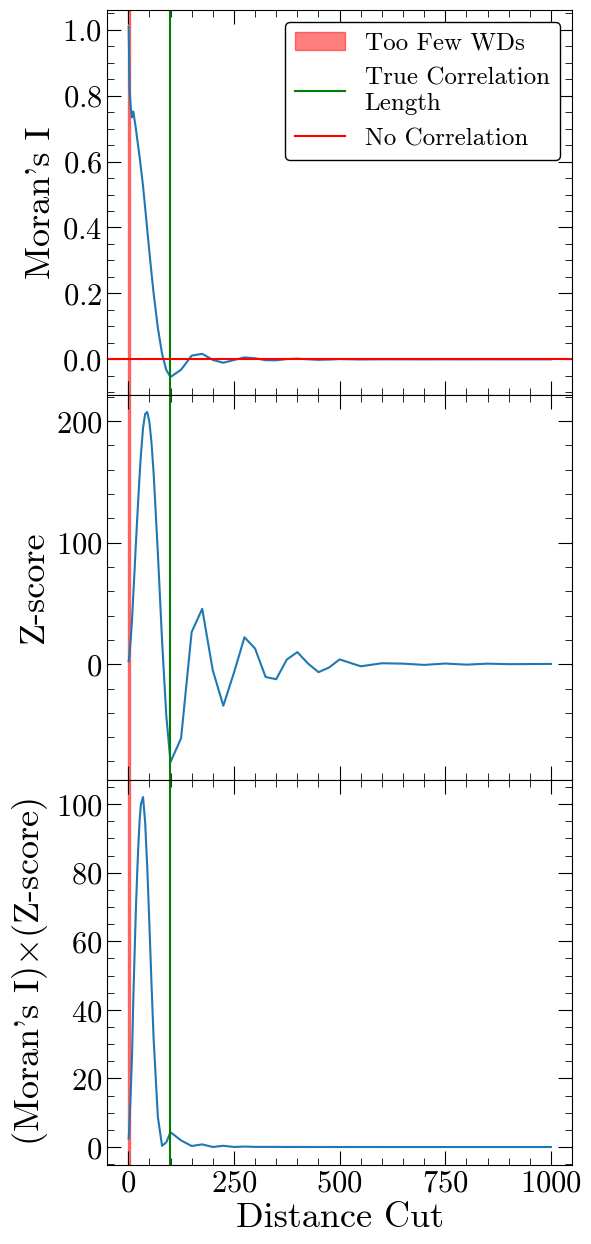

138.49 1.6e-05


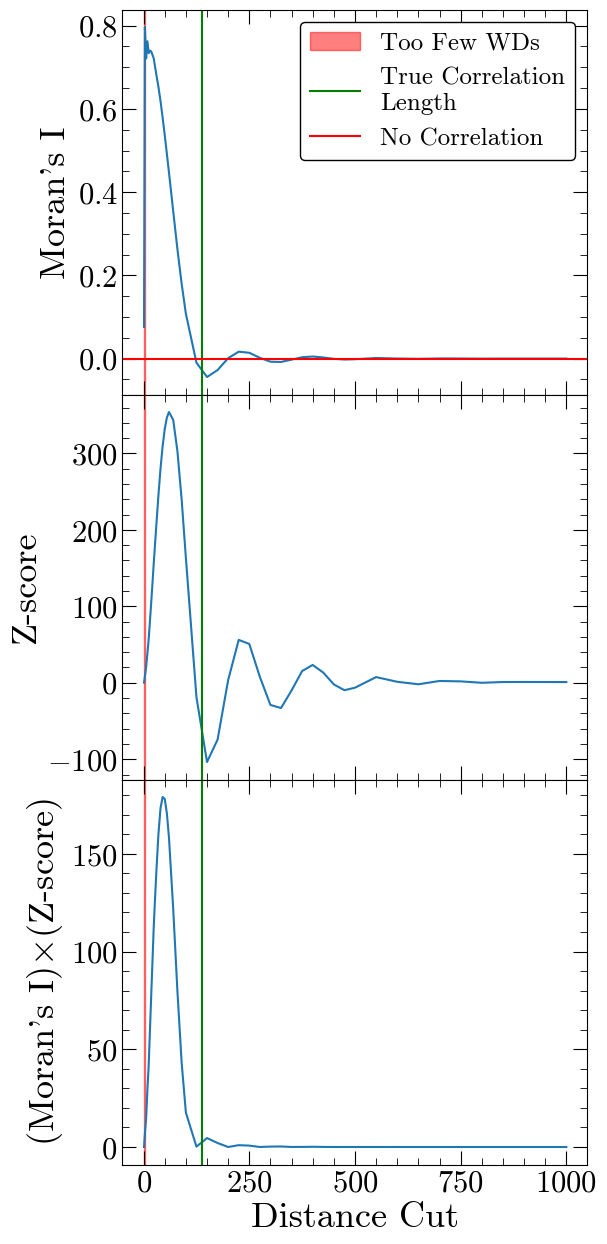

533.67 4.8e-05


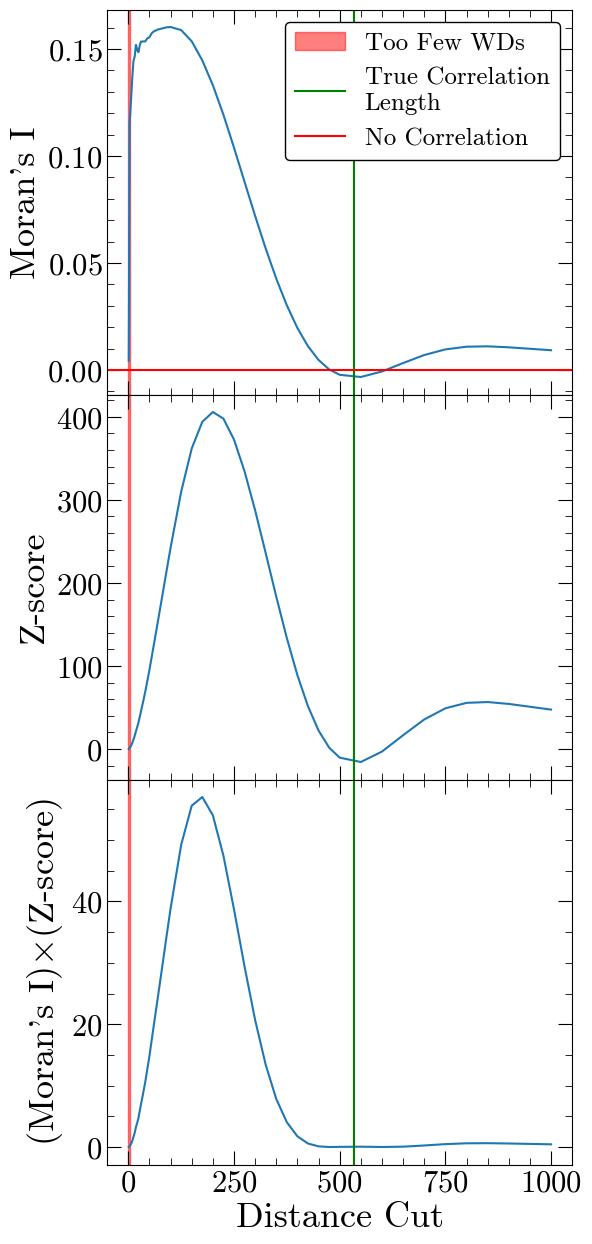

81.28 4.8e-05


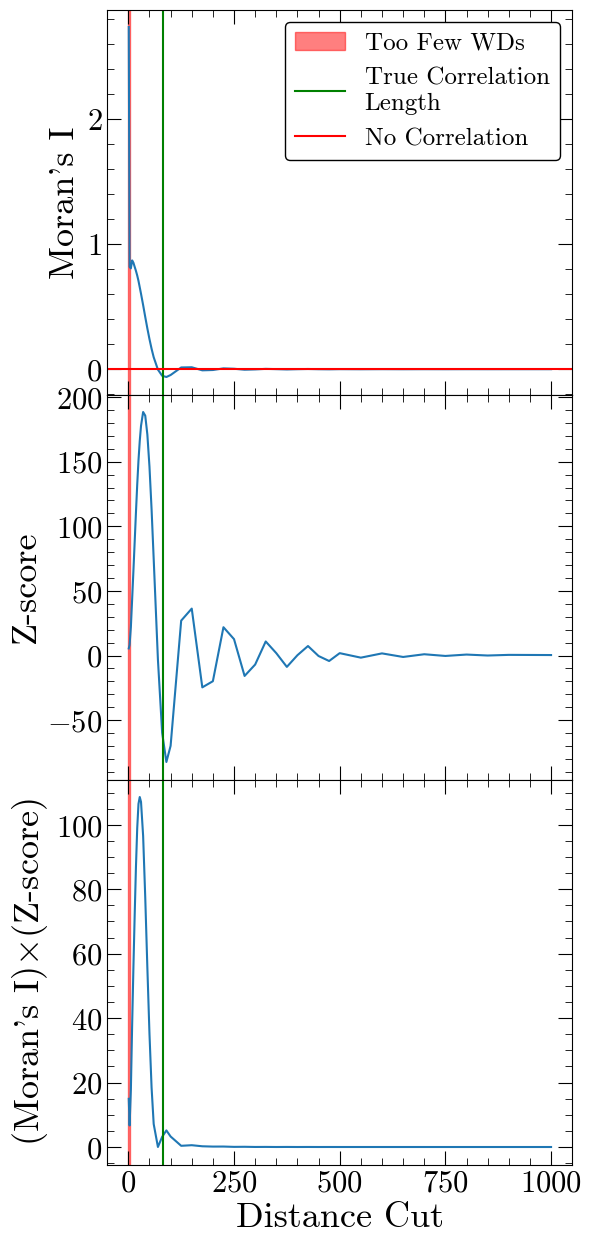

In [6]:
#display a few curves from the training data set
indices=np.random.randint(len(simulation_params_run), size=10)
for index in indices:
    corr_length=simulation_params_run[index][0]
    epsilon=simulation_params_run[index][1]
    print(corr_length,epsilon)
    sample_size=10207
    output=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

# Make a representative plot of various epsilons and correlation lengths

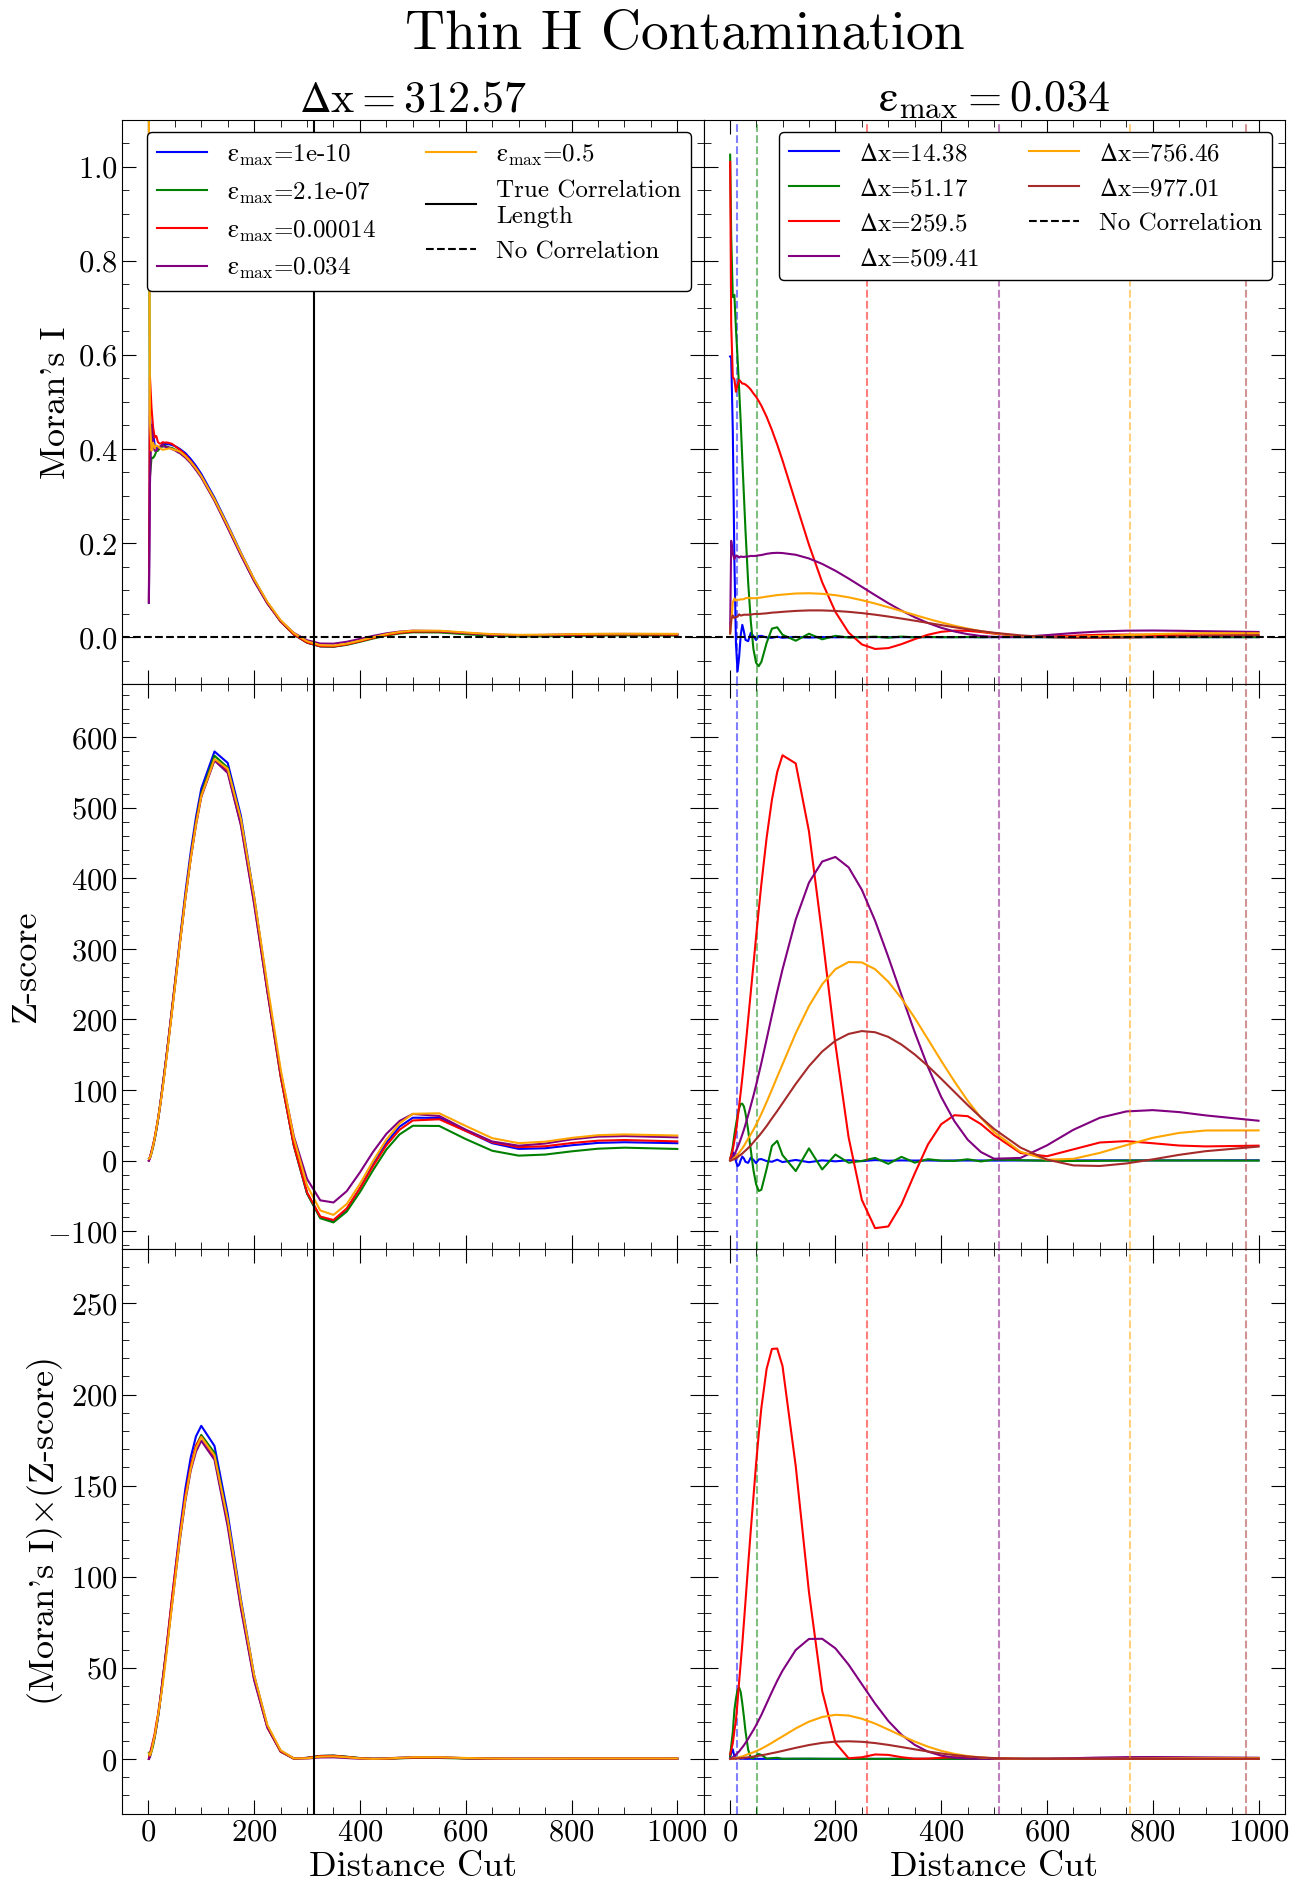

In [7]:
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize=(15,22),sharex=True)

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

#One correlation length, various epsilons
corr_length=312.57
epsilons_subset=[1e-10,2.1e-07,0.00014,0.034,0.5]
for i in range(len(epsilons_subset)):
    epsilon=epsilons_subset[i]
    color=colors[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    ax1.plot(final_distances,moransIs,color=color,label='$\epsilon_{max}$='+str(epsilon))
    ax2.plot(final_distances,zscores,color=color)
    ax3.plot(final_distances,mult,color=color)  
ax1.axvline(corr_length,color='black',label='True Correlation\nLength')
ax1.axhline(expectations[0],color='black',linestyle='--',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend(ncol=2,loc='upper right')

ax2.axvline(corr_length,color='black',label='True Correlation\nLength')
ax2.set_ylabel('Z-score')

ax3.axvline(corr_length,color='black',label='True Correlation\nLength')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

ax1.set_title('$\Delta x=$'+str(corr_length))
    
#One epsilon length, various correlation lengths
epsilon=0.034
corr_lengths_subset=[14.38, 51.17, 259.5, 509.41, 756.46, 977.01]
for i in range(len(corr_lengths_subset)):
    corr_length=corr_lengths_subset[i]
    color=colors[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    ax4.plot(final_distances,moransIs,color=color,label='$\Delta x$='+str(corr_length))
    ax4.axvline(corr_length,color=color,linestyle='--',alpha=0.5)
    ax5.plot(final_distances,zscores,color=color)
    ax5.axvline(corr_length,color=color,linestyle='--',alpha=0.5)
    ax6.plot(final_distances,mult,color=color)  
    ax6.axvline(corr_length,color=color,linestyle='--',alpha=0.5)

ax4.axhline(expectations[0],color='black',linestyle='--',label='No Correlation')
ax4.legend(ncol=2,loc='upper right')

ax6.set_xlabel('Distance Cut')

ax4.set_title('$\epsilon_{max}=$'+str(epsilon))

#clean up the plot
ax1.set_ylim(-0.1,1.1)
ax4.set_ylim(-0.1,1.1)

ax2.set_ylim(-125,675)
ax5.set_ylim(-125,675)

ax3.set_ylim(-30,280)
ax6.set_ylim(-30,280)

ax4.set_yticklabels([]) 
ax5.set_yticklabels([]) 
ax6.set_yticklabels([]) 

fig.suptitle('Thin H Contamination', fontsize=40, x=0.5, y=0.93)
plt.subplots_adjust(wspace = 0,hspace=0)

plt.savefig('curves_thin_H.pdf', dpi=300)#, pad_inches=0.3)

Text(0.5, 1.0, '$\\Delta x=$312.57')

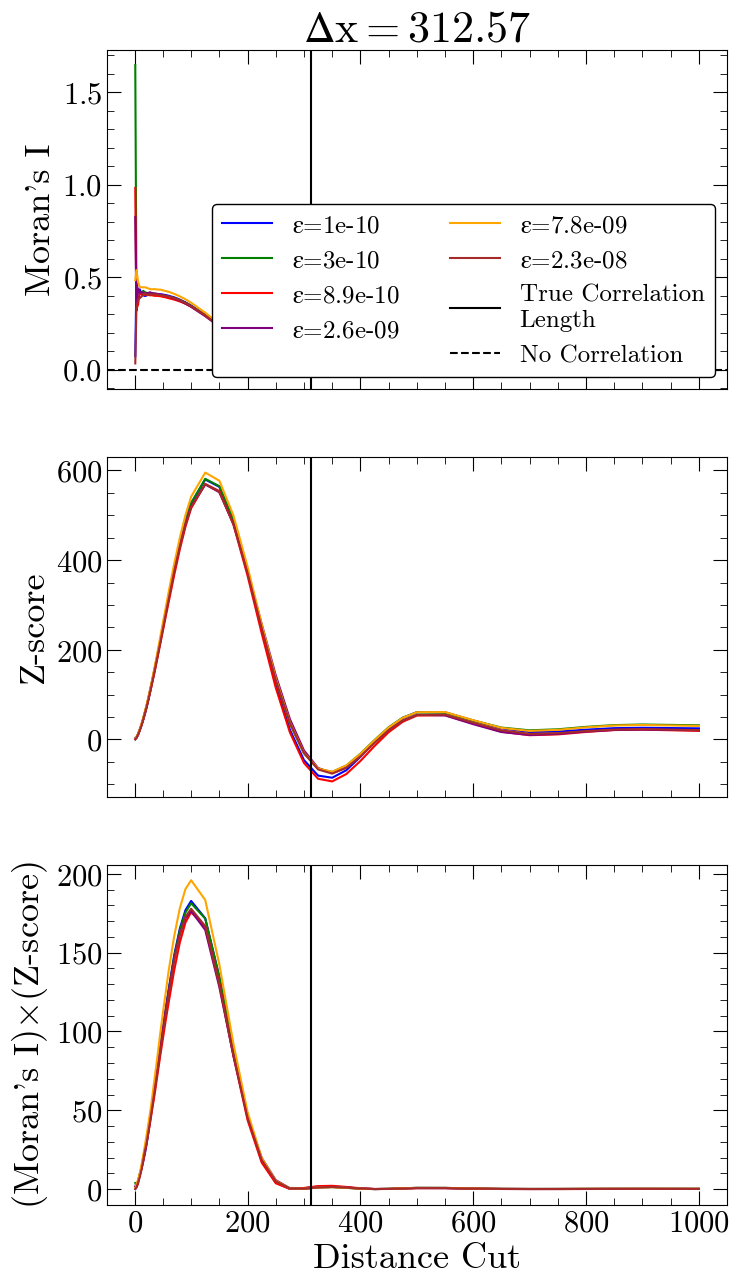

In [16]:
#find minimum visible epsilon

#min=1e-10
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(8,15),sharex=True)

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

#One correlation length, various epsilons
corr_length=312.57
epsilons_subset=[1e-10,3e-10,8.9e-10,2.6e-09,7.8e-09,2.3e-08]
for i in range(len(epsilons_subset)):
    epsilon=epsilons_subset[i]
    color=colors[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    ax1.plot(final_distances,moransIs,color=color,label='$\epsilon$='+str(epsilon))
    ax2.plot(final_distances,zscores,color=color)
    ax3.plot(final_distances,mult,color=color)  
ax1.axvline(corr_length,color='black',label='True Correlation\nLength')
ax1.axhline(expectations[0],color='black',linestyle='--',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend(ncol=2,loc='lower right')

ax2.axvline(corr_length,color='black',label='True Correlation\nLength')
ax2.set_ylabel('Z-score')

ax3.axvline(corr_length,color='black',label='True Correlation\nLength')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

ax1.set_title('$\Delta x=$'+str(corr_length))
    

#clean up the plot
# ax1.set_ylim(0.05,0.15)
# ax2.set_ylim(0,500)
# ax3.set_ylim(0,80)


# Set up the training and testing data for the CNN

In [17]:
sample_size=10207

x_train=[]
y_train=[]
ep_train=[]
for simulation in simulation_params_run:
    corr_length=simulation[0]
    epsilon=simulation[1]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    #Normalize then save Moran's I x Z-Score curve as 1D training data
    normalized=mult/np.nanmax(np.abs(mult))
    x_train.append(normalized)
    #save correlation length as true label
    y_train.append(corr_length)
    #also save epsilon
    ep_train.append(epsilon)
    
x_train=np.array(x_train)
y_train=np.array(y_train)
ep_train=np.array(ep_train)

#there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
x_train=np.nan_to_num(x_train)

#check for NaNs and Infs
print(np.isnan(x_train).any())
print(np.isinf(x_train).any())

training_data=pd.DataFrame()
training_data['y_true']=y_train
training_data['epsilon']=ep_train

training_data.head()

False
False


y_true       epsilon
0    4.34  1.000000e-10
1    4.34  3.000000e-10
2    4.34  8.900000e-10
3    4.34  2.600000e-09
4    4.34  7.800000e-09

In [18]:
x_test=[]
y_test=[]
ep_test=[]
for simulation in simulation_params_run_testing:
    corr_length=simulation[0]
    epsilon=simulation[1]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'testing',plot=False)
    #Normalize then save Moran's I x Z-Score curve as 1D training data
    normalized=mult/np.nanmax(np.abs(mult))
    x_test.append(normalized)
    #save correlation length as true label
    y_test.append(corr_length)
    #also save epsilon
    ep_test.append(epsilon)
    
x_test=np.array(x_test)
y_test=np.array(y_test)
ep_test=np.array(ep_test)

#there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
x_test=np.nan_to_num(x_test)

#check for NaNs and Infs
print(np.isnan(x_test).any())
print(np.isinf(x_test).any())

testing_data=pd.DataFrame()
testing_data['y_true']=y_test
testing_data['epsilon']=ep_test

testing_data.head()

False
False


y_true       epsilon
0      10  1.000000e-10
1      10  1.000000e-07
2      10  1.000000e-04
3      10  1.000000e-03
4      10  5.000000e-03

### Train and Test different CNN configurations

In [49]:
def comparison_stats(data,verbose,success_fit=False,success_fit_threshold=0.1):
    if success_fit:
        init_len=len(data)
        data['abs_frac_err']=np.abs((data['y_true']-data['y_pred'])/data['y_true'])
        data=data.query('abs_frac_err<@success_fit_threshold')
        num_success=len(data)
        #reset the indices
        indices=np.arange(0,len(data))
        data.set_index(indices,inplace=True)
        y_true=data['y_true']
        y_pred=data['y_pred']
        frac_success=num_success/init_len
    else:
        y_true=data['y_true']
        y_pred=data['y_pred']
        frac_success=None
    
    error=y_true-y_pred
    frac_err=error/y_true
    
    #calculate the rmse
    rmse = 0
    for i in range(len(y_true)):
        rmse += (error[i])**2
    rmse = np.sqrt(rmse / len(y_true))
    
    #calculate the median absolute error between the datasets
    mae=np.median(np.abs(error))

    #calculate the bias between the datasets
    bias=np.median(error)
    
    #calculate the median absolute fractional error
    med_frac=np.median(np.abs(frac_err))
    
    if verbose:
        if success_fit:
            print(r'Frac Success Fit: {:2.3f} '.format(frac_success))
        print(r'RMSE: {:2.3f} '.format(rmse)+'pc')
        print(r'MAE: {:2.3f} '.format(mae)+'pc')
        print(r'BIAS: {:2.3f} '.format(bias)+'pc')
        print(r'MED FRAC ERR: {:2.3f} '.format(med_frac))
        
    return(rmse,mae,bias,med_frac,error,frac_err,frac_success)

In [50]:
def comparison_plots(training_data,testing_data,success_fit_threshold=0.1,statx=10,staty=700,statdy=50,lim='default', siegel=True,verbose=True):
    #drop the failed fits
    testing_data=testing_data.dropna()
    #reset the indices
    indices=np.arange(0,len(testing_data))
    testing_data.set_index(indices,inplace=True)
    
    y_true_training=training_data['y_true']
    y_pred_training=training_data['y_pred']
    y_true_testing=testing_data['y_true']
    y_pred_testing=testing_data['y_pred']
    
    unit='pc'
    
    #calculate stats
    if verbose:
        print('Training Stats')
    rmse_training,mae_training,bias_training,med_frac_training,error_training,frac_err_training,frac_success=comparison_stats(training_data,verbose)
    if verbose:
        print('')
        print('Training Stats, Successful Fits')
    rmse_training_success,mae_training_success,bias_training_success,med_frac_training_success,error_training_success,frac_err_training_success,frac_success_training=comparison_stats(training_data,verbose,True,success_fit_threshold)
    if verbose:
        print('')
        print('Testing Stats')
    rmse_testing,mae_testing,bias_testing,med_frac_testing,error_testing,frac_err_testing,frac_success=comparison_stats(testing_data,verbose)
    if verbose:
        print('')
        print('Testing Stats, Successful Fits')
    rmse_testing_success,mae_testing_success,bias_testing_success,med_frac_testing_success,error_testing_success,frac_err_testing_success,frac_success_testing=comparison_stats(testing_data,verbose,True,success_fit_threshold)
    
    stats_df=pd.DataFrame()
    stats_df['mae_training']=[mae_training]
    stats_df['frac_success_training']=[frac_success_training]
    stats_df['mae_testing']=[mae_testing]
    stats_df['frac_success_testing']=[frac_success_testing]
    
    display(stats_df)
    
    #plot the agreement with stats
    fig, (ax1,ax2) =plt.subplots(1,2,figsize=(16,8))
    ax1.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax1.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax1.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax1.text(statx, staty, 'Frac Success: {:2.3f} '.format(frac_success_testing))
    ax1.text(statx, staty-1*statdy, 'RMSE = {:.3f} '.format(rmse_testing_success)+unit)
    ax1.text(statx, staty-2*statdy, 'MAE = {:.3f} '.format(mae_testing_success)+unit)
    ax1.text(statx, staty-3*statdy, 'Bias = {:.3f} '.format(bias_testing_success)+unit)
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'Measured Correlation Length (pc)')
    maxval=max(max(y_true_training),max(y_pred_training))
    minval=min(min(y_true_training),min(y_pred_training))
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
        
    ax2.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax2.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax2.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax2.set_xlabel(r'True Correlation Length (pc)')
    ax2.set_ylabel(r'Measured Correlation Length (pc)')
    maxval=max(max(y_true_training),max(y_pred_training))
    minval=min(min(y_true_training),min(y_pred_training))
    #plot 1 to 1 trendline
    ax2.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax2.legend()
    if lim!='default':
        ax2.set_xlim((lim[0],lim[1]))
        ax2.set_ylim((lim[0],lim[1]))
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.show()
    
    #plot the agreement with trendlines
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    ax1.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax1.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax1.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'Measured Correlation Length (pc)')
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    #add a linear trendlines
    if siegel==True:
        coef = stats.siegelslopes(y_pred_testing, y_true_testing)
        poly1d_fn = np.poly1d(coef) 
        ax1.plot([minval,maxval], poly1d_fn([minval,maxval]), label="Trendline\n"+str(np.round(coef[0],2))+"*x+"+str(np.round(coef[1],2)))
    else:
        coef= np.polyfit(y_true_testing,y_pred_testing,1)
        poly1d_fn= np.poly1d(coef) 
        ax1.plot([minval,maxval], poly1d_fn([minval,maxval]), label="Trendline\n"+str(np.round(coef[0],2))+"*x+"+str(np.round(coef[1],2)))
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
    plt.show()

    # plot the fractional error between the datasets
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    ax1.scatter(y_true_training, frac_err_training,c='k',alpha=0.3,label='Training Data')
    ax1.scatter(y_true_testing, frac_err_testing,c='r',label='Testing Data')
    ax1.axhline(med_frac_testing,color='green',label='MED ABS FRAC ERR = {:.3f}'.format(med_frac_testing_success))
    ax1.axhline(-med_frac_testing,color='green')
    ax1.axhline(success_fit_threshold,color='blue',label='Successful Threshold = {:.3f}'.format(success_fit_threshold))
    ax1.axhline(-success_fit_threshold,color='blue')
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'(True-Pred)/True')
    ax1.legend()
    plt.show()
    
    # plot the fractional error between the datasets
    # again but zoomed in
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    ax1.scatter(y_true_training, frac_err_training,c='k',alpha=0.3,label='Training Data')
    ax1.scatter(y_true_testing, frac_err_testing,c='r',label='Testing Data')
    ax1.axhline(med_frac_testing,color='green',label='MED ABS FRAC ERR = {:.3f}'.format(med_frac_testing_success))
    ax1.axhline(-med_frac_testing,color='green')
    ax1.axhline(success_fit_threshold,color='blue',label='Successful Threshold = {:.3f}'.format(success_fit_threshold))
    ax1.axhline(-success_fit_threshold,color='blue')
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'(True-Pred)/True')
    ax1.set_ylim((-1,1))
    ax1.legend()
    plt.show()
    
    return(stats_df)
    

In [51]:
#define a function to create the heatmap
def heatmap(data, row_labels, col_labels, ax=None):
    if not ax:
        ax = plt.gca()
        
    # Define color map with custom gradients
    cmap = plt.cm.viridis  # Default, replace with any colormap of your choice
    # Define boundaries for the color ranges
    boundaries = [0, 2, 4, 6, 8, 10, 1000]
    # Define colors corresponding to each range (make sure this matches the number of ranges)
    colors_for_ranges = [
    '#228B22',  # Forest Green
    '#32CD32',  # Lime Green
    '#FFD700',  # Gold (Yellow)
    '#FFA500',  # Orange
    '#FF4500',  # Orange Red
    '#DC143C',  # Crimson
    'black']
    # Create a ListedColormap and BoundaryNorm
    cmap = pltcolors.ListedColormap(colors_for_ranges)
    norm = pltcolors.BoundaryNorm(boundaries, cmap.N)
    
    # Plot the heatmap
    im = ax.imshow(data, cmap=cmap, norm=norm)
    
    #label rows/columns
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)#, fontsize=10)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)
    
    #draw grid lines
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=0.5,alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False,top=False, right=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    return im

def heatmap_testing_data(testing_data,figtitle=None,savefig=False,figname=None):
    data=[]
    failed_fit_region_count=0
    for corr_len in corr_lengths_testing:
        tmp=[]
        for epsilon in epsilons_testing:
            val=testing_data.query('y_true==@corr_len & epsilon==@epsilon')['abs_frac_err'].to_list()[0]*100
            tmp.append(val)
            if val>10:
                failed_fit_region_count+=1
        data.append(tmp)
    data=np.array(data)
    
    fig,ax0=plt.subplots(1, 1, figsize=(10, 10))
    ylabels=[str(i) for i in corr_lengths_testing]
    xlabels=[str(i) for i in epsilons_testing]
    hm=heatmap(data, ylabels, xlabels, ax=ax0)
    ax0.set_xlabel('$\epsilon$')
    ax0.set_ylabel('$\Delta x_{true}$')
    
    ax0.set_title(figtitle)
    
    #plot colorbar
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    fig.colorbar(hm, cbar_ax)
    cbar_ax.set_ylabel("Absolute Percent Error")#,fontsize=16)
    
    if savefig:
        plt.savefig(figname+'.pdf', dpi=300)
        
    plt.show()
    print('Number of squares with abs percent err>10%, ', failed_fit_region_count)

    return(failed_fit_region_count)

In [76]:
def test_model(model,stats=True,plot=True):
    sample_size=10207
    
    # use the model to predict the training data
    y_pred_train = model.predict(x_train, verbose=0)
    training_data['y_pred']=y_pred_train
    
    # use the model to predict the testing data
    y_pred_test = model.predict(x_test, verbose=0)
    testing_data['y_pred']=y_pred_test
    
    rmse_testing_success,mae_testing_success,bias_testing_success,med_frac_testing_success,error_testing_success,frac_err_testing_success,frac_success_testing=comparison_stats(testing_data,False,True,success_fit_threshold=0.1)
    
    if plot:
        #some runs return NaNs, show those fits
        nan_corr_lengths=testing_data[testing_data['y_pred'].isna()]
        print('')
        print('Showing the '+str(len(nan_corr_lengths))+' curves that returned NaNs')
        display(nan_corr_lengths)
        for i in range(len(nan_corr_lengths)):
            corr_length=nan_corr_lengths['y_true'].to_list()[i]
            epsilon=nan_corr_lengths['epsilon'].to_list()[i]
            output=get_output(corr_length,epsilon,sample_size,'testing',plot=True)

        #show comparison stats and plots
        stats_df=comparison_plots(training_data,testing_data)
        
        #show testing data absolute percent error heatmap
        failed_fit_region_count=heatmap_testing_data(testing_data) 
    else:
        stats_df=None
        nan_corr_lengths='Not saved!'
        failed_fit_region_count=0
        for corr_len in corr_lengths_testing:
            for epsilon in epsilons_testing:
                val=testing_data.query('y_true==@corr_len & epsilon==@epsilon')['abs_frac_err'].to_list()[0]*100
                if val>10:
                    failed_fit_region_count+=1
    
    if stats:
        return(stats_df)
    else:
        return(failed_fit_region_count,mae_testing_success,training_data,testing_data,nan_corr_lengths)

# Pick models and tune the model hyperparameters

1. **Number of Filters in Convolutional Layers**
   The number of filters (also known as the number of output channels) determines the depth of the feature maps after each convolutional layer.
   **What to try:**
   - You can experiment with **increasing** the number of filters in each layer.
   - Alternatively, **decrease** the number of filters to make the model simpler and see if performance improves.
   
   Keep in mind that increasing the number of filters typically increases the model’s capacity, which can improve performance on more complex tasks but may also lead to overfitting if not properly regularized.

2. **Kernel Size**
   The kernel size defines the window of the convolution. 
   **What to try:**
   - **Larger kernel sizes** (e.g., 5 or 7) might capture broader patterns, which can be useful if the input data has long-range dependencies.
   - **Smaller kernel sizes** (e.g., 1 or 2) might be beneficial if you want to capture very fine-grained features.

3. **Number of Layers**
   The depth of the network can have a significant impact on its performance.
   **What to try:**
   - Adding more **convolutional layers** (e.g., 4 or 5 layers instead of 3) could help the model learn more complex patterns.
   - Alternatively, you can **reduce the number of layers** and see if performance improves, especially if overfitting is a concern.

4. **Pooling Layers**
   Pooling layers help reduce spatial dimensions and retain important features. You're using `MaxPooling1D(2)` after each convolution layer, which is a good starting point.
   **What to try:**
   - **Change the pooling size** (e.g., use `MaxPooling1D(3)` or `MaxPooling1D(4)`).
   - Experiment with different **types of pooling** (e.g., **AveragePooling1D**) to see if it affects performance.

5. **Dense Layer Units**
   In your current model, the final dense layer has 128 units with ReLU activation. The number of units in this layer controls the representational capacity of the fully connected portion of the network.
   **What to try:**
   - You can experiment with **increasing** or **decreasing** the number of units (e.g., try 64 or 256 units).
   - You can also **add another dense layer** between the existing dense layer and the output to increase the model's capacity.

6. **Optimizer and Learning Rate**
   You're using the **Adam optimizer** with its default settings, which is a good default choice for most tasks. However, adjusting the learning rate can have a significant impact on performance.
   **What to try:**
   - **Adjust the learning rate** (e.g., `learning_rate=0.001`, `learning_rate=0.0005`, `learning_rate=0.0001`).
   - You could also experiment with **different optimizers** (e.g., **SGD**, **RMSprop**) to see if they improve convergence speed or final accuracy.

7. **Batch Size**
   The batch size you’re currently using is 32, which is a standard choice.
   **What to try:**
   - Experiment with **larger batch sizes** (e.g., 64 or 128) to speed up training, or **smaller batch sizes** (e.g., 16 or 8) if you believe that could help the model generalize better.
   - Smaller batch sizes can help avoid local minima, while larger batch sizes usually converge faster.

8. **Regularization (Dropout or L2 Regularization)**
   You’re not using any regularization at the moment, which may cause overfitting, especially with a deep model.
   **What to try:**
   - **Dropout**: Add `Dropout` layers after the convolutional or dense layers to help prevent overfitting. Try dropout rates between 0.2 and 0.5.
   - **L2 Regularization**: Add L2 regularization to your layers, which helps penalize large weights and reduces overfitting. Example: `kernel_regularizer=l2(0.01)`.

9. **Activation Function**
   You're using ReLU as the activation function for all layers, which is quite common.
   **What to try:**
   - Experiment with different **activation functions** for the hidden layers, such as **LeakyReLU**, **ELU**, or **SELU**.
   - For the output layer, if you're predicting a continuous variable (since you're using `mse` loss), you may want to use a **linear activation** (which is the default for `Dense(1)`).


Epoch 1/100
92/92 [==============================] - 1s 9ms/step - loss: 113154.8125
Epoch 2/100
92/92 [==============================] - 1s 6ms/step - loss: 16204.7900
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 2626.6406
Epoch 4/100
92/92 [==============================] - 1s 7ms/step - loss: 1531.4438
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 1047.8243
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 806.5048
Epoch 7/100
92/92 [==============================] - 1s 8ms/step - loss: 669.4419
Epoch 8/100
92/92 [==============================] - 1s 7ms/step - loss: 611.5547
Epoch 9/100
92/92 [==============================] - 1s 7ms/step - loss: 513.3914
Epoch 10/100
92/92 [==============================] - 1s 7ms/step - loss: 464.1291
Epoch 11/100
92/92 [==============================] - 1s 6ms/step - loss: 422.0672
Epoch 12/100
92/92 [==============================] - 1s 6ms/step - loss: 369.3085
Epoch

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 13.698 pc
MAE: 2.572 pc
BIAS: -1.520 pc
MED FRAC ERR: 0.014 

Training Stats, Successful Fits
Frac Success Fit: 0.970 
RMSE: 12.345 pc
MAE: 2.566 pc
BIAS: -1.585 pc
MED FRAC ERR: 0.014 

Testing Stats
RMSE: 21.669 pc
MAE: 2.913 pc
BIAS: -0.946 pc
MED FRAC ERR: 0.017 

Testing Stats, Successful Fits
Frac Success Fit: 0.941 
RMSE: 18.441 pc
MAE: 2.865 pc
BIAS: -1.484 pc
MED FRAC ERR: 0.016 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      2.572321               0.969873     2.912895              0.941406

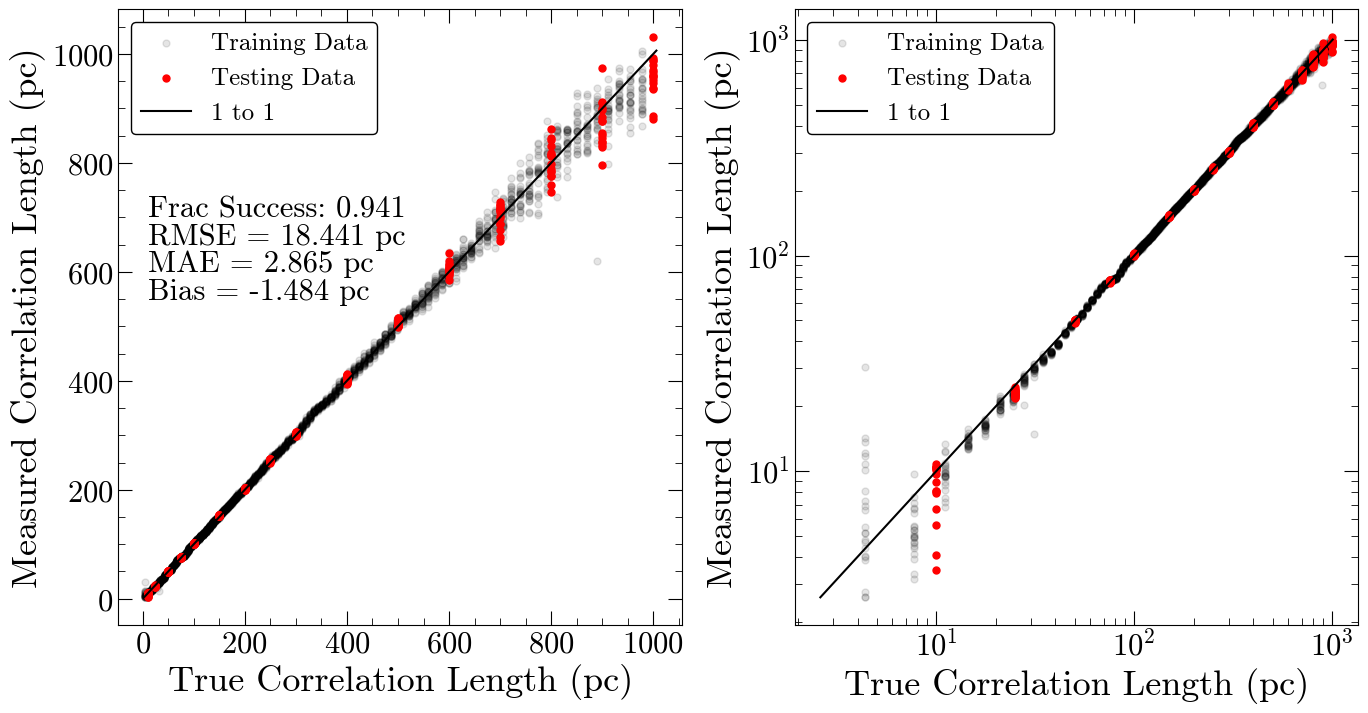

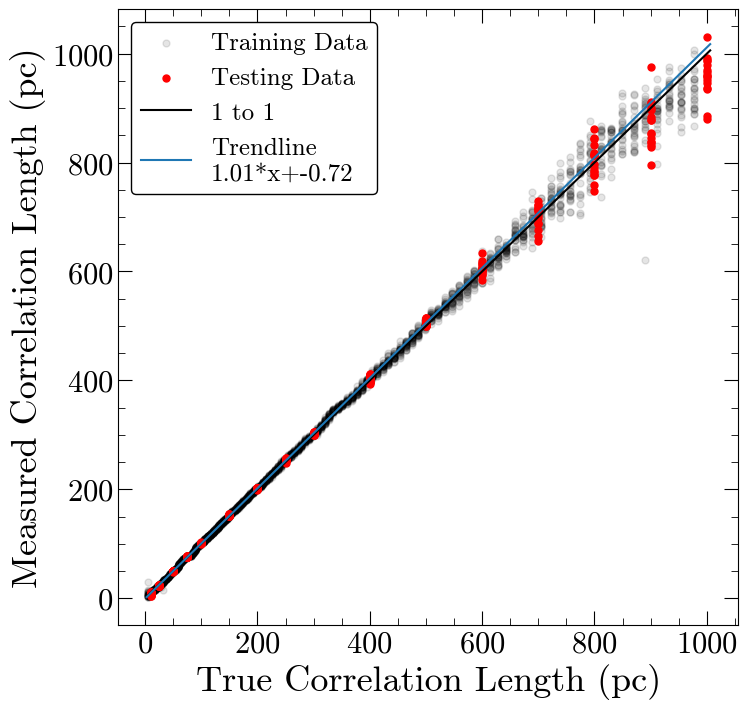

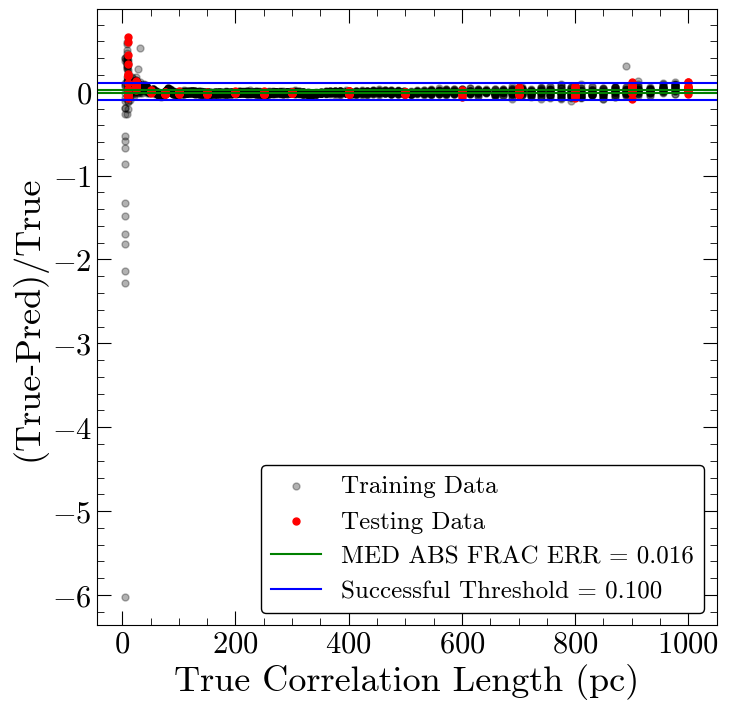

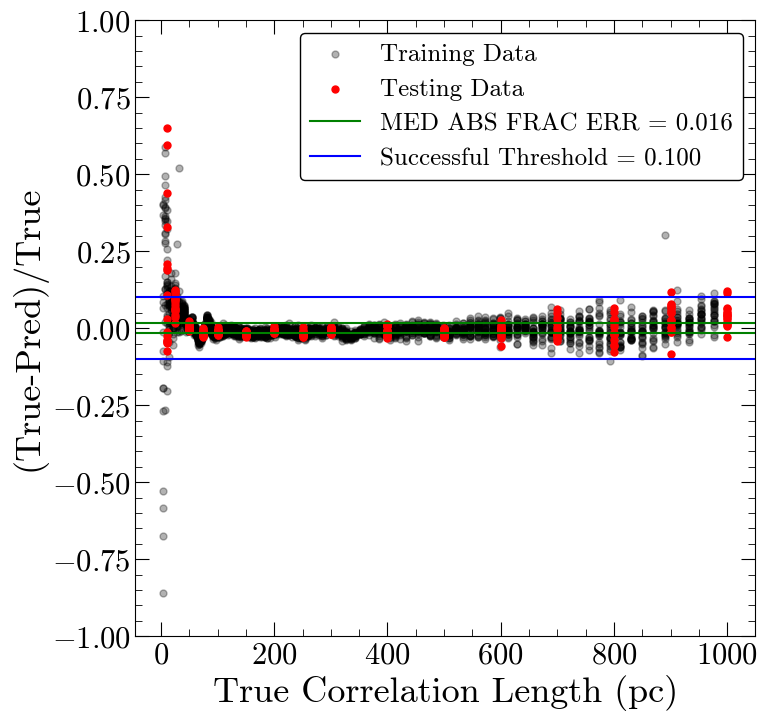

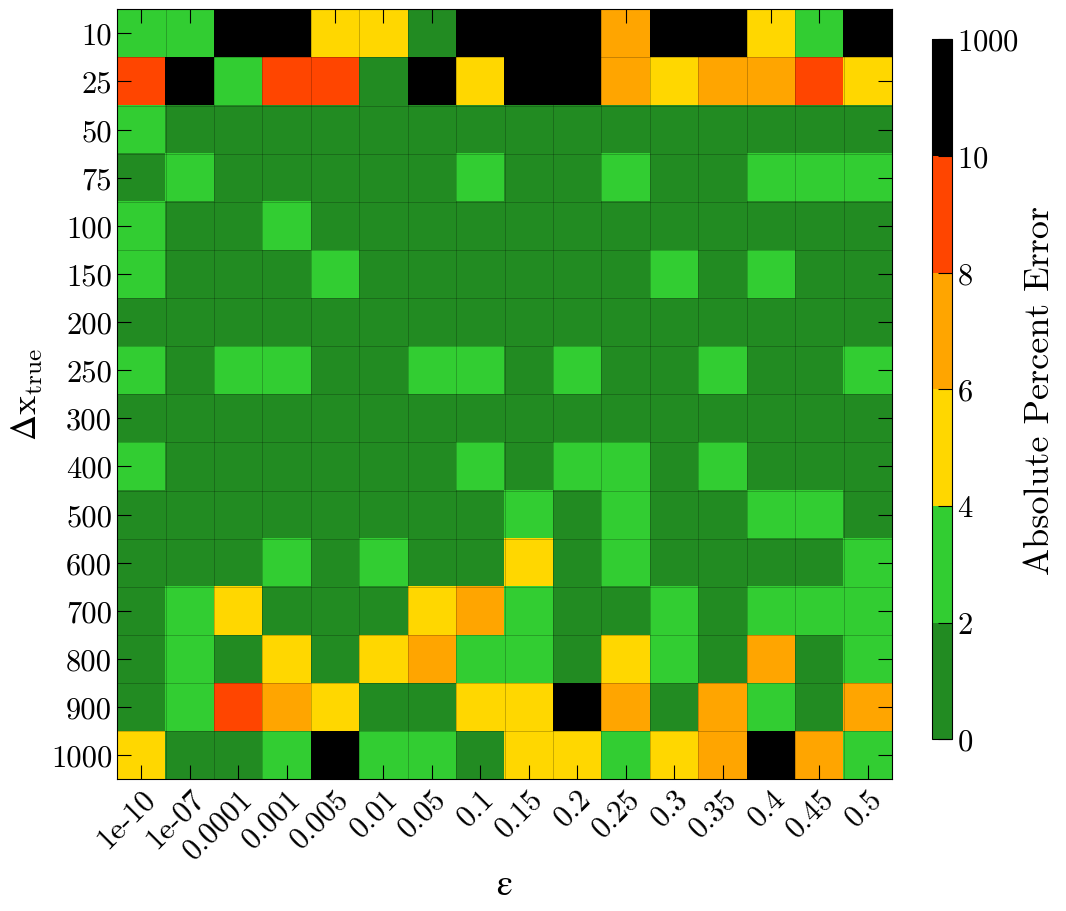

Number of squares with abs percent err>10%,  15


In [61]:
#simple model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'), 
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats for all models to compare and find best model
all_model_stats=output

Epoch 1/200
92/92 [==============================] - 1s 8ms/step - loss: 112800.8359
Epoch 2/200
92/92 [==============================] - 1s 6ms/step - loss: 19437.0879
Epoch 3/200
92/92 [==============================] - 1s 6ms/step - loss: 2814.0850
Epoch 4/200
92/92 [==============================] - 1s 6ms/step - loss: 1598.9609
Epoch 5/200
92/92 [==============================] - 1s 7ms/step - loss: 972.6243
Epoch 6/200
92/92 [==============================] - 1s 6ms/step - loss: 709.8250
Epoch 7/200
92/92 [==============================] - 1s 6ms/step - loss: 592.3432
Epoch 8/200
92/92 [==============================] - 1s 8ms/step - loss: 499.9885
Epoch 9/200
92/92 [==============================] - 1s 6ms/step - loss: 446.6651
Epoch 10/200
92/92 [==============================] - 1s 7ms/step - loss: 422.2185
Epoch 11/200
92/92 [==============================] - 1s 6ms/step - loss: 383.9943
Epoch 12/200
92/92 [==============================] - 1s 6ms/step - loss: 346.8916
Epoch 

92/92 [==============================] - 1s 7ms/step - loss: 206.0706
Epoch 197/200
92/92 [==============================] - 1s 6ms/step - loss: 191.1778
Epoch 198/200
92/92 [==============================] - 1s 7ms/step - loss: 193.1204
Epoch 199/200
92/92 [==============================] - 1s 6ms/step - loss: 190.7142
Epoch 200/200
92/92 [==============================] - 1s 7ms/step - loss: 193.6394

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 14.425 pc
MAE: 4.407 pc
BIAS: 4.081 pc
MED FRAC ERR: 0.026 

Training Stats, Successful Fits
Frac Success Fit: 0.912 
RMSE: 13.525 pc
MAE: 4.478 pc
BIAS: 4.111 pc
MED FRAC ERR: 0.024 

Testing Stats
RMSE: 22.936 pc
MAE: 4.634 pc
BIAS: 4.028 pc
MED FRAC ERR: 0.026 

Testing Stats, Successful Fits
Frac Success Fit: 0.883 
RMSE: 20.151 pc
MAE: 4.934 pc
BIAS: 4.131 pc
MED FRAC ERR: 0.023 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      4.406704               0.912359     4.633732              0.882812

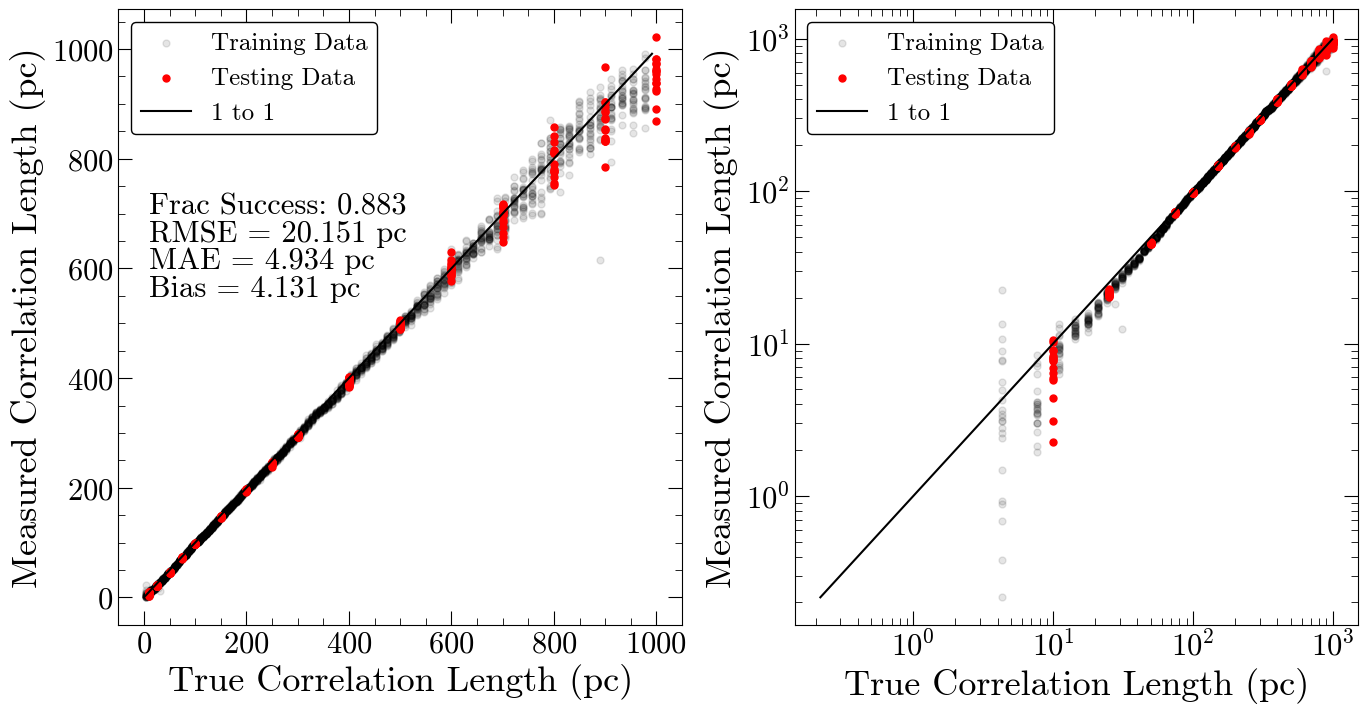

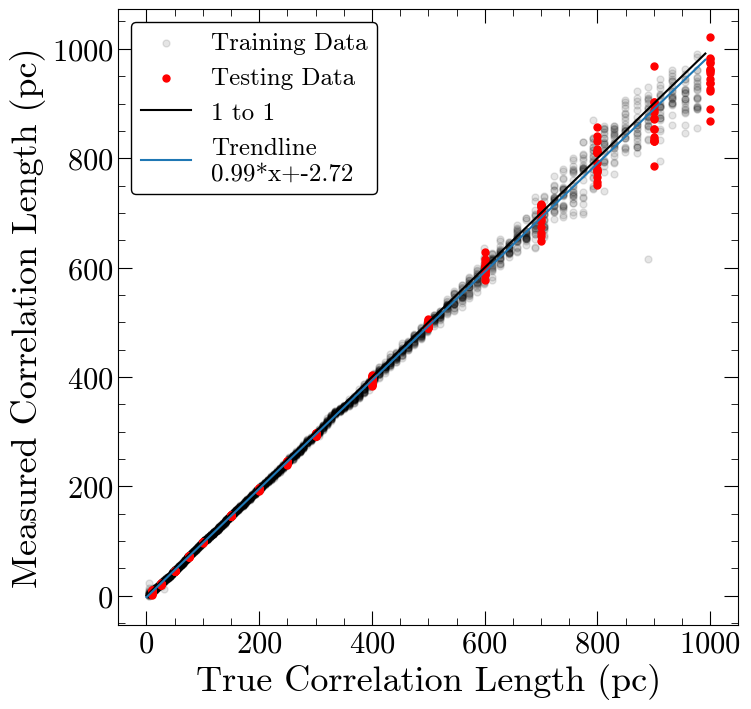

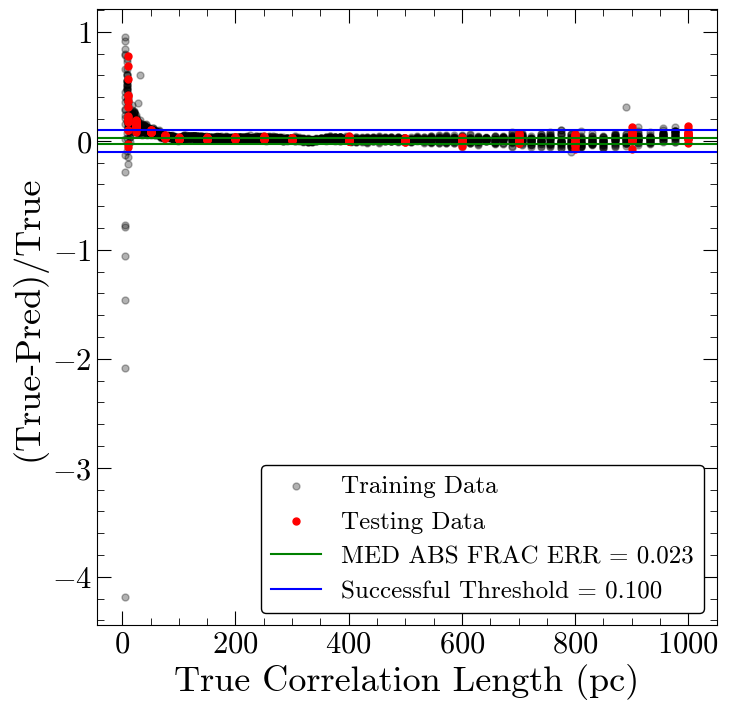

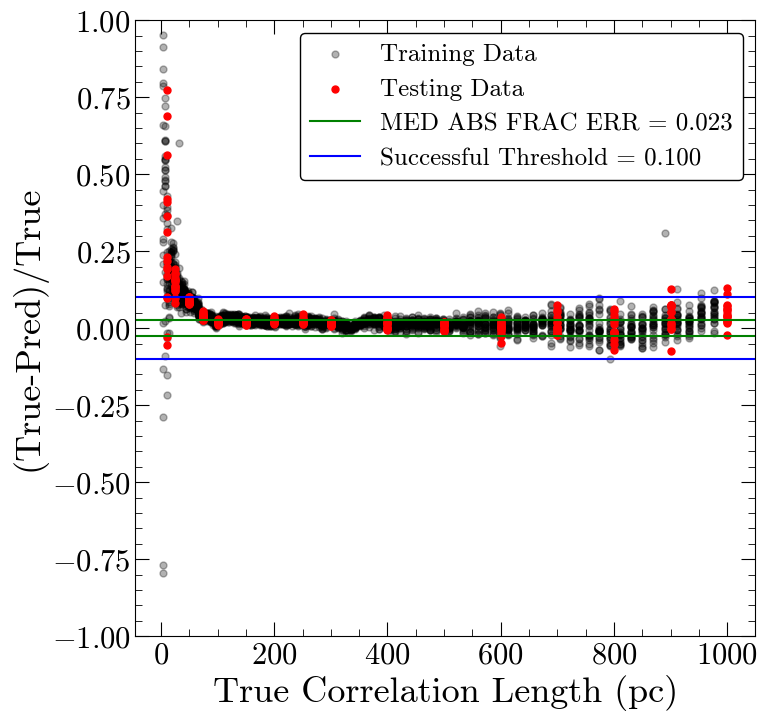

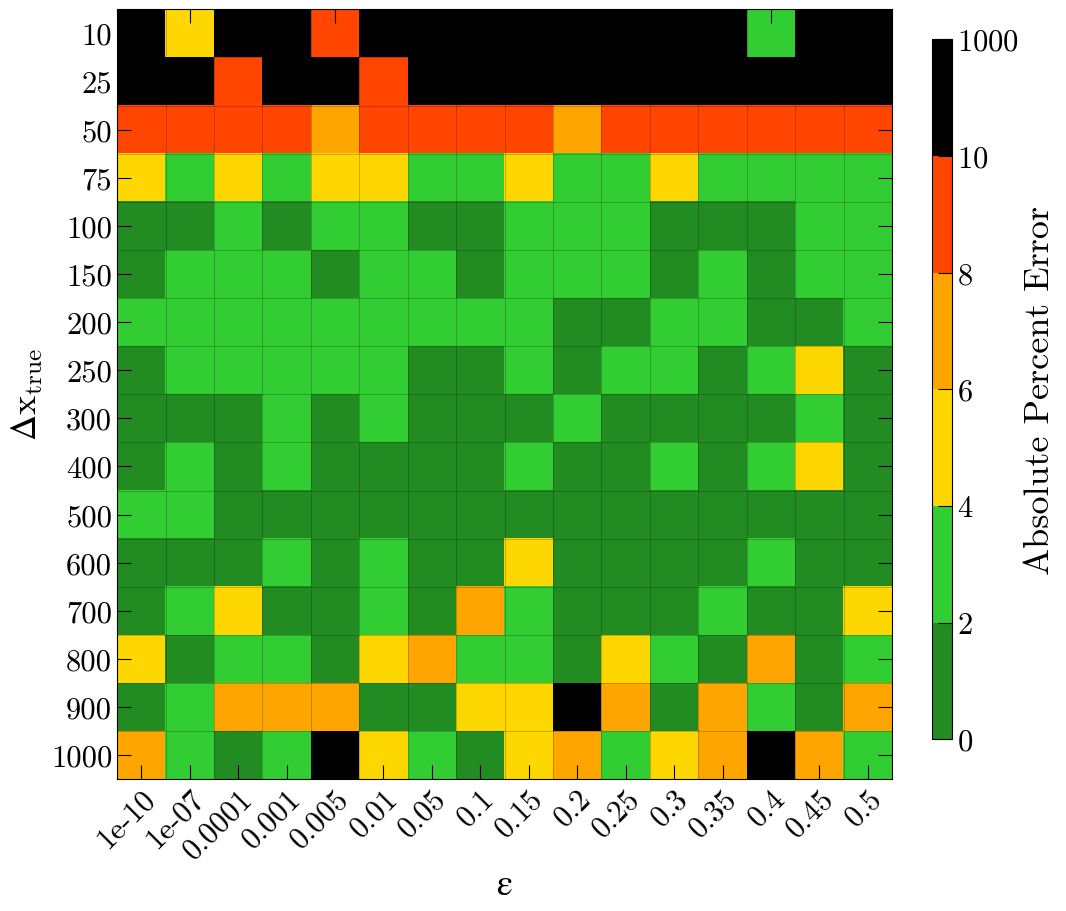

Number of squares with abs percent err>10%,  30


In [62]:
#simple model, run for more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'), 
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=200, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/100
92/92 [==============================] - 1s 9ms/step - loss: 78174.0469
Epoch 2/100
92/92 [==============================] - 1s 8ms/step - loss: 2385.5637
Epoch 3/100
92/92 [==============================] - 1s 7ms/step - loss: 1086.6987
Epoch 4/100
92/92 [==============================] - 1s 8ms/step - loss: 676.4451
Epoch 5/100
92/92 [==============================] - 1s 9ms/step - loss: 482.8696
Epoch 6/100
92/92 [==============================] - 1s 8ms/step - loss: 384.2980
Epoch 7/100
92/92 [==============================] - 1s 10ms/step - loss: 270.0163
Epoch 8/100
92/92 [==============================] - 1s 9ms/step - loss: 264.9450
Epoch 9/100
92/92 [==============================] - 1s 8ms/step - loss: 270.3604
Epoch 10/100
92/92 [==============================] - 1s 8ms/step - loss: 229.2791
Epoch 11/100
92/92 [==============================] - 1s 9ms/step - loss: 231.4010
Epoch 12/100
92/92 [==============================] - 1s 8ms/step - loss: 354.3922
Epoch 13

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 14.693 pc
MAE: 5.755 pc
BIAS: -5.335 pc
MED FRAC ERR: 0.034 

Training Stats, Successful Fits
Frac Success Fit: 0.955 
RMSE: 14.078 pc
MAE: 5.884 pc
BIAS: -5.461 pc
MED FRAC ERR: 0.033 

Testing Stats
RMSE: 19.888 pc
MAE: 6.437 pc
BIAS: -4.885 pc
MED FRAC ERR: 0.036 

Testing Stats, Successful Fits
Frac Success Fit: 0.918 
RMSE: 19.552 pc
MAE: 6.758 pc
BIAS: -5.335 pc
MED FRAC ERR: 0.035 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      5.754927               0.955495     6.436607              0.917969

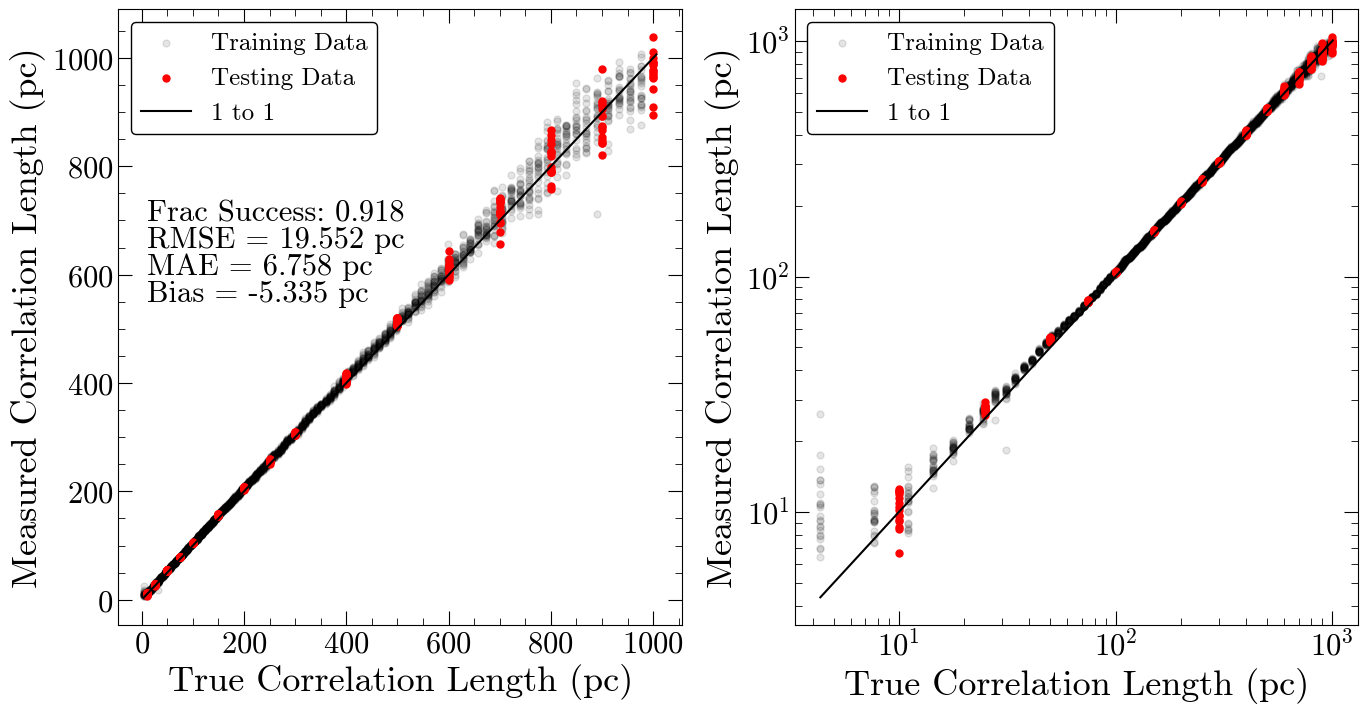

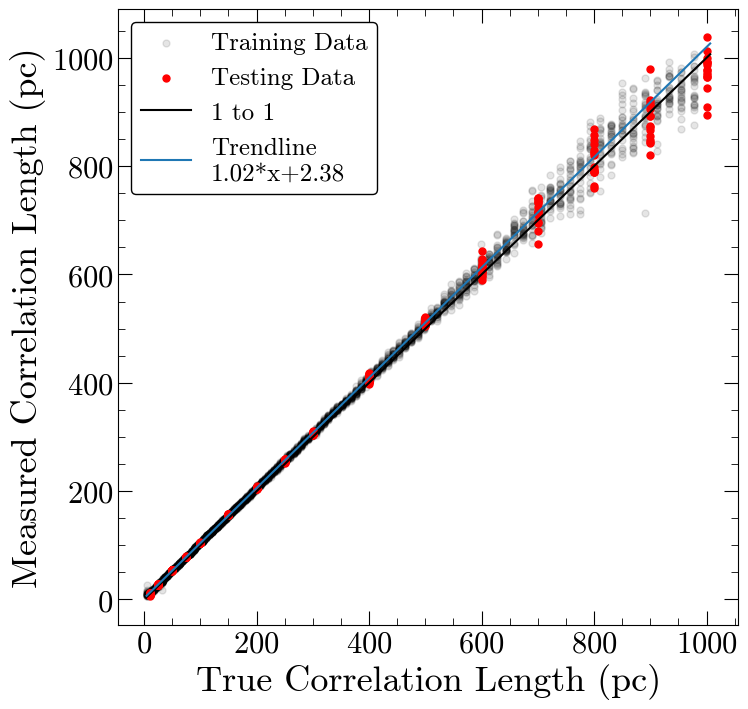

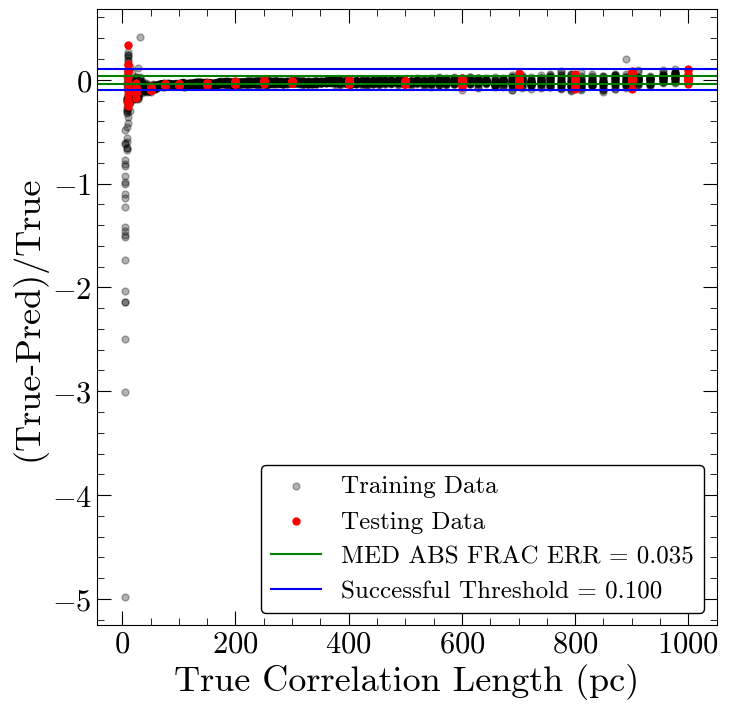

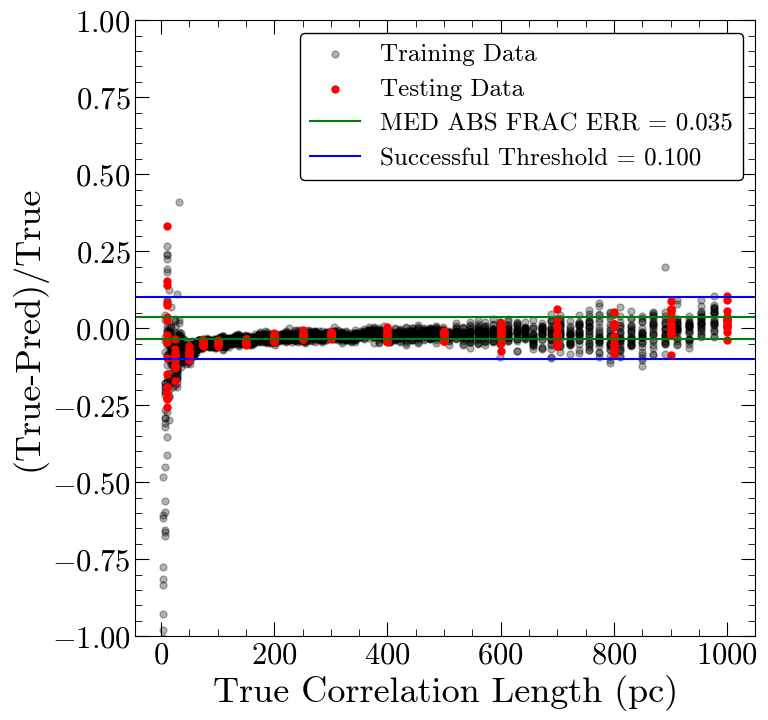

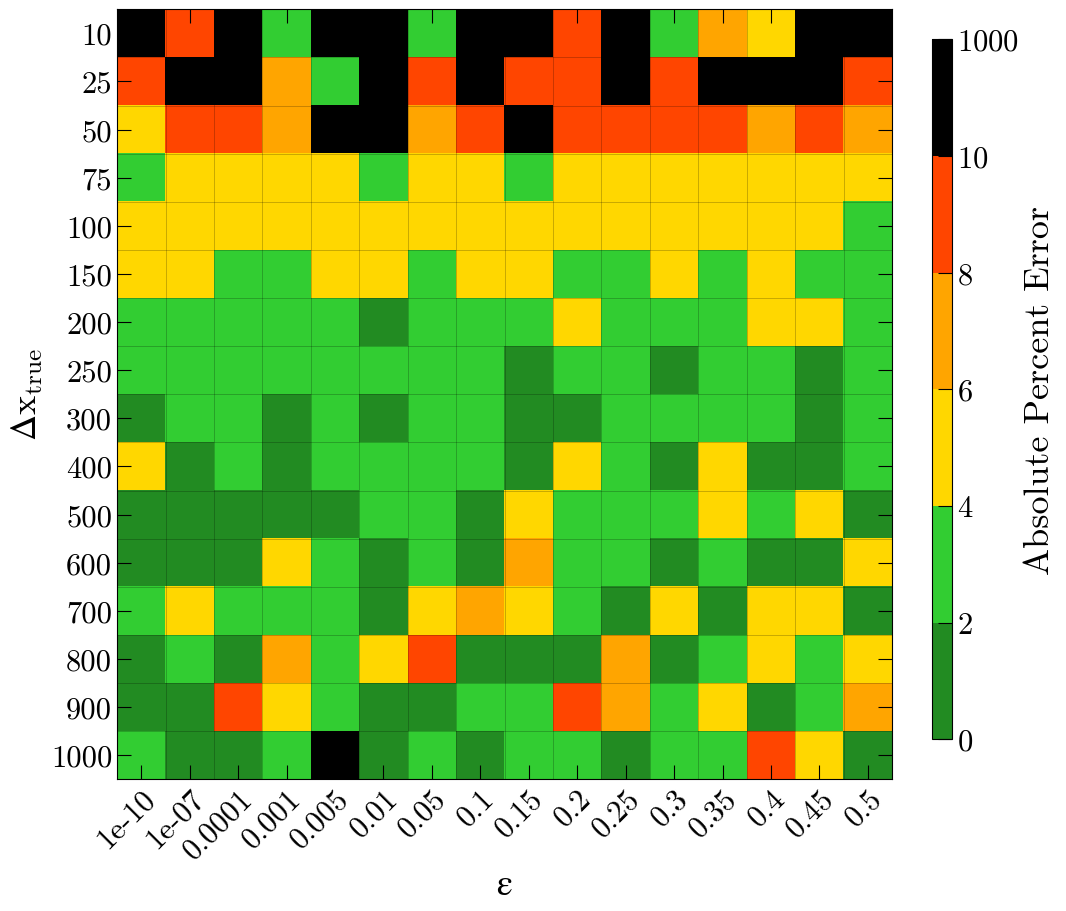

Number of squares with abs percent err>10%,  21


In [64]:
#model with more layers
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/200
92/92 [==============================] - 1s 11ms/step - loss: 73338.3047
Epoch 2/200
92/92 [==============================] - 1s 9ms/step - loss: 2140.2236
Epoch 3/200
92/92 [==============================] - 1s 9ms/step - loss: 1057.1992
Epoch 4/200
92/92 [==============================] - 1s 11ms/step - loss: 722.0020
Epoch 5/200
92/92 [==============================] - 1s 10ms/step - loss: 488.6488
Epoch 6/200
92/92 [==============================] - 1s 14ms/step - loss: 372.5967
Epoch 7/200
92/92 [==============================] - 1s 11ms/step - loss: 318.7264
Epoch 8/200
92/92 [==============================] - 1s 11ms/step - loss: 287.1424
Epoch 9/200
92/92 [==============================] - 1s 13ms/step - loss: 250.5134
Epoch 10/200
92/92 [==============================] - 1s 10ms/step - loss: 253.9633
Epoch 11/200
92/92 [==============================] - 1s 12ms/step - loss: 258.3027
Epoch 12/200
92/92 [==============================] - 1s 12ms/step - loss: 241.7061

92/92 [==============================] - 1s 10ms/step - loss: 194.7526
Epoch 100/200
92/92 [==============================] - 1s 9ms/step - loss: 213.8928
Epoch 101/200
92/92 [==============================] - 1s 11ms/step - loss: 211.2108
Epoch 102/200
92/92 [==============================] - 1s 10ms/step - loss: 187.2439
Epoch 103/200
92/92 [==============================] - 1s 10ms/step - loss: 223.4710
Epoch 104/200
92/92 [==============================] - 1s 9ms/step - loss: 277.8466
Epoch 105/200
92/92 [==============================] - 1s 9ms/step - loss: 199.0257
Epoch 106/200
92/92 [==============================] - 1s 9ms/step - loss: 206.0054
Epoch 107/200
92/92 [==============================] - 1s 9ms/step - loss: 199.3831
Epoch 108/200
92/92 [==============================] - 1s 10ms/step - loss: 199.9533
Epoch 109/200
92/92 [==============================] - 1s 10ms/step - loss: 209.4520
Epoch 110/200
92/92 [==============================] - 1s 9ms/step - loss: 194.9417


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 13.789 pc
MAE: 4.814 pc
BIAS: 4.468 pc
MED FRAC ERR: 0.027 

Training Stats, Successful Fits
Frac Success Fit: 0.947 
RMSE: 13.515 pc
MAE: 4.896 pc
BIAS: 4.536 pc
MED FRAC ERR: 0.027 

Testing Stats
RMSE: 24.758 pc
MAE: 4.672 pc
BIAS: 4.167 pc
MED FRAC ERR: 0.028 

Testing Stats, Successful Fits
Frac Success Fit: 0.922 
RMSE: 21.326 pc
MAE: 4.730 pc
BIAS: 4.207 pc
MED FRAC ERR: 0.026 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      4.814372               0.946594     4.671738              0.921875

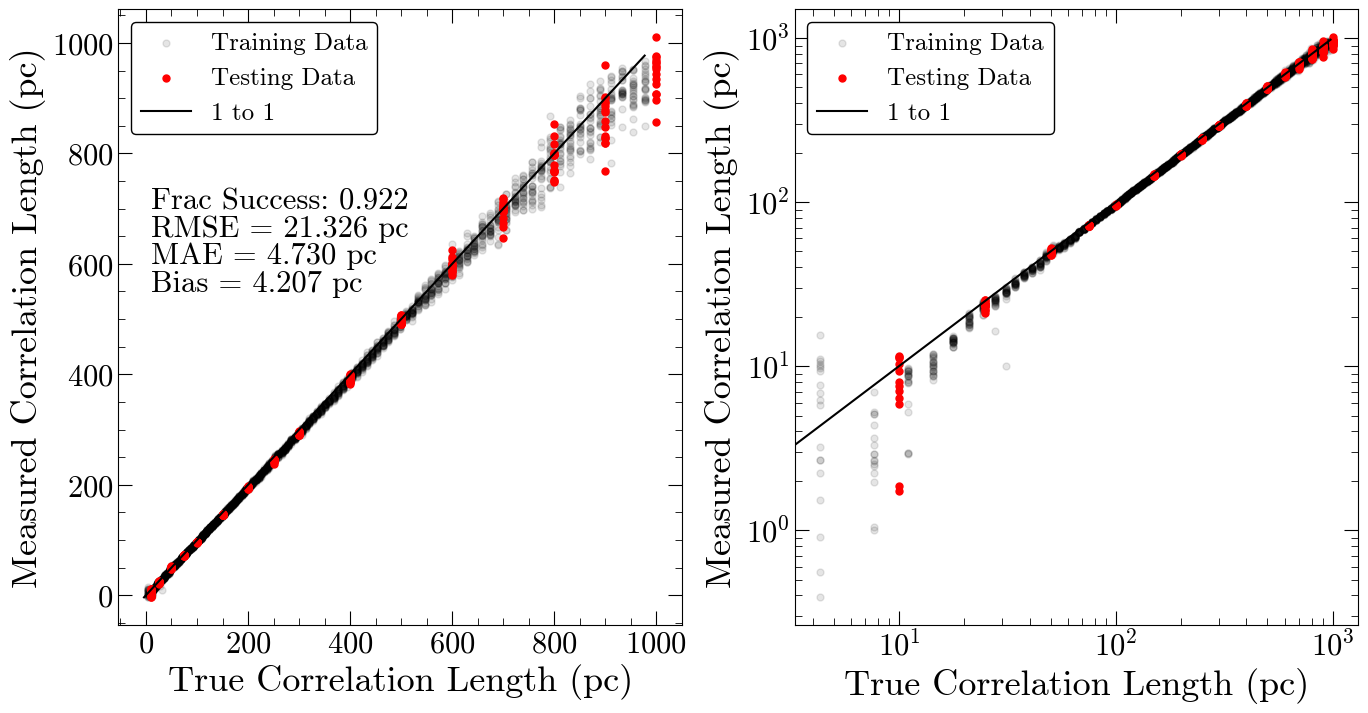

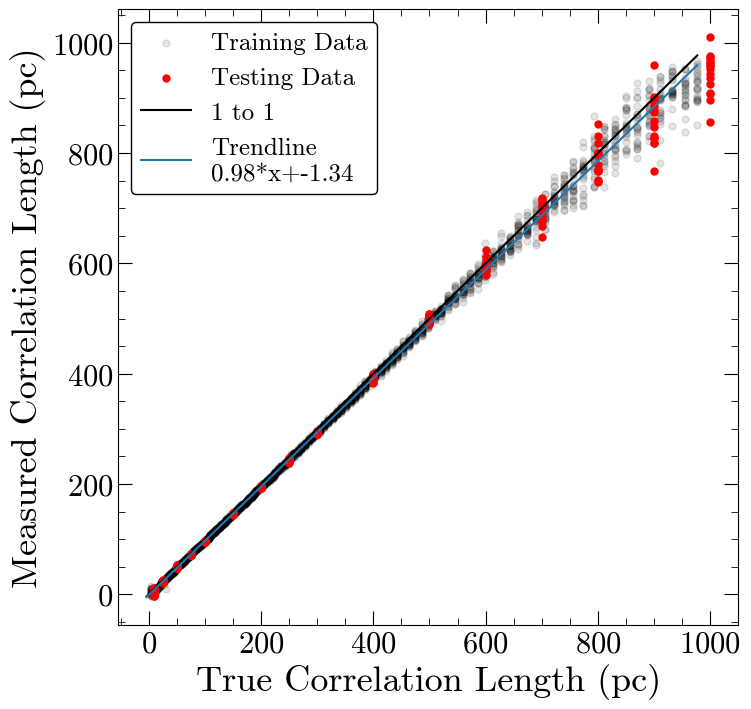

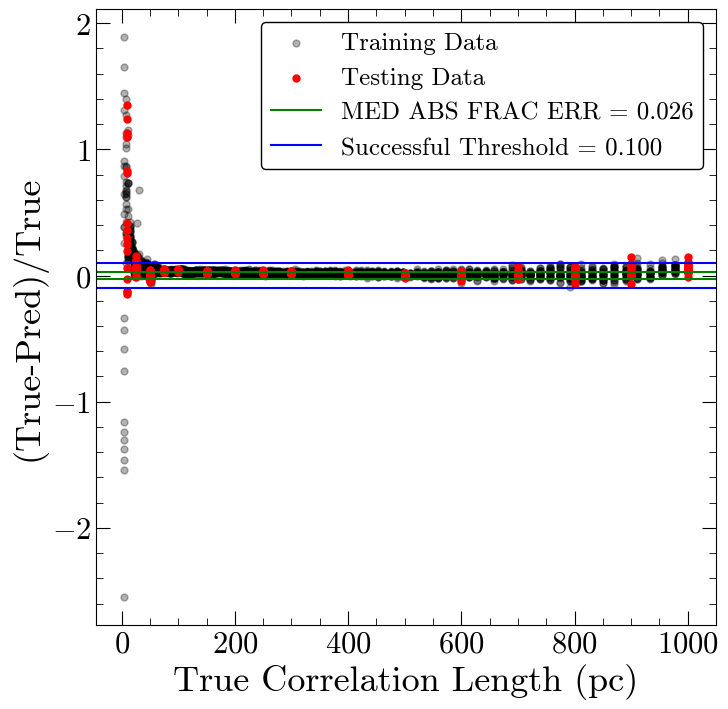

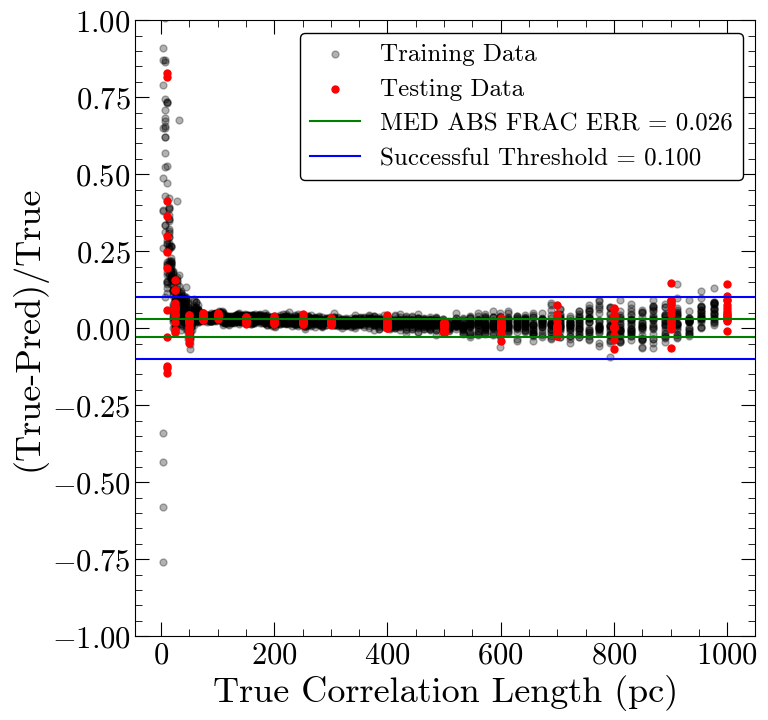

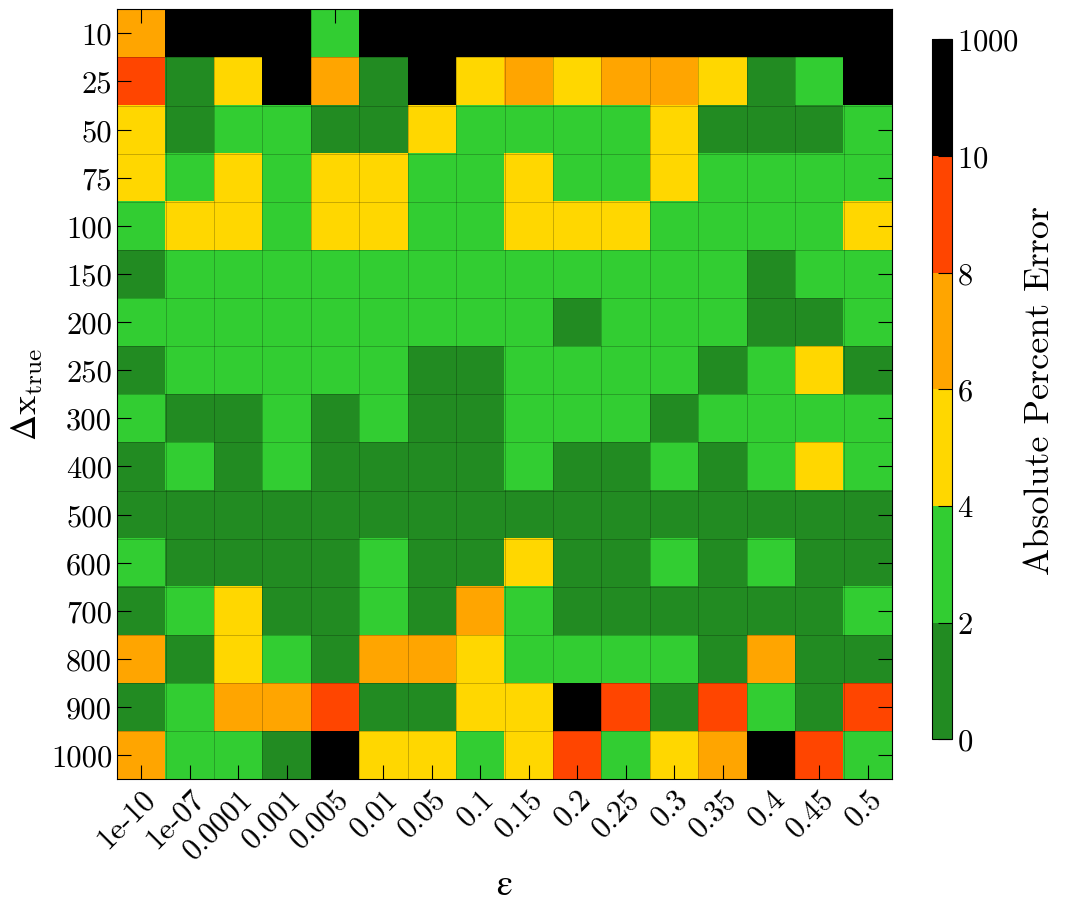

Number of squares with abs percent err>10%,  20


In [65]:
#model with more layers, run for more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=200, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/100
92/92 [==============================] - 2s 11ms/step - loss: 82825.2344
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 6119.4165
Epoch 3/100
92/92 [==============================] - 1s 8ms/step - loss: 1048.4192
Epoch 4/100
92/92 [==============================] - 1s 9ms/step - loss: 669.6669
Epoch 5/100
92/92 [==============================] - 1s 9ms/step - loss: 486.5078
Epoch 6/100
92/92 [==============================] - 1s 11ms/step - loss: 368.7569
Epoch 7/100
92/92 [==============================] - 1s 8ms/step - loss: 318.6311
Epoch 8/100
92/92 [==============================] - 1s 11ms/step - loss: 282.6107
Epoch 9/100
92/92 [==============================] - 1s 11ms/step - loss: 264.3546
Epoch 10/100
92/92 [==============================] - 1s 12ms/step - loss: 271.3793
Epoch 11/100
92/92 [==============================] - 1s 13ms/step - loss: 259.1211
Epoch 12/100
92/92 [==============================] - 1s 12ms/step - loss: 257.6680
E

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 14.355 pc
MAE: 2.818 pc
BIAS: -2.174 pc
MED FRAC ERR: 0.016 

Training Stats, Successful Fits
Frac Success Fit: 0.976 
RMSE: 13.388 pc
MAE: 2.835 pc
BIAS: -2.198 pc
MED FRAC ERR: 0.015 

Testing Stats
RMSE: 19.666 pc
MAE: 3.772 pc
BIAS: -1.200 pc
MED FRAC ERR: 0.017 

Testing Stats, Successful Fits
Frac Success Fit: 0.969 
RMSE: 19.979 pc
MAE: 3.903 pc
BIAS: -1.235 pc
MED FRAC ERR: 0.017 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      2.818349               0.976378     3.772324               0.96875

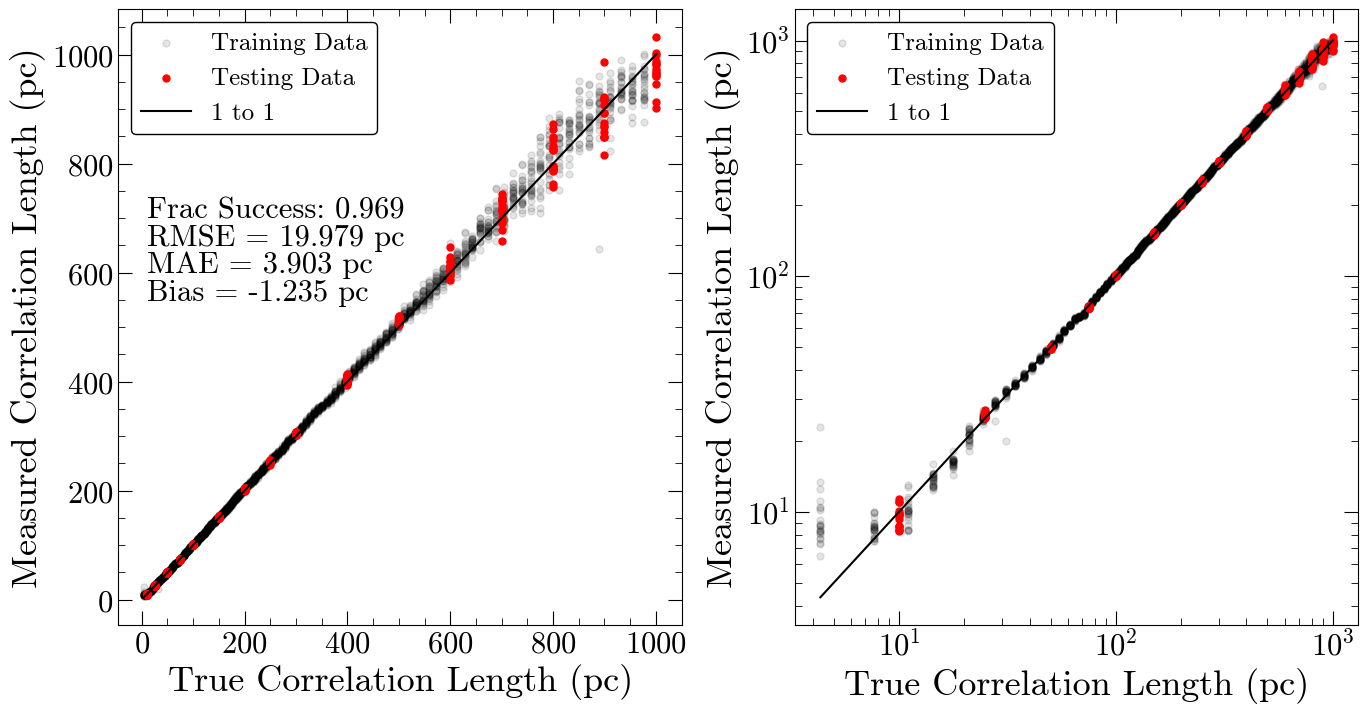

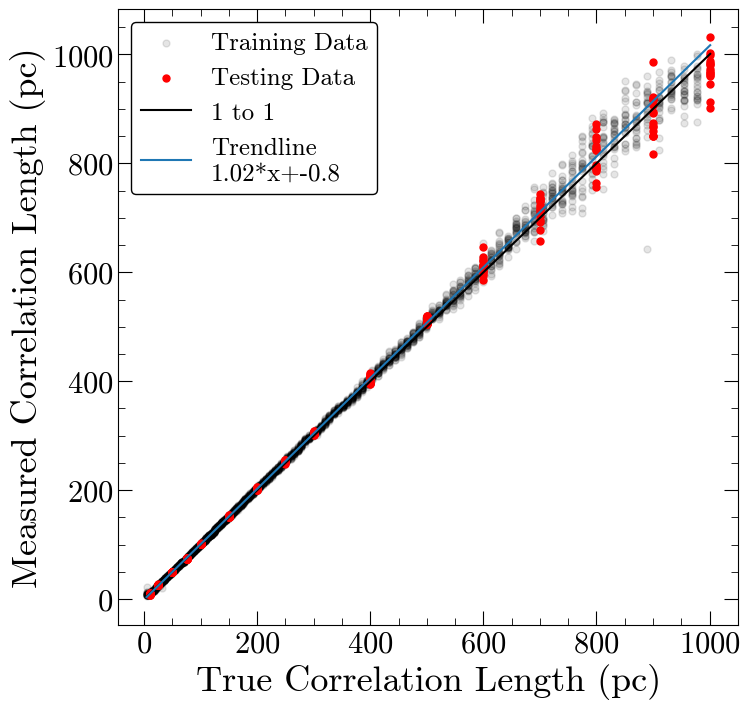

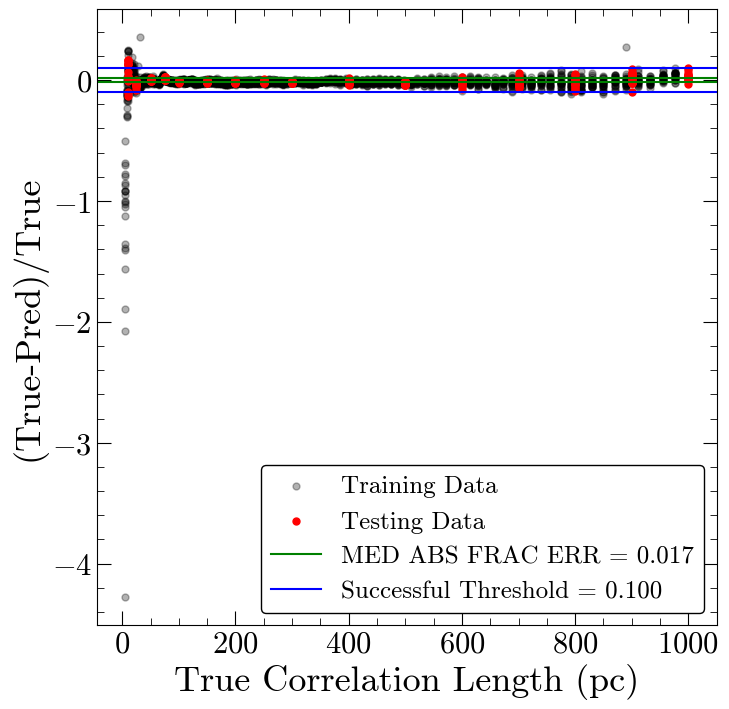

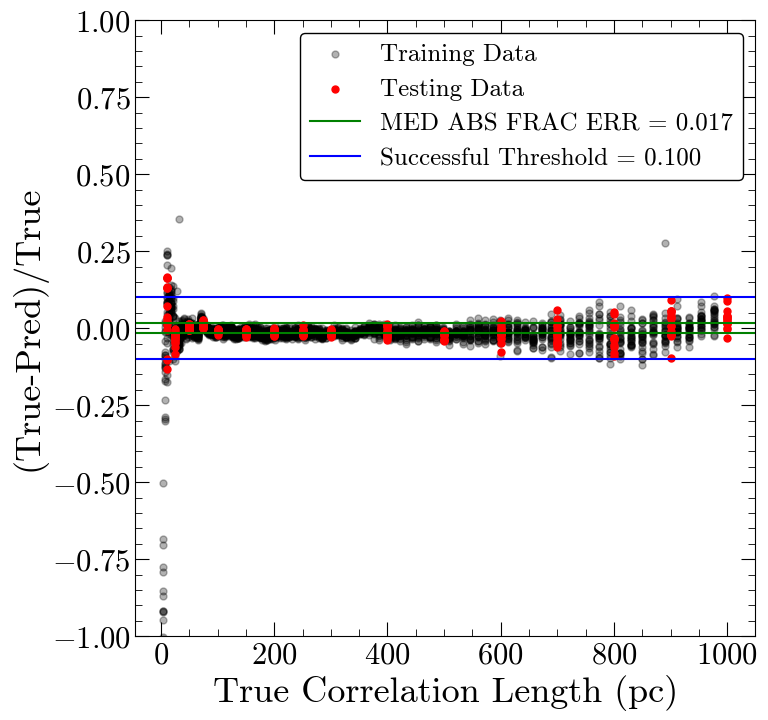

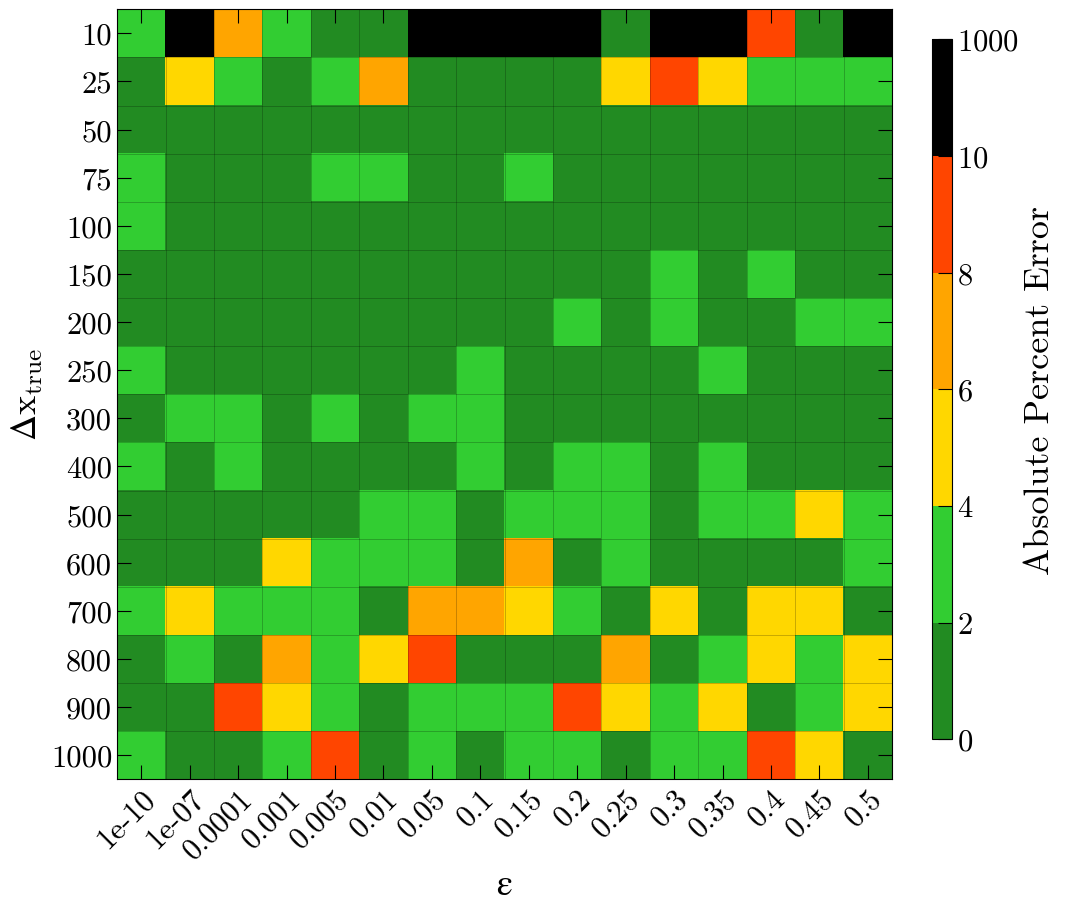

Number of squares with abs percent err>10%,  8


In [66]:
#model with more layers, increase max pooling in first layer
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(3), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/100
92/92 [==============================] - 2s 10ms/step - loss: 76731.4453
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 4332.4355
Epoch 3/100
92/92 [==============================] - 1s 10ms/step - loss: 927.8407
Epoch 4/100
92/92 [==============================] - 1s 10ms/step - loss: 676.7871
Epoch 5/100
92/92 [==============================] - 1s 9ms/step - loss: 512.1848
Epoch 6/100
92/92 [==============================] - 1s 9ms/step - loss: 370.8714
Epoch 7/100
92/92 [==============================] - 1s 9ms/step - loss: 309.6333
Epoch 8/100
92/92 [==============================] - 1s 9ms/step - loss: 299.7650
Epoch 9/100
92/92 [==============================] - 1s 9ms/step - loss: 252.3042
Epoch 10/100
92/92 [==============================] - 1s 11ms/step - loss: 255.6665
Epoch 11/100
92/92 [==============================] - 1s 11ms/step - loss: 250.8943
Epoch 12/100
92/92 [==============================] - 1s 9ms/step - loss: 264.1064
Epoc

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 14.673 pc
MAE: 3.654 pc
BIAS: -3.138 pc
MED FRAC ERR: 0.022 

Training Stats, Successful Fits
Frac Success Fit: 0.967 
RMSE: 13.588 pc
MAE: 3.697 pc
BIAS: -3.159 pc
MED FRAC ERR: 0.022 

Testing Stats
RMSE: 19.617 pc
MAE: 4.598 pc
BIAS: -3.099 pc
MED FRAC ERR: 0.026 

Testing Stats, Successful Fits
Frac Success Fit: 0.926 
RMSE: 19.513 pc
MAE: 4.838 pc
BIAS: -3.215 pc
MED FRAC ERR: 0.024 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      3.653801               0.967477     4.597893              0.925781

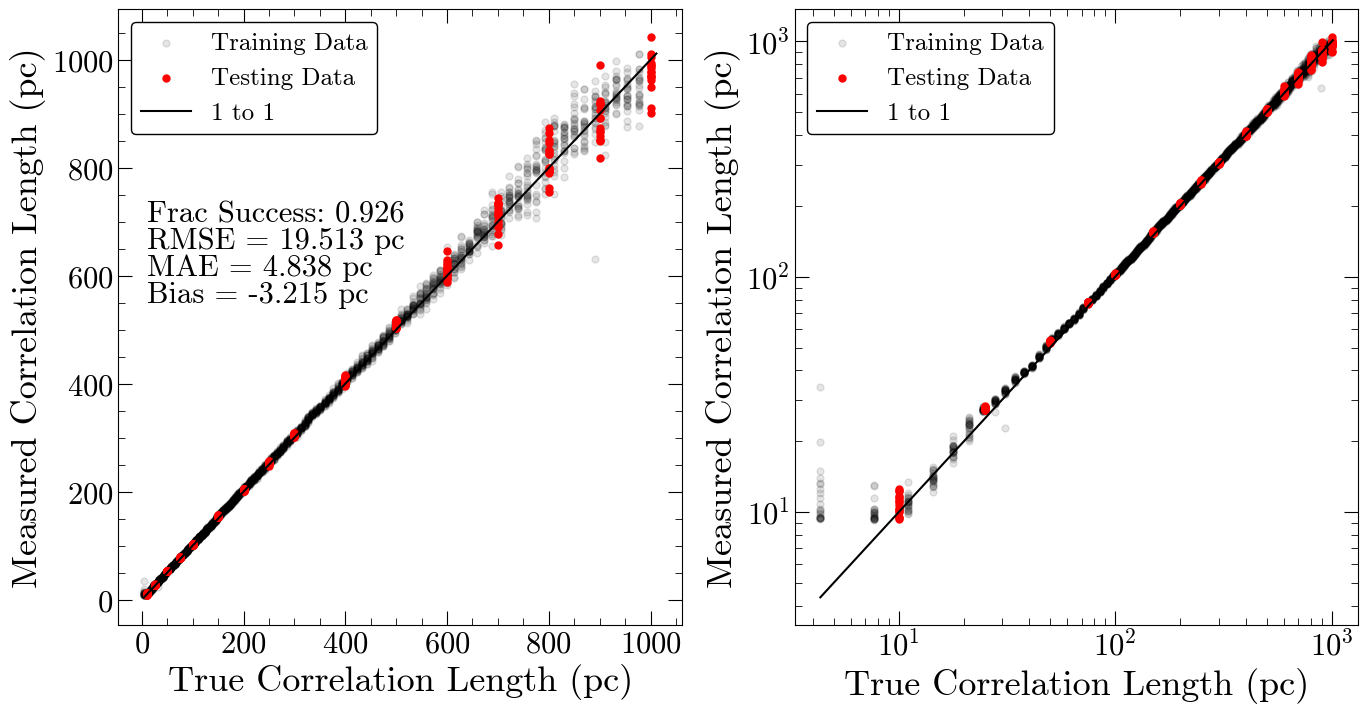

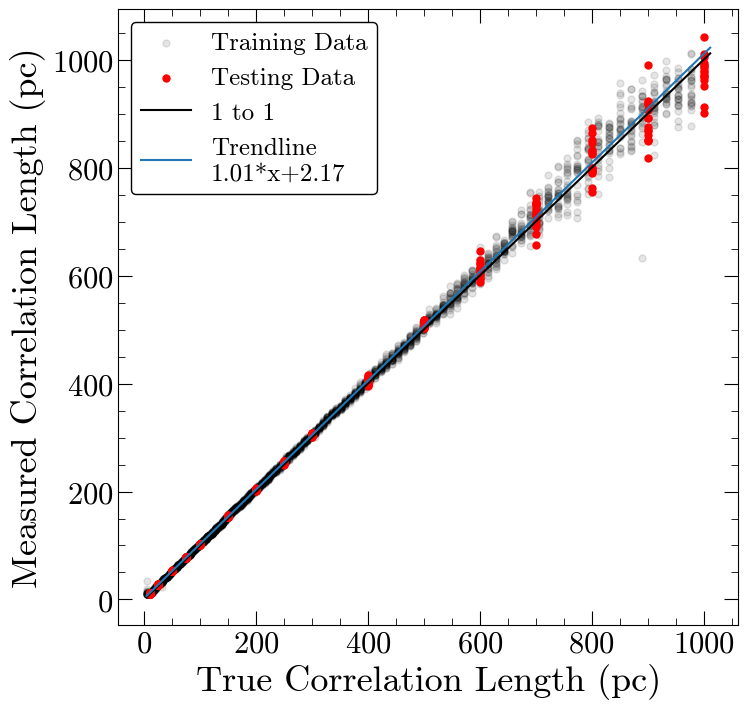

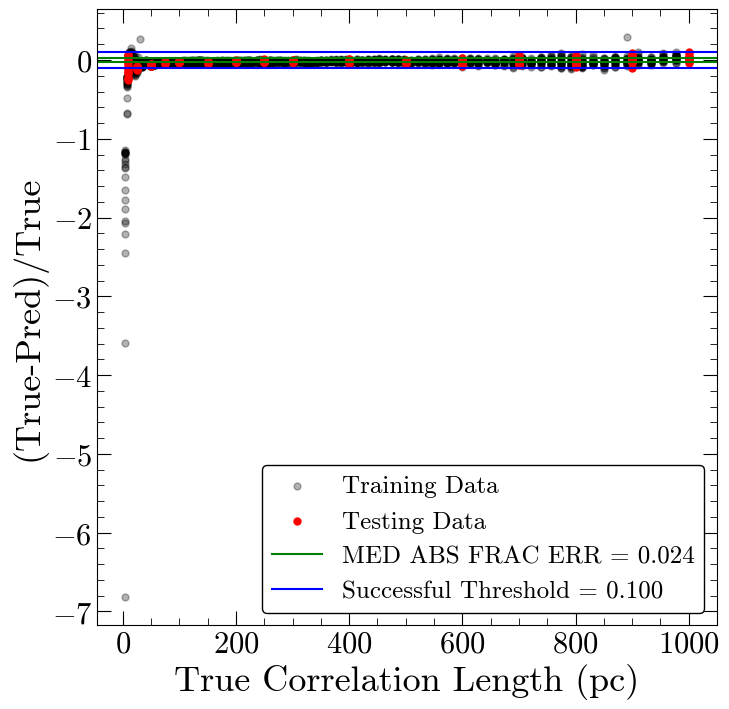

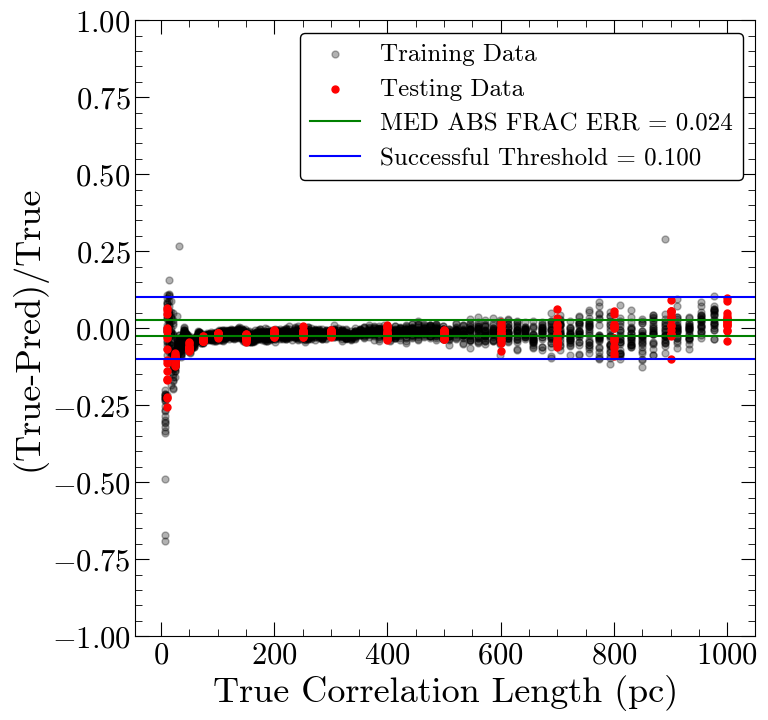

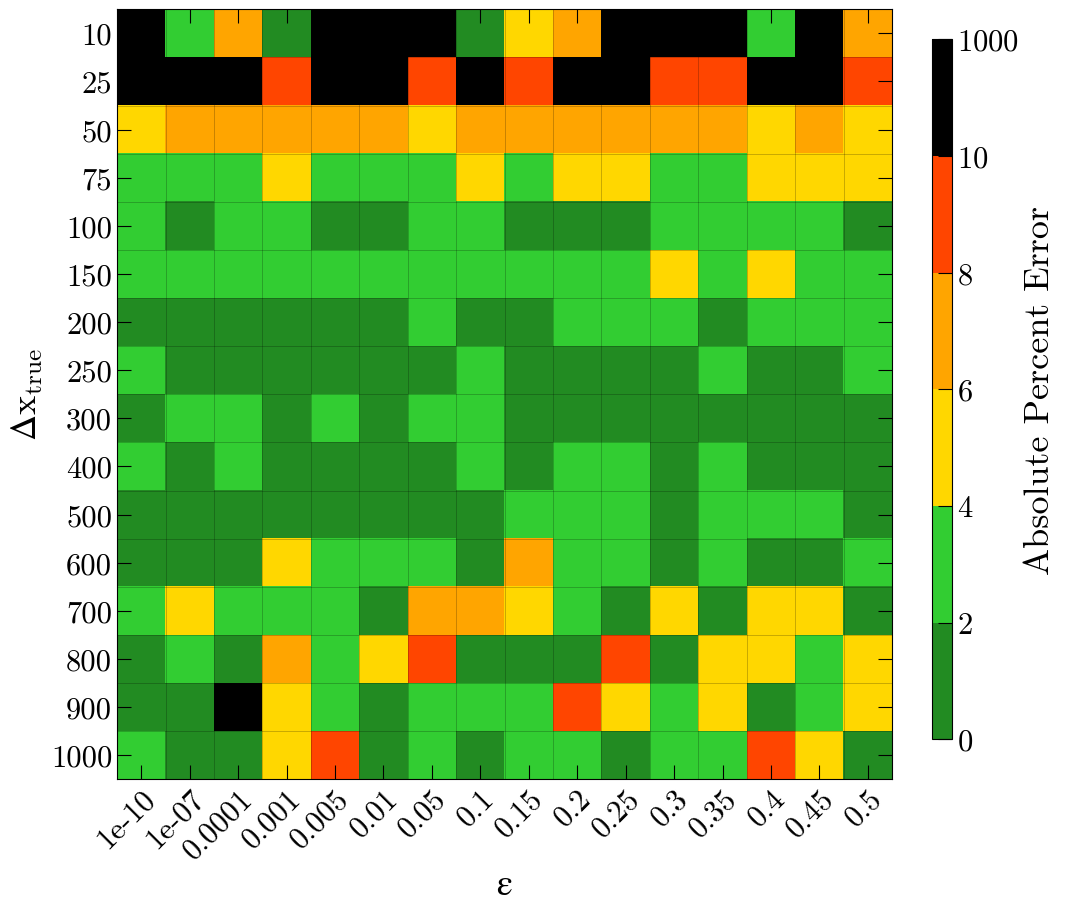

Number of squares with abs percent err>10%,  19


In [67]:
#model with more layers, increase max pooling and kernel size in first layer
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(3), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/200
92/92 [==============================] - 2s 10ms/step - loss: 75781.8125
Epoch 2/200
92/92 [==============================] - 1s 10ms/step - loss: 2905.1653
Epoch 3/200
92/92 [==============================] - 1s 9ms/step - loss: 984.3437
Epoch 4/200
92/92 [==============================] - 1s 8ms/step - loss: 695.7976
Epoch 5/200
92/92 [==============================] - 1s 10ms/step - loss: 492.1633
Epoch 6/200
92/92 [==============================] - 1s 8ms/step - loss: 403.9027
Epoch 7/200
92/92 [==============================] - 1s 9ms/step - loss: 338.6856
Epoch 8/200
92/92 [==============================] - 1s 9ms/step - loss: 337.1079
Epoch 9/200
92/92 [==============================] - 1s 8ms/step - loss: 292.6609
Epoch 10/200
92/92 [==============================] - 1s 10ms/step - loss: 304.1997
Epoch 11/200
92/92 [==============================] - 1s 9ms/step - loss: 304.0663
Epoch 12/200
92/92 [==============================] - 1s 9ms/step - loss: 304.8497
Epoch 

92/92 [==============================] - 1s 10ms/step - loss: 231.8663
Epoch 197/200
92/92 [==============================] - 1s 10ms/step - loss: 229.6478
Epoch 198/200
92/92 [==============================] - 1s 14ms/step - loss: 199.7055
Epoch 199/200
92/92 [==============================] - 1s 14ms/step - loss: 223.9600
Epoch 200/200
92/92 [==============================] - 1s 14ms/step - loss: 189.2119

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 13.312 pc
MAE: 1.575 pc
BIAS: -0.503 pc
MED FRAC ERR: 0.010 

Training Stats, Successful Fits
Frac Success Fit: 0.978 
RMSE: 12.453 pc
MAE: 1.535 pc
BIAS: -0.505 pc
MED FRAC ERR: 0.009 

Testing Stats
RMSE: 19.599 pc
MAE: 1.907 pc
BIAS: -0.243 pc
MED FRAC ERR: 0.011 

Testing Stats, Successful Fits
Frac Success Fit: 0.965 
RMSE: 18.805 pc
MAE: 1.796 pc
BIAS: -0.317 pc
MED FRAC ERR: 0.010 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      1.574517               0.977747     1.906925              0.964844

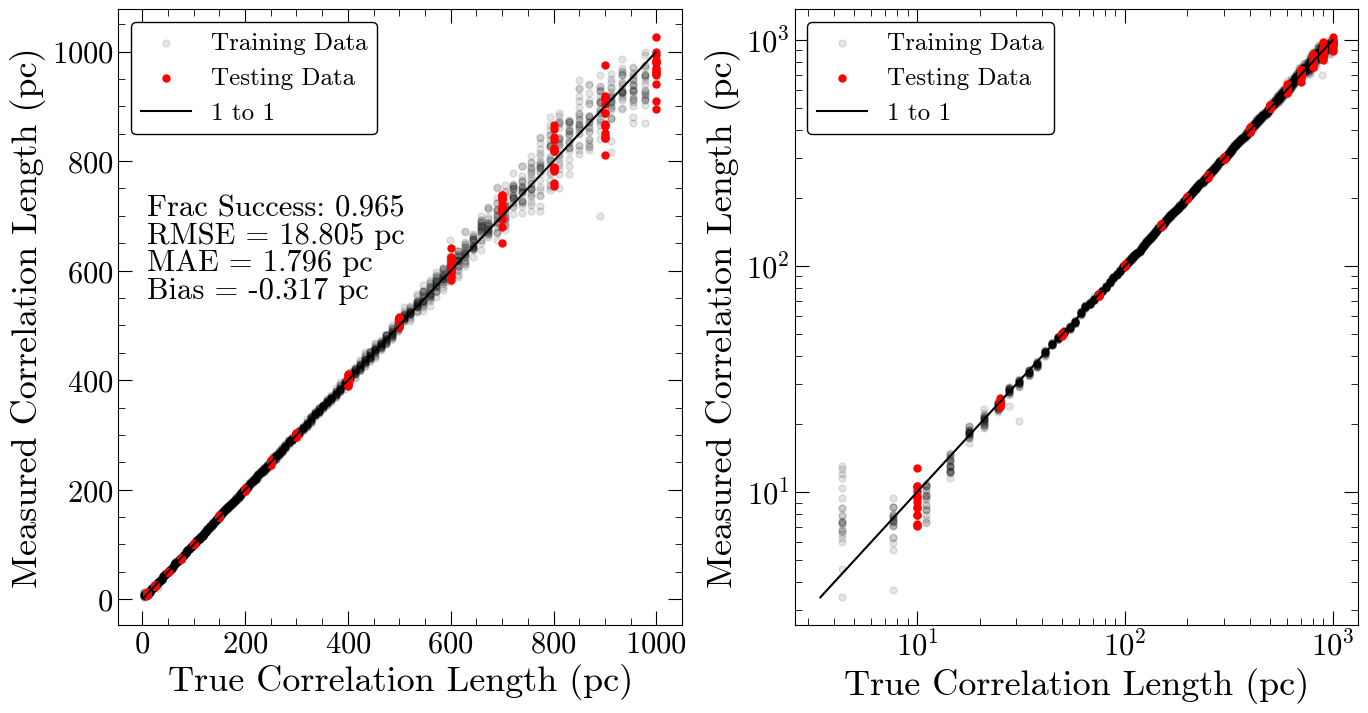

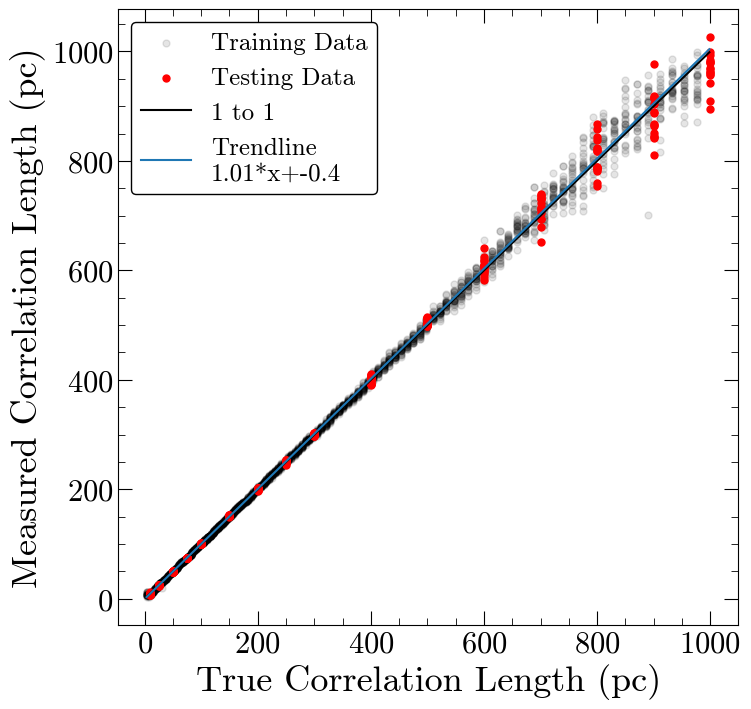

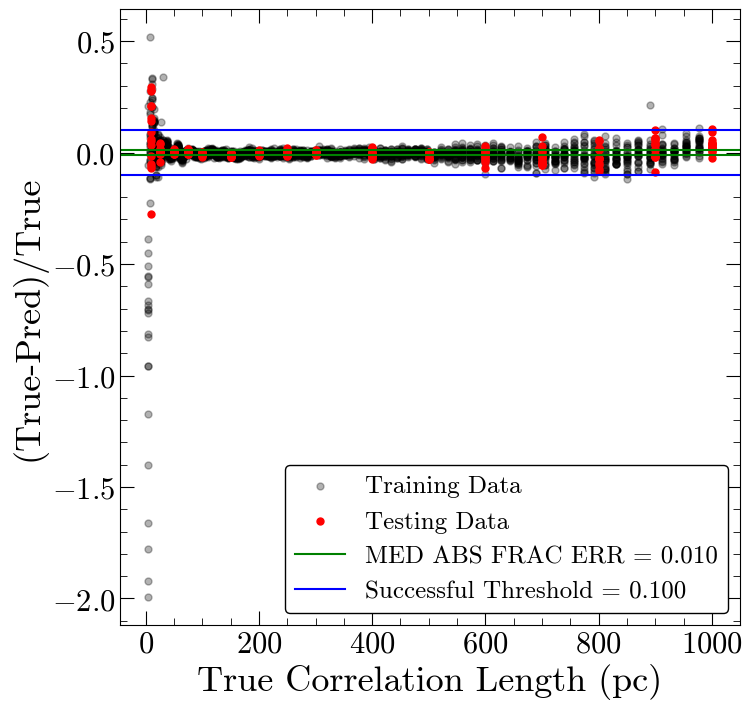

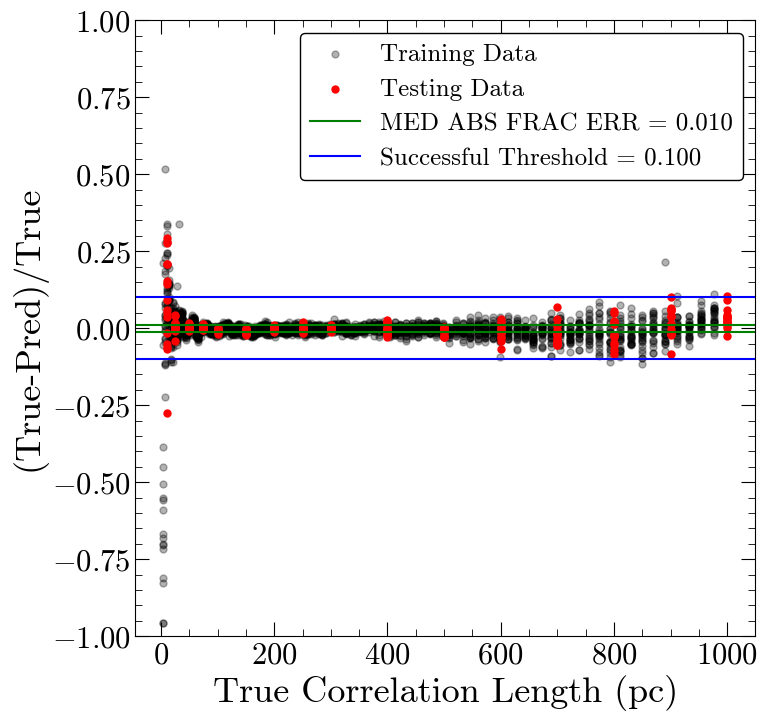

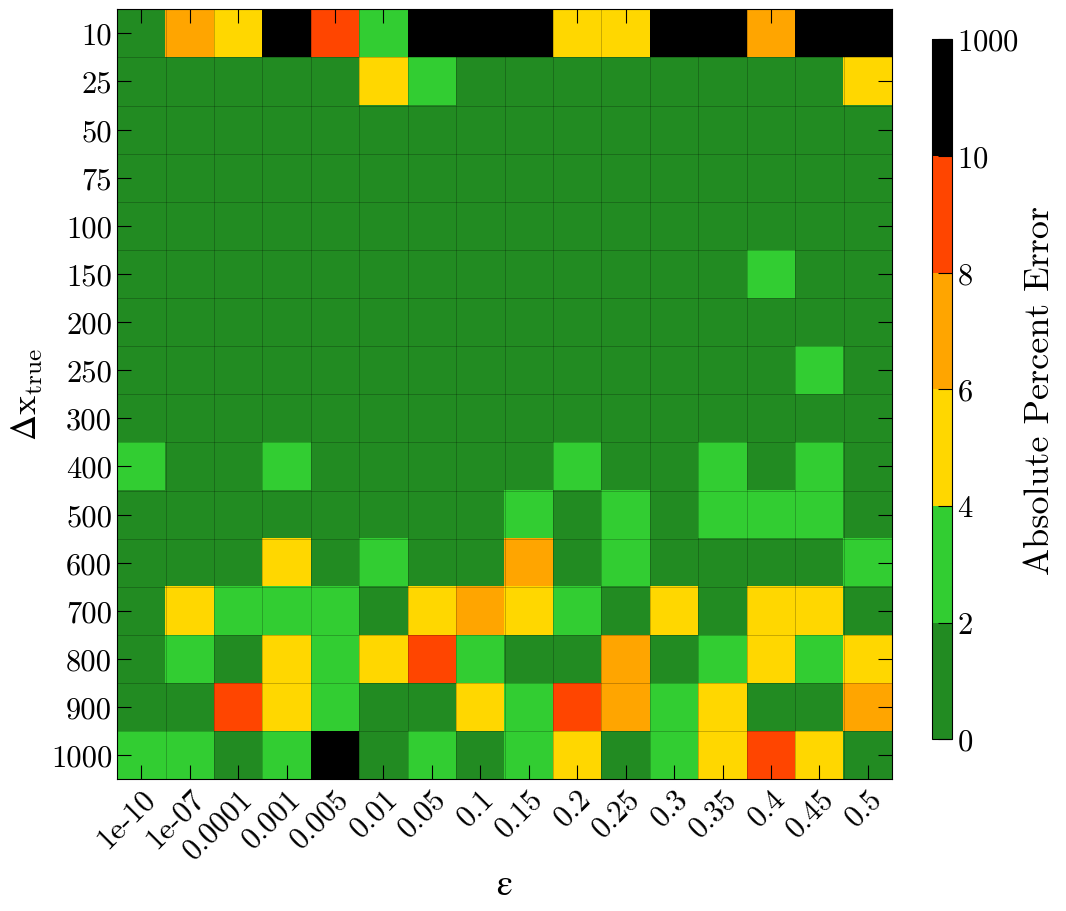

Number of squares with abs percent err>10%,  9


In [68]:
#model with more layers, run for more epochs, increase max pooling and kernel size in first layer
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(3), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=200, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
92/92 [==============================] - 3s 12ms/step - loss: 69358.4688
Epoch 2/400
92/92 [==============================] - 1s 11ms/step - loss: 2104.4561
Epoch 3/400
92/92 [==============================] - 1s 9ms/step - loss: 900.5264
Epoch 4/400
92/92 [==============================] - 1s 12ms/step - loss: 558.9310
Epoch 5/400
92/92 [==============================] - 1s 10ms/step - loss: 343.9460
Epoch 6/400
92/92 [==============================] - 1s 10ms/step - loss: 291.3264
Epoch 7/400
92/92 [==============================] - 1s 10ms/step - loss: 241.2863
Epoch 8/400
92/92 [==============================] - 1s 11ms/step - loss: 234.1640
Epoch 9/400
92/92 [==============================] - 1s 10ms/step - loss: 240.6653
Epoch 10/400
92/92 [==============================] - 1s 10ms/step - loss: 224.7554
Epoch 11/400
92/92 [==============================] - 1s 10ms/step - loss: 243.5597
Epoch 12/400
92/92 [==============================] - 1s 10ms/step - loss: 248.3621

92/92 [==============================] - 1s 10ms/step - loss: 177.4548
Epoch 195/400
92/92 [==============================] - 1s 10ms/step - loss: 185.8369
Epoch 196/400
92/92 [==============================] - 1s 10ms/step - loss: 195.2358
Epoch 197/400
92/92 [==============================] - 1s 9ms/step - loss: 177.4221
Epoch 198/400
92/92 [==============================] - 1s 10ms/step - loss: 181.3055
Epoch 199/400
92/92 [==============================] - 1s 9ms/step - loss: 182.2020
Epoch 200/400
92/92 [==============================] - 1s 10ms/step - loss: 212.6644
Epoch 201/400
92/92 [==============================] - 1s 10ms/step - loss: 189.3747
Epoch 202/400
92/92 [==============================] - 1s 9ms/step - loss: 182.9996
Epoch 203/400
92/92 [==============================] - 1s 10ms/step - loss: 189.5699
Epoch 204/400
92/92 [==============================] - 1s 10ms/step - loss: 195.4216
Epoch 205/400
92/92 [==============================] - 1s 11ms/step - loss: 184.92

92/92 [==============================] - 1s 13ms/step - loss: 147.4607
Epoch 387/400
92/92 [==============================] - 1s 15ms/step - loss: 151.4069
Epoch 388/400
92/92 [==============================] - 1s 12ms/step - loss: 169.0056
Epoch 389/400
92/92 [==============================] - 1s 13ms/step - loss: 179.6176
Epoch 390/400
92/92 [==============================] - 1s 13ms/step - loss: 172.1089
Epoch 391/400
92/92 [==============================] - 1s 12ms/step - loss: 150.5436
Epoch 392/400
92/92 [==============================] - 1s 14ms/step - loss: 162.7547
Epoch 393/400
92/92 [==============================] - 1s 13ms/step - loss: 164.5538
Epoch 394/400
92/92 [==============================] - 1s 13ms/step - loss: 148.8740
Epoch 395/400
92/92 [==============================] - 1s 14ms/step - loss: 163.3362
Epoch 396/400
92/92 [==============================] - 1s 12ms/step - loss: 173.4574
Epoch 397/400
92/92 [==============================] - 1s 13ms/step - loss: 153

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.843 pc
MAE: 2.126 pc
BIAS: -1.408 pc
MED FRAC ERR: 0.013 

Training Stats, Successful Fits
Frac Success Fit: 0.973 
RMSE: 11.751 pc
MAE: 2.133 pc
BIAS: -1.474 pc
MED FRAC ERR: 0.012 

Testing Stats
RMSE: 20.356 pc
MAE: 2.823 pc
BIAS: -1.119 pc
MED FRAC ERR: 0.016 

Testing Stats, Successful Fits
Frac Success Fit: 0.965 
RMSE: 17.725 pc
MAE: 2.700 pc
BIAS: -1.184 pc
MED FRAC ERR: 0.015 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      2.126254               0.972954     2.823128              0.964844

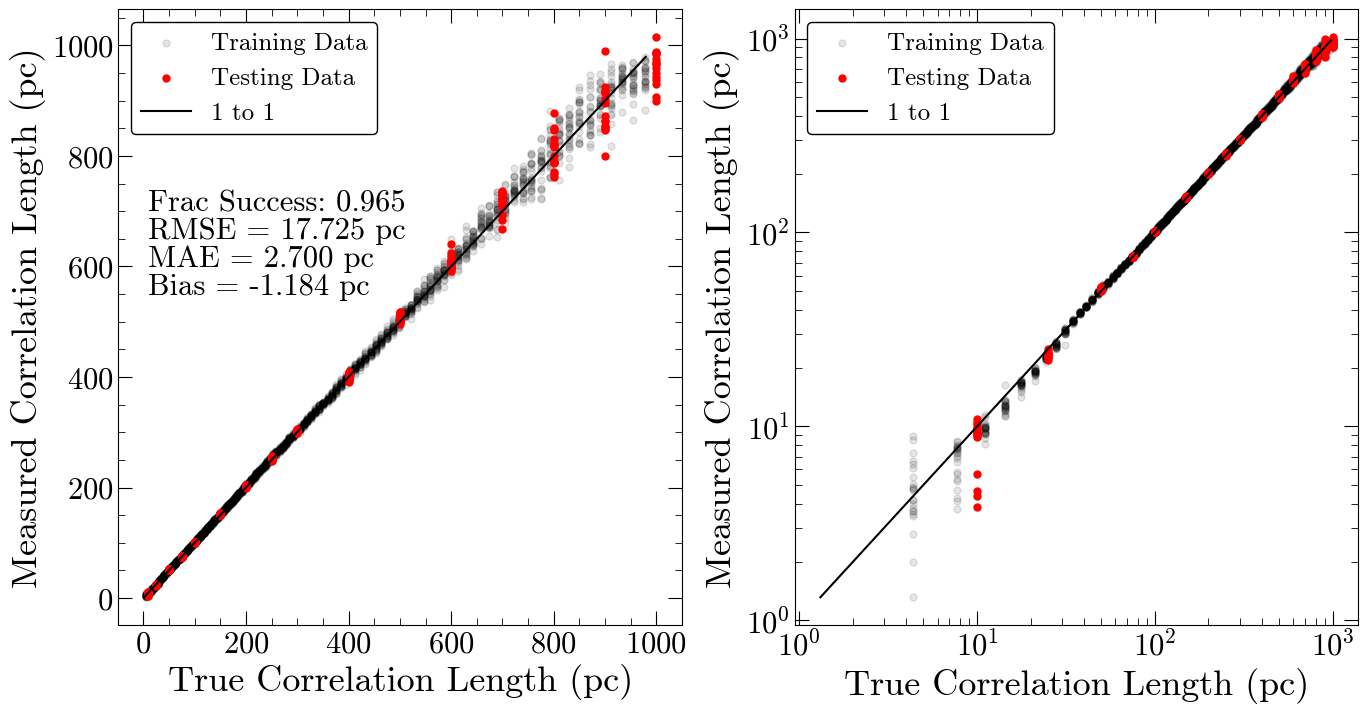

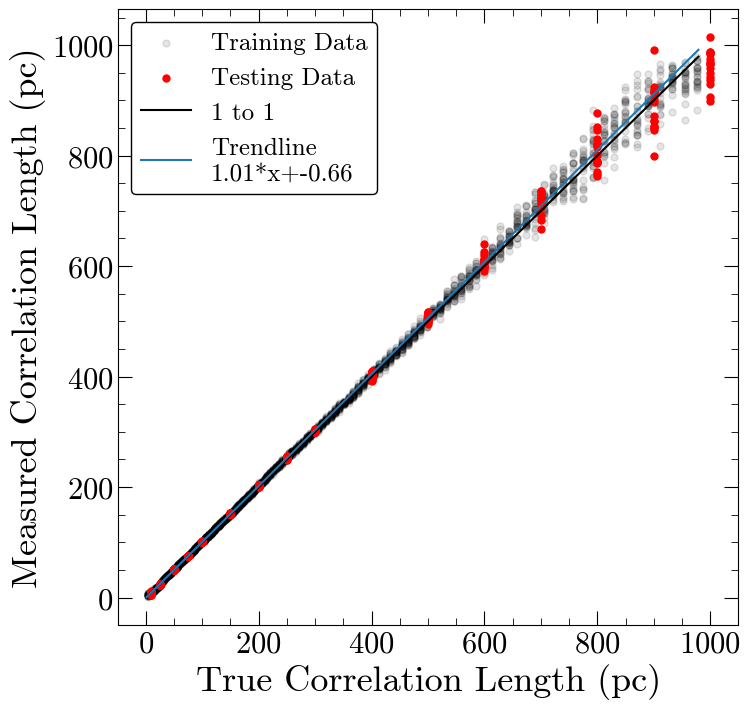

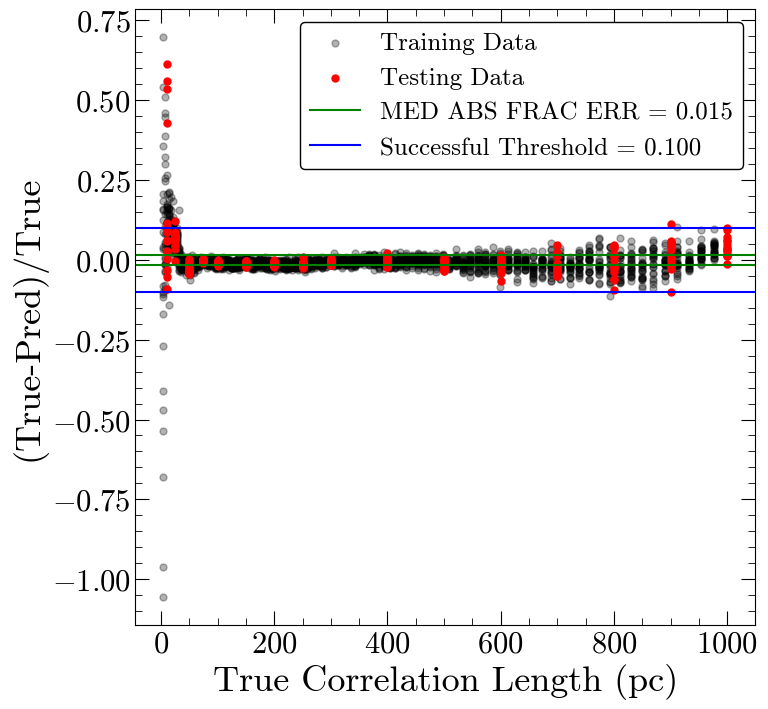

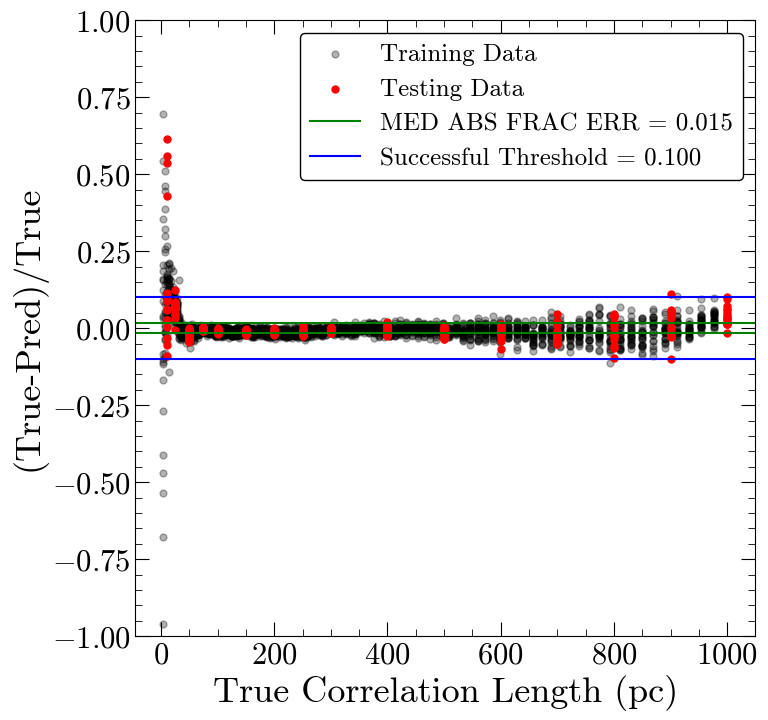

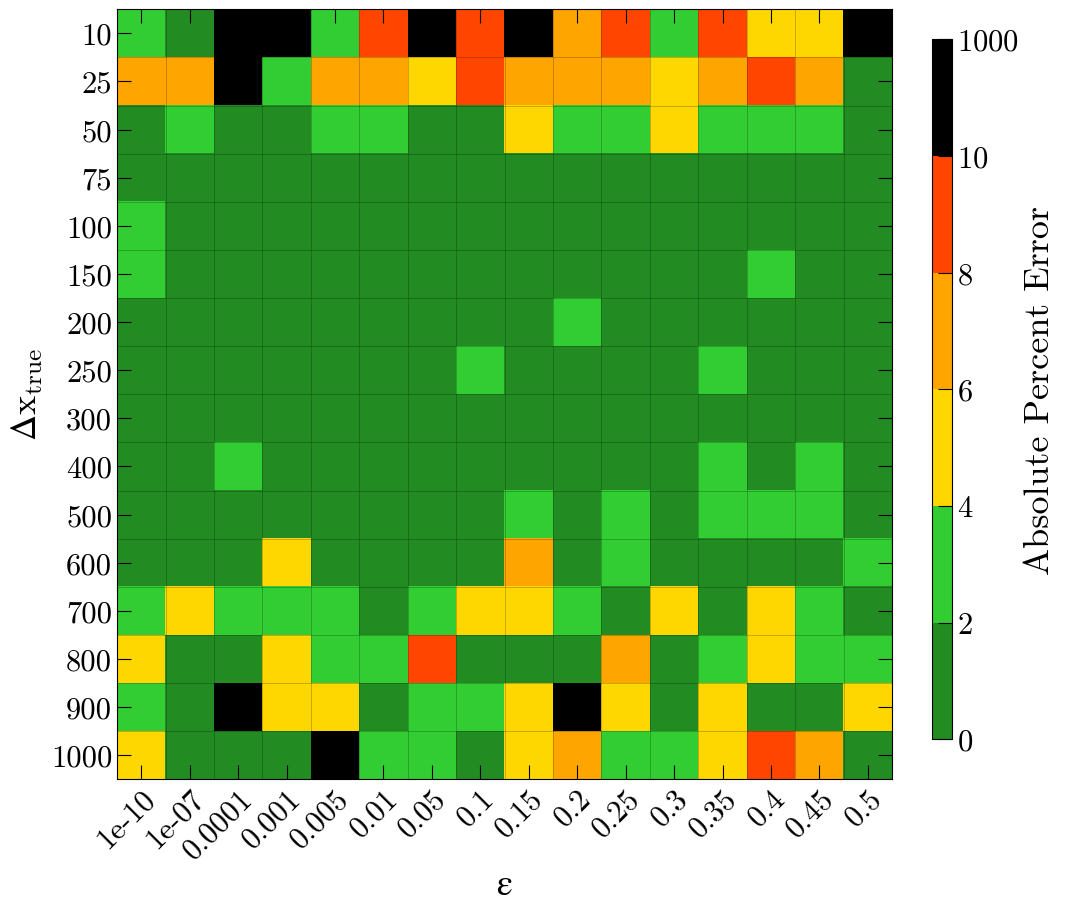

Number of squares with abs percent err>10%,  9


In [69]:
#model with more layers, run for even more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
92/92 [==============================] - 2s 14ms/step - loss: 63304.8789
Epoch 2/400
92/92 [==============================] - 1s 12ms/step - loss: 1316.0774
Epoch 3/400
92/92 [==============================] - 1s 14ms/step - loss: 590.7143
Epoch 4/400
92/92 [==============================] - 1s 14ms/step - loss: 360.9584
Epoch 5/400
92/92 [==============================] - 1s 14ms/step - loss: 282.8920
Epoch 6/400
92/92 [==============================] - 1s 14ms/step - loss: 256.7237
Epoch 7/400
92/92 [==============================] - 1s 14ms/step - loss: 241.0586
Epoch 8/400
92/92 [==============================] - 1s 12ms/step - loss: 235.7291
Epoch 9/400
92/92 [==============================] - 1s 13ms/step - loss: 231.0585
Epoch 10/400
92/92 [==============================] - 1s 14ms/step - loss: 257.2613
Epoch 11/400
92/92 [==============================] - 1s 13ms/step - loss: 241.1492
Epoch 12/400
92/92 [==============================] - 1s 14ms/step - loss: 246.427

92/92 [==============================] - 1s 6ms/step - loss: 188.4395
Epoch 196/400
92/92 [==============================] - 1s 6ms/step - loss: 200.8874
Epoch 197/400
92/92 [==============================] - 0s 5ms/step - loss: 252.6310
Epoch 198/400
92/92 [==============================] - 0s 5ms/step - loss: 174.8658
Epoch 199/400
92/92 [==============================] - 0s 5ms/step - loss: 220.8749
Epoch 200/400
92/92 [==============================] - 0s 5ms/step - loss: 171.8146
Epoch 201/400
92/92 [==============================] - 0s 5ms/step - loss: 162.9199
Epoch 202/400
92/92 [==============================] - 1s 6ms/step - loss: 184.5662
Epoch 203/400
92/92 [==============================] - 0s 5ms/step - loss: 187.7274
Epoch 204/400
92/92 [==============================] - 1s 6ms/step - loss: 173.2623
Epoch 205/400
92/92 [==============================] - 0s 5ms/step - loss: 209.3603
Epoch 206/400
92/92 [==============================] - 0s 5ms/step - loss: 206.2549
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 160.3246
Epoch 390/400
92/92 [==============================] - 0s 3ms/step - loss: 166.4266
Epoch 391/400
92/92 [==============================] - 0s 3ms/step - loss: 153.4616
Epoch 392/400
92/92 [==============================] - 0s 3ms/step - loss: 164.4321
Epoch 393/400
92/92 [==============================] - 0s 3ms/step - loss: 167.7908
Epoch 394/400
92/92 [==============================] - 0s 3ms/step - loss: 154.5918
Epoch 395/400
92/92 [==============================] - 0s 3ms/step - loss: 161.4111
Epoch 396/400
92/92 [==============================] - 0s 3ms/step - loss: 191.4410
Epoch 397/400
92/92 [==============================] - 0s 3ms/step - loss: 181.4853
Epoch 398/400
92/92 [==============================] - 0s 3ms/step - loss: 185.7231
Epoch 399/400
92/92 [==============================] - 0s 3ms/step - loss: 157.5789
Epoch 400/400
92/92 [==============================] - 0s 3ms/step - loss: 198.4474

Showi

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 12.584 pc
MAE: 2.227 pc
BIAS: 0.965 pc
MED FRAC ERR: 0.014 

Training Stats, Successful Fits
Frac Success Fit: 0.964 
RMSE: 12.212 pc
MAE: 2.217 pc
BIAS: 1.186 pc
MED FRAC ERR: 0.013 

Testing Stats
RMSE: 24.349 pc
MAE: 2.399 pc
BIAS: 0.860 pc
MED FRAC ERR: 0.016 

Testing Stats, Successful Fits
Frac Success Fit: 0.934 
RMSE: 21.092 pc
MAE: 2.369 pc
BIAS: 0.915 pc
MED FRAC ERR: 0.014 


mae_training  frac_success_training  mae_testing  frac_success_testing
0       2.22717               0.963711     2.399155              0.933594

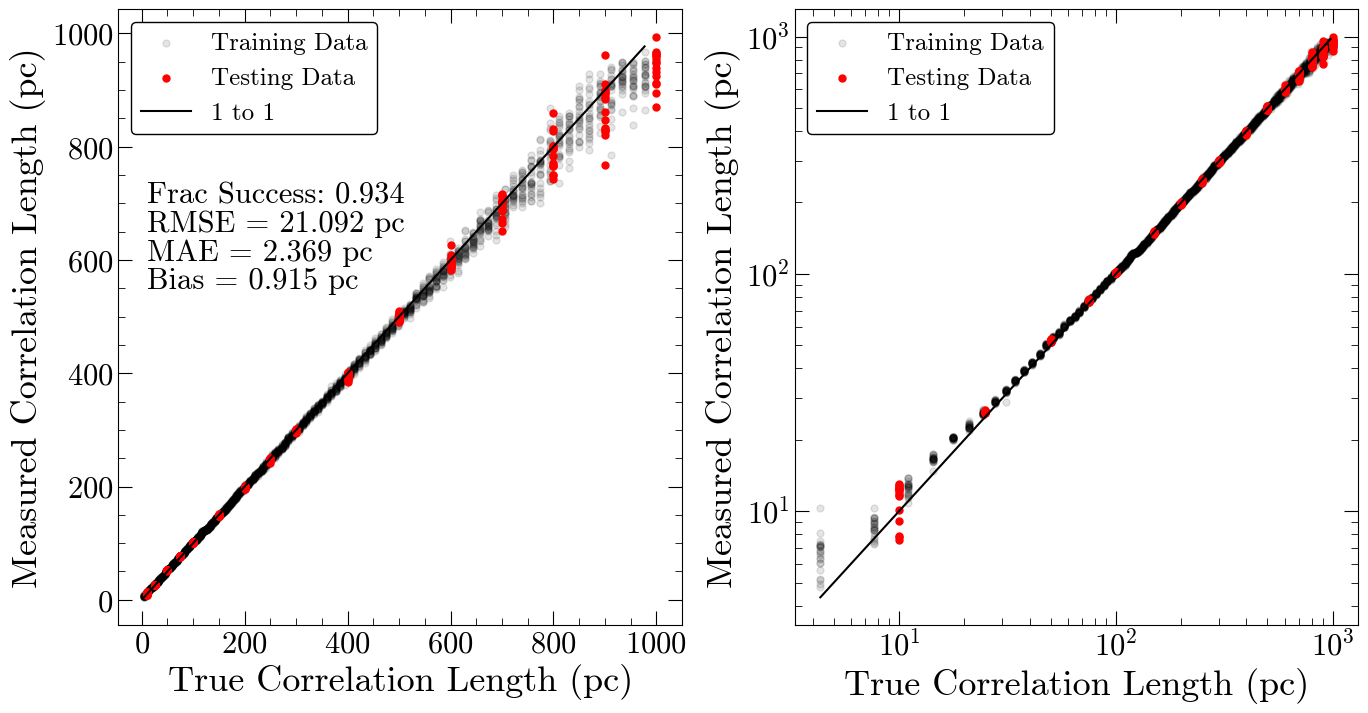

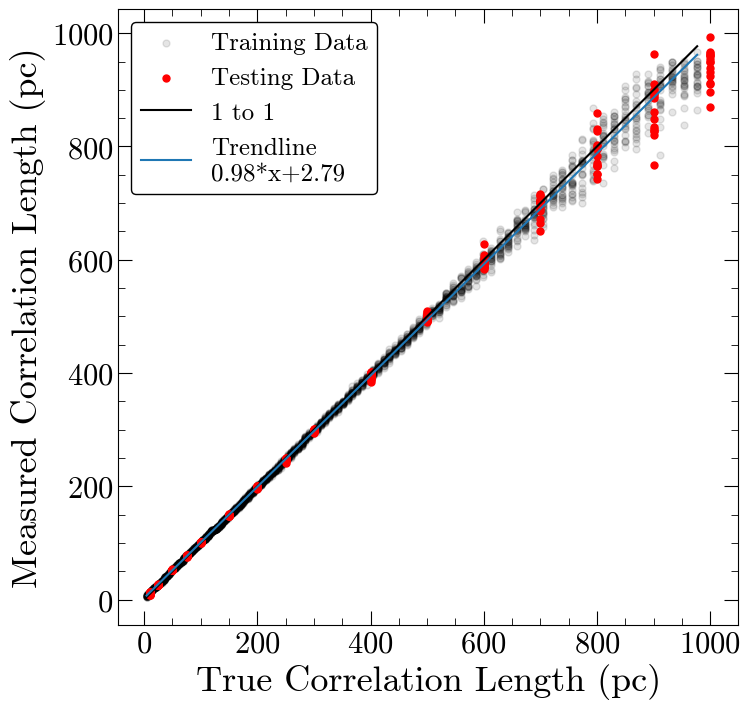

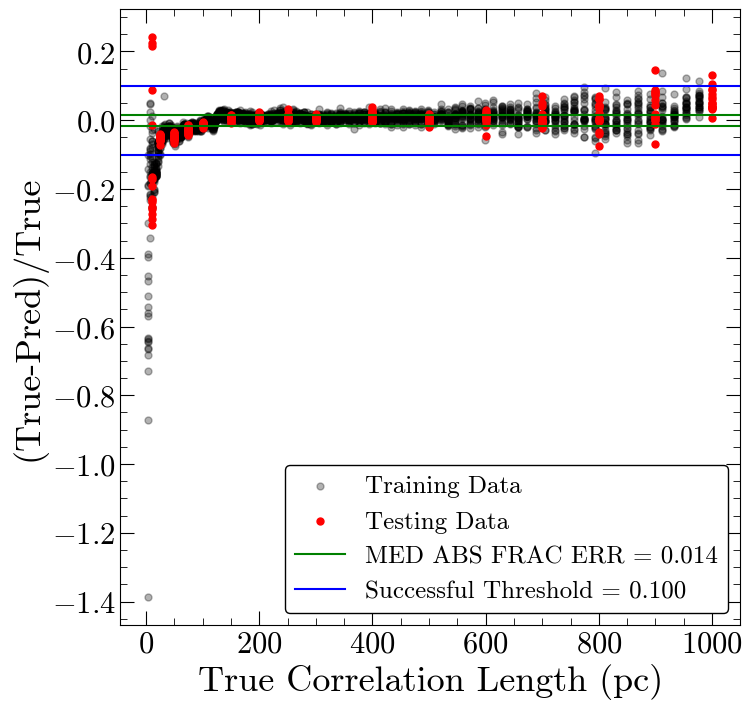

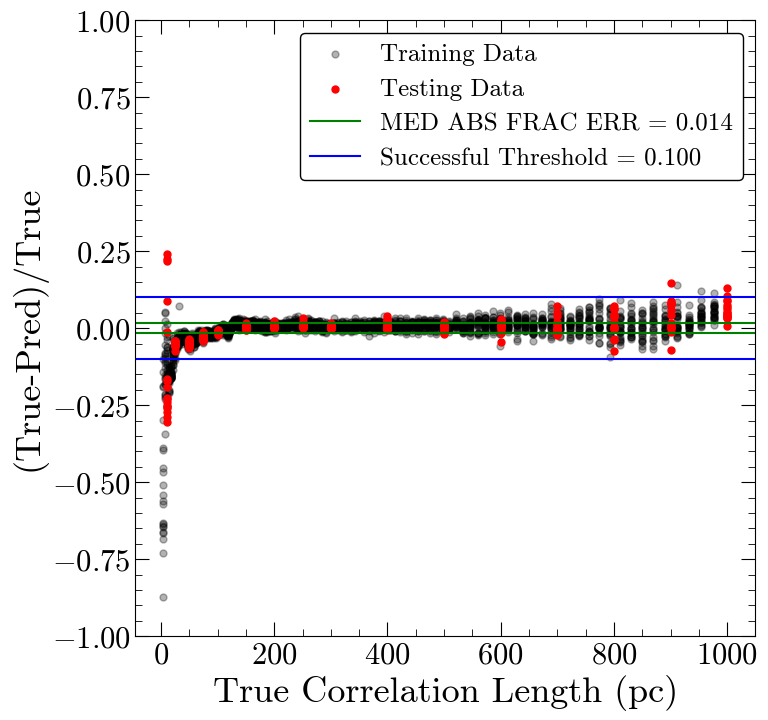

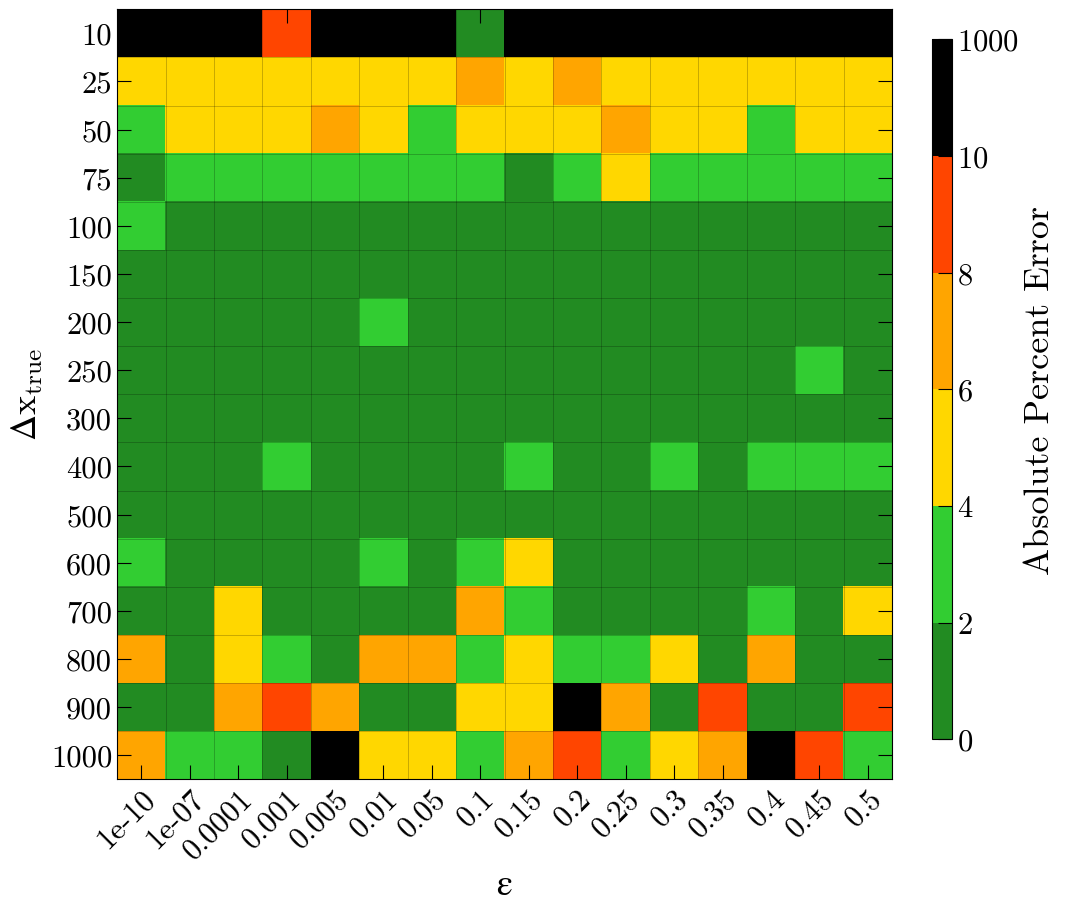

Number of squares with abs percent err>10%,  17


In [70]:
#model with even more layers, run for even more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
46/46 [==============================] - 0s 3ms/step - loss: 122484.3984
Epoch 2/400
46/46 [==============================] - 0s 3ms/step - loss: 21650.8926
Epoch 3/400
46/46 [==============================] - 0s 4ms/step - loss: 2166.3206
Epoch 4/400
46/46 [==============================] - 0s 4ms/step - loss: 1199.6250
Epoch 5/400
46/46 [==============================] - 0s 4ms/step - loss: 793.7021
Epoch 6/400
46/46 [==============================] - 0s 4ms/step - loss: 635.5363
Epoch 7/400
46/46 [==============================] - 0s 4ms/step - loss: 476.0627
Epoch 8/400
46/46 [==============================] - 0s 4ms/step - loss: 451.8262
Epoch 9/400
46/46 [==============================] - 0s 4ms/step - loss: 332.3740
Epoch 10/400
46/46 [==============================] - 0s 4ms/step - loss: 291.7057
Epoch 11/400
46/46 [==============================] - 0s 4ms/step - loss: 257.4357
Epoch 12/400
46/46 [==============================] - 0s 4ms/step - loss: 272.7884
Epoch 

46/46 [==============================] - 0s 4ms/step - loss: 229.1804
Epoch 197/400
46/46 [==============================] - 0s 4ms/step - loss: 180.8781
Epoch 198/400
46/46 [==============================] - 0s 4ms/step - loss: 196.5139
Epoch 199/400
46/46 [==============================] - 0s 4ms/step - loss: 200.5966
Epoch 200/400
46/46 [==============================] - 0s 4ms/step - loss: 178.0281
Epoch 201/400
46/46 [==============================] - 0s 4ms/step - loss: 201.2541
Epoch 202/400
46/46 [==============================] - 0s 4ms/step - loss: 213.8780
Epoch 203/400
46/46 [==============================] - 0s 4ms/step - loss: 180.3517
Epoch 204/400
46/46 [==============================] - 0s 4ms/step - loss: 222.7547
Epoch 205/400
46/46 [==============================] - 0s 4ms/step - loss: 194.5418
Epoch 206/400
46/46 [==============================] - 0s 4ms/step - loss: 283.4377
Epoch 207/400
46/46 [==============================] - 0s 4ms/step - loss: 196.4345
Epoch 

46/46 [==============================] - 0s 4ms/step - loss: 182.1974
Epoch 391/400
46/46 [==============================] - 0s 4ms/step - loss: 155.5941
Epoch 392/400
46/46 [==============================] - 0s 4ms/step - loss: 169.3359
Epoch 393/400
46/46 [==============================] - 0s 4ms/step - loss: 170.3893
Epoch 394/400
46/46 [==============================] - 0s 4ms/step - loss: 173.0133
Epoch 395/400
46/46 [==============================] - 0s 4ms/step - loss: 194.4623
Epoch 396/400
46/46 [==============================] - 0s 4ms/step - loss: 199.9045
Epoch 397/400
46/46 [==============================] - 0s 4ms/step - loss: 203.8969
Epoch 398/400
46/46 [==============================] - 0s 4ms/step - loss: 156.6349
Epoch 399/400
46/46 [==============================] - 0s 4ms/step - loss: 185.8608
Epoch 400/400
46/46 [==============================] - 0s 4ms/step - loss: 160.3139

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 12.010 pc
MAE: 2.527 pc
BIAS: -1.618 pc
MED FRAC ERR: 0.013 

Training Stats, Successful Fits
Frac Success Fit: 0.969 
RMSE: 11.368 pc
MAE: 2.552 pc
BIAS: -1.669 pc
MED FRAC ERR: 0.013 

Testing Stats
RMSE: 20.108 pc
MAE: 3.465 pc
BIAS: -0.821 pc
MED FRAC ERR: 0.017 

Testing Stats, Successful Fits
Frac Success Fit: 0.945 
RMSE: 17.803 pc
MAE: 3.530 pc
BIAS: -0.921 pc
MED FRAC ERR: 0.016 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      2.527141               0.969189     3.464839              0.945312

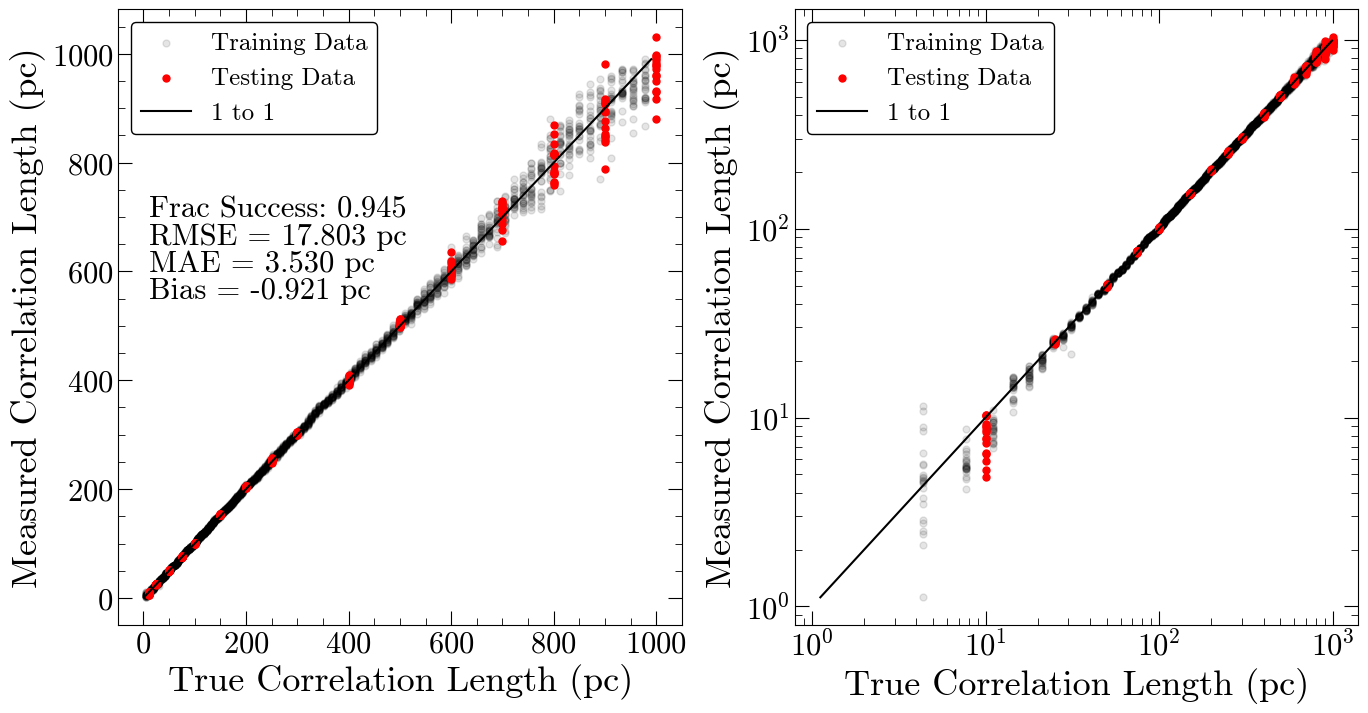

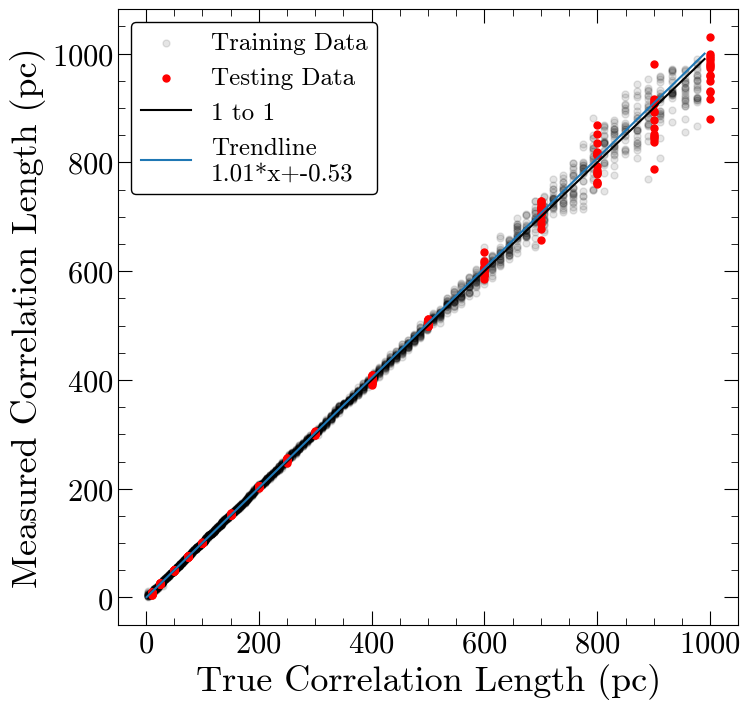

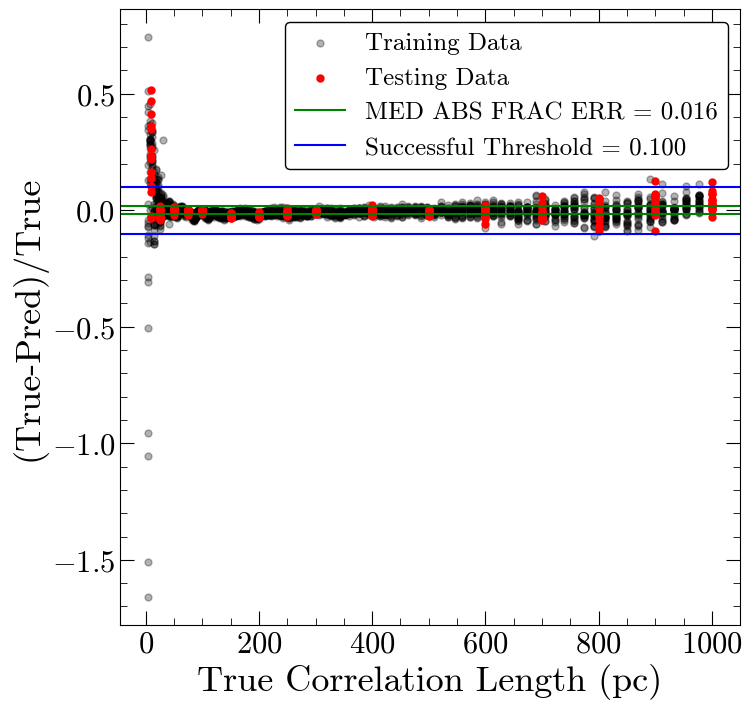

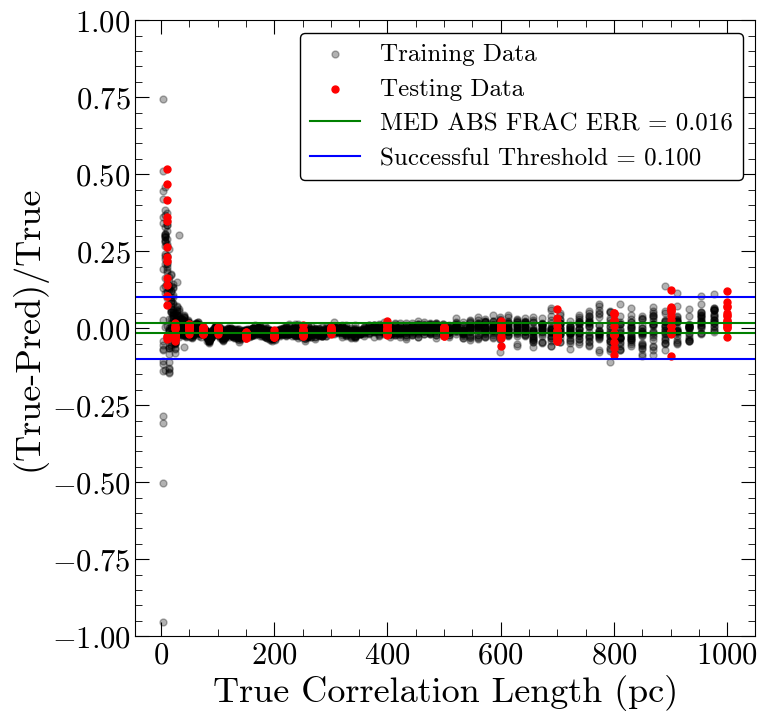

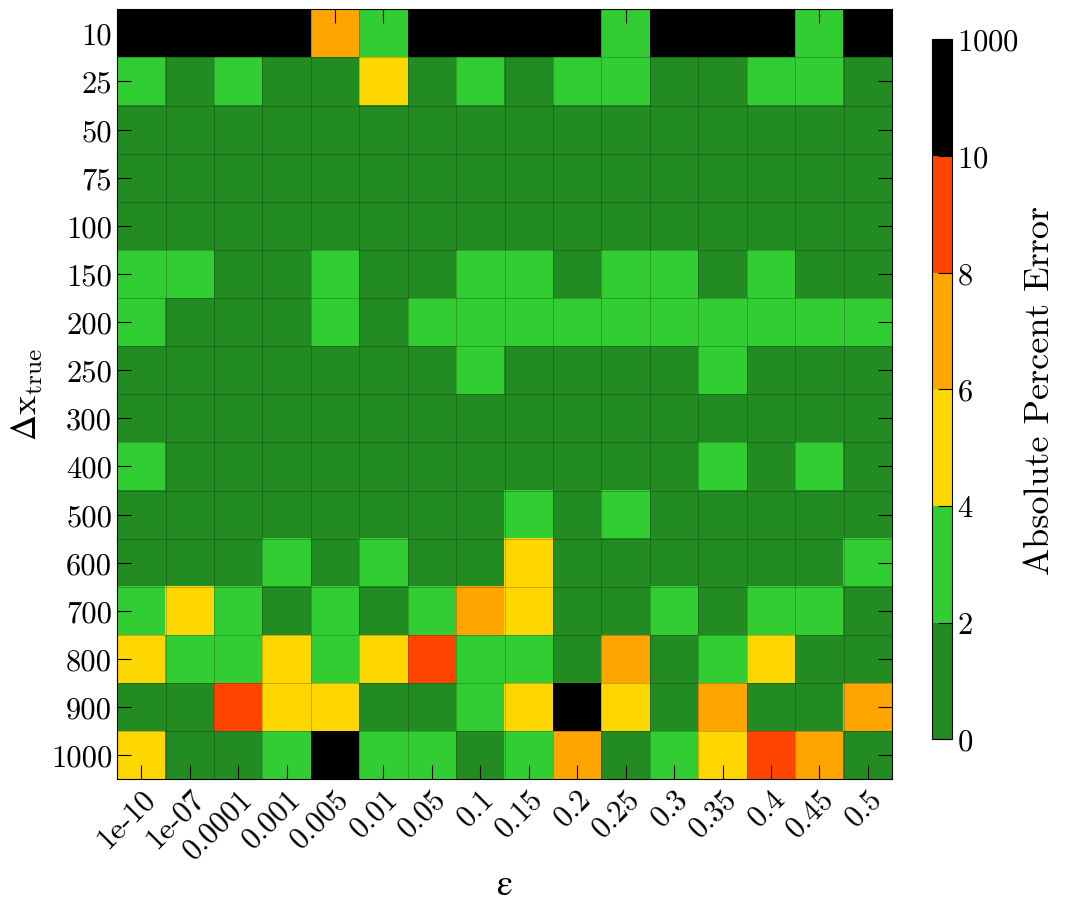

Number of squares with abs percent err>10%,  14


In [71]:
#model with even more layers, run for even more epochs, increase batch size
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=64)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
10/10 [==============================] - 0s 8ms/step - loss: 163827.6562
Epoch 2/400
10/10 [==============================] - 0s 8ms/step - loss: 155229.2031
Epoch 3/400
10/10 [==============================] - 0s 8ms/step - loss: 98176.7266
Epoch 4/400
10/10 [==============================] - 0s 7ms/step - loss: 48423.8711
Epoch 5/400
10/10 [==============================] - 0s 8ms/step - loss: 32892.3125
Epoch 6/400
10/10 [==============================] - 0s 7ms/step - loss: 18371.4961
Epoch 7/400
10/10 [==============================] - 0s 8ms/step - loss: 8043.9951
Epoch 8/400
10/10 [==============================] - 0s 7ms/step - loss: 2741.6572
Epoch 9/400
10/10 [==============================] - 0s 7ms/step - loss: 2191.0623
Epoch 10/400
10/10 [==============================] - 0s 7ms/step - loss: 1855.6379
Epoch 11/400
10/10 [==============================] - 0s 8ms/step - loss: 1428.0446
Epoch 12/400
10/10 [==============================] - 0s 8ms/step - loss: 117

10/10 [==============================] - 0s 8ms/step - loss: 186.7560
Epoch 197/400
10/10 [==============================] - 0s 8ms/step - loss: 181.8842
Epoch 198/400
10/10 [==============================] - 0s 8ms/step - loss: 185.3795
Epoch 199/400
10/10 [==============================] - 0s 9ms/step - loss: 185.0152
Epoch 200/400
10/10 [==============================] - 0s 10ms/step - loss: 181.3387
Epoch 201/400
10/10 [==============================] - 0s 8ms/step - loss: 199.0496
Epoch 202/400
10/10 [==============================] - 0s 8ms/step - loss: 193.3806
Epoch 203/400
10/10 [==============================] - 0s 8ms/step - loss: 202.7101
Epoch 204/400
10/10 [==============================] - 0s 8ms/step - loss: 190.0951
Epoch 205/400
10/10 [==============================] - 0s 9ms/step - loss: 201.0998
Epoch 206/400
10/10 [==============================] - 0s 10ms/step - loss: 188.4942
Epoch 207/400
10/10 [==============================] - 0s 9ms/step - loss: 215.6909
Epoc

10/10 [==============================] - 0s 8ms/step - loss: 171.7141
Epoch 391/400
10/10 [==============================] - 0s 8ms/step - loss: 177.7110
Epoch 392/400
10/10 [==============================] - 0s 8ms/step - loss: 187.0993
Epoch 393/400
10/10 [==============================] - 0s 8ms/step - loss: 186.8999
Epoch 394/400
10/10 [==============================] - 0s 8ms/step - loss: 209.1353
Epoch 395/400
10/10 [==============================] - 0s 8ms/step - loss: 180.1312
Epoch 396/400
10/10 [==============================] - 0s 8ms/step - loss: 192.2984
Epoch 397/400
10/10 [==============================] - 0s 8ms/step - loss: 258.7711
Epoch 398/400
10/10 [==============================] - 0s 8ms/step - loss: 189.9145
Epoch 399/400
10/10 [==============================] - 0s 8ms/step - loss: 179.0244
Epoch 400/400
10/10 [==============================] - 0s 8ms/step - loss: 175.5680

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 13.181 pc
MAE: 4.316 pc
BIAS: -3.731 pc
MED FRAC ERR: 0.026 

Training Stats, Successful Fits
Frac Success Fit: 0.966 
RMSE: 12.989 pc
MAE: 4.402 pc
BIAS: -3.802 pc
MED FRAC ERR: 0.025 

Testing Stats
RMSE: 19.952 pc
MAE: 4.774 pc
BIAS: -3.222 pc
MED FRAC ERR: 0.029 

Testing Stats, Successful Fits
Frac Success Fit: 0.949 
RMSE: 19.143 pc
MAE: 4.917 pc
BIAS: -3.474 pc
MED FRAC ERR: 0.028 


mae_training  frac_success_training  mae_testing  frac_success_testing
0      4.316165               0.966107     4.774414              0.949219

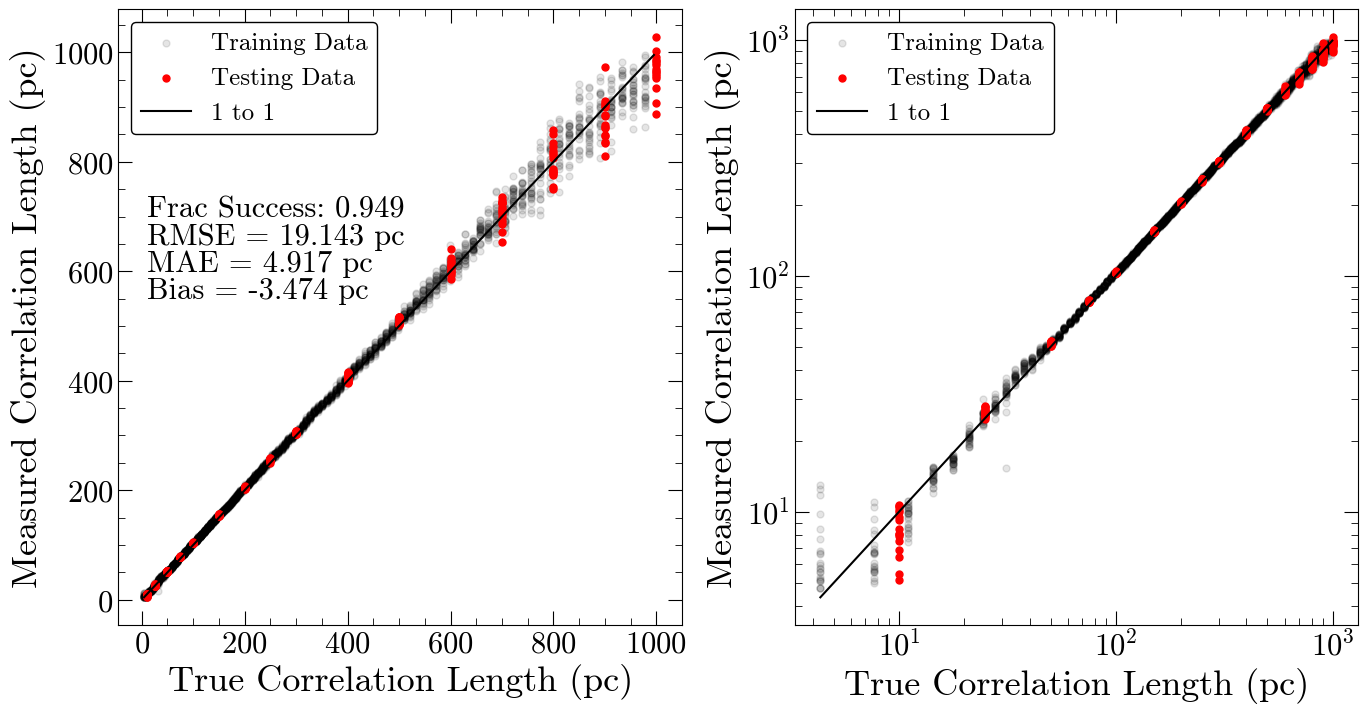

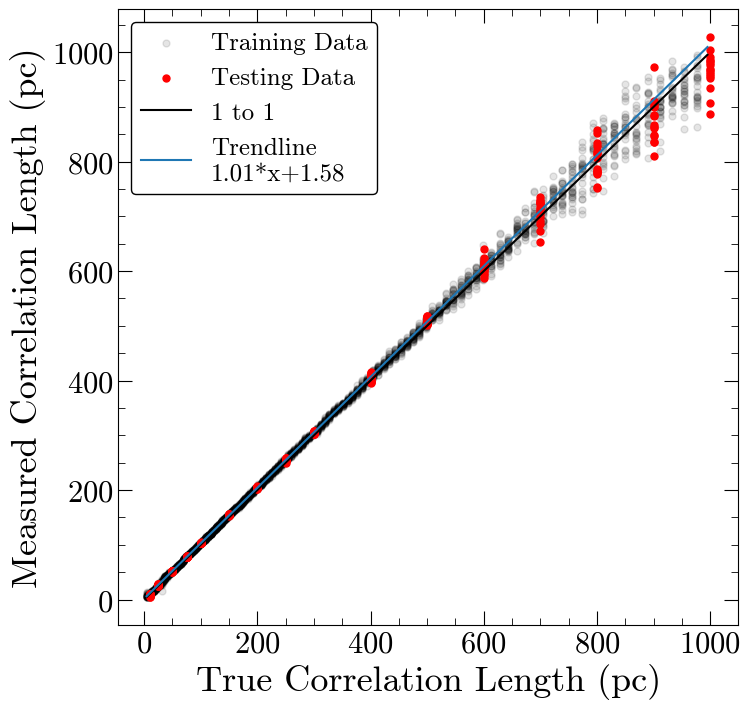

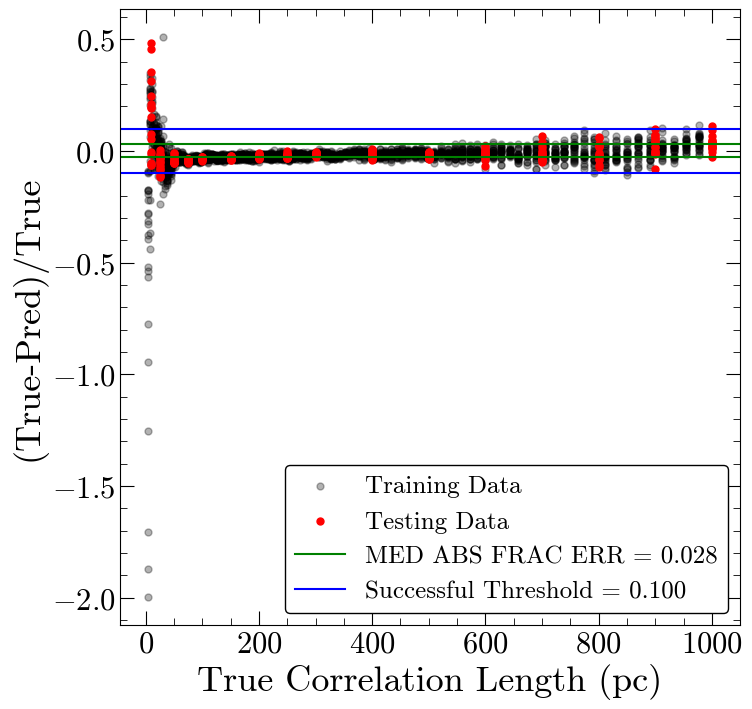

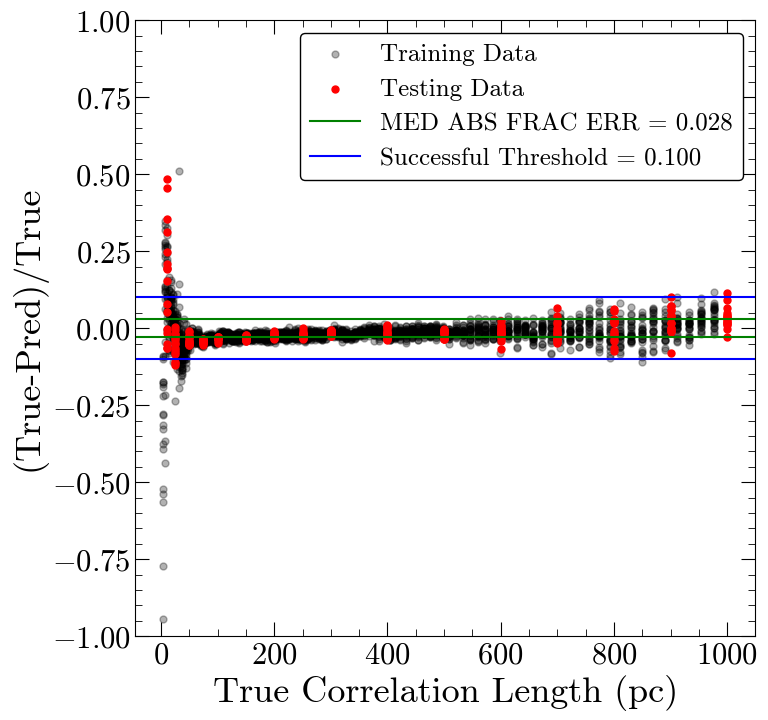

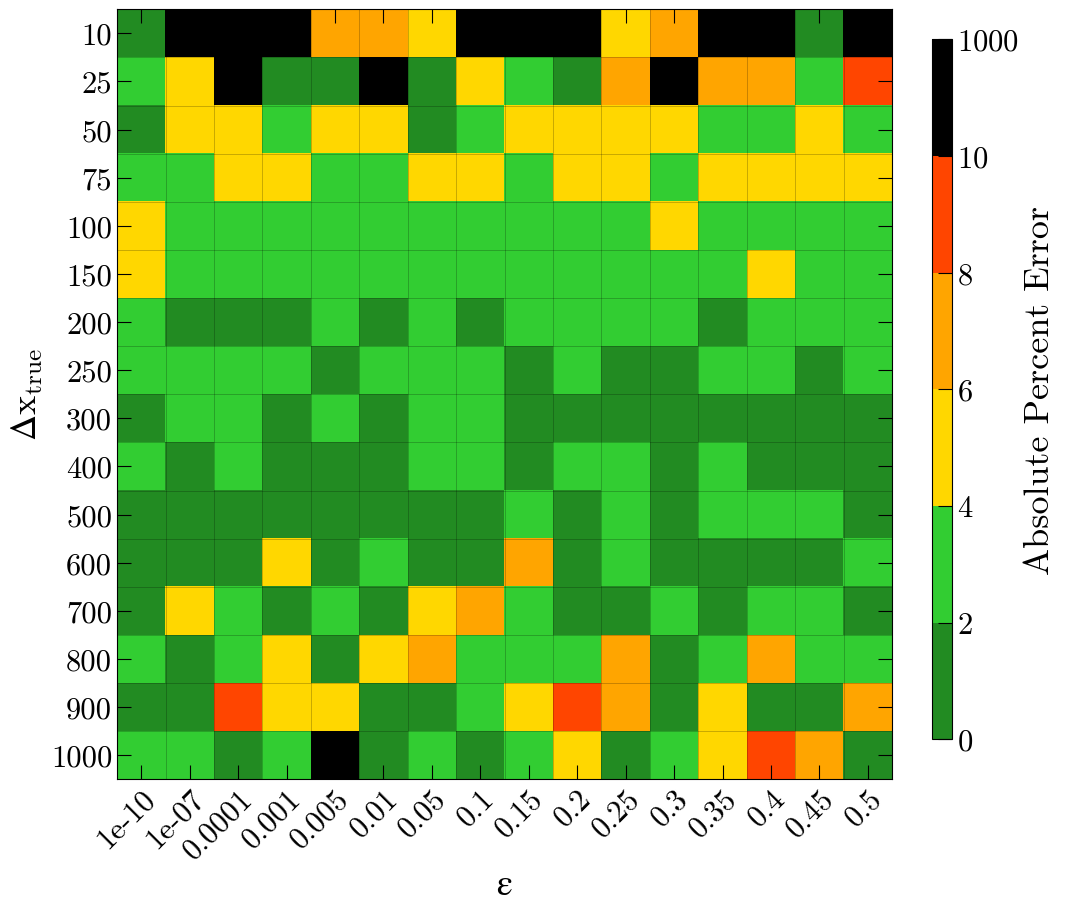

Number of squares with abs percent err>10%,  13


In [72]:
#model with even more layers, run for even more epochs, increase batch size even more
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=300)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

# Save best model

In [73]:
#reset the indices
indices=np.arange(0,len(all_model_stats))
all_model_stats.set_index(indices,inplace=True)
#round all values
all_model_stats=all_model_stats.round(2)

print('Min MAE Training')
print(all_model_stats['mae_training'].idxmin(),', min val=',min(all_model_stats['mae_training']))
print('')

print('Max Frac Success Training')
print(all_model_stats['frac_success_training'].idxmax(),', max val=',max(all_model_stats['frac_success_training']))
print('')

print('Min MAE Testing')
print(all_model_stats['mae_testing'].idxmin(),', min val=',min(all_model_stats['mae_testing']))
print('')

print('Max Frac Success Testing')
print(all_model_stats['frac_success_testing'].idxmax(),', max val=',max(all_model_stats['frac_success_testing']))
print('')

display(all_model_stats)

#best model option is 6


Min MAE Training
6 , min val= 1.57

Max Frac Success Training
4 , max val= 0.98

Min MAE Testing
6 , min val= 1.91

Max Frac Success Testing
4 , max val= 0.97



mae_training  frac_success_training  mae_testing  frac_success_testing
0           2.57                   0.97         2.91                  0.94
1           4.41                   0.91         4.63                  0.88
2           5.75                   0.96         6.44                  0.92
3           4.81                   0.95         4.67                  0.92
4           2.82                   0.98         3.77                  0.97
5           3.65                   0.97         4.60                  0.93
6           1.57                   0.98         1.91                  0.96
7           2.13                   0.97         2.82                  0.96
8           2.23                   0.96         2.40                  0.93
9           2.53                   0.97         3.46                  0.95
10          4.32                   0.97         4.77                  0.95

In [88]:
#choose model 8 which is the best option across all runs

failed_fit_region_count=500

while failed_fit_region_count>16:
    #model with even more layers, run for even more epochs
    final_model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
        MaxPooling1D(2), 
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2), 
        Conv1D(128, 3, activation='relu'), 
        MaxPooling1D(2), 
        Flatten(), 
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1) 
    ])

    final_model.compile(optimizer='adam', loss='mse')

    final_model.fit(x_train, y_train, epochs=400, batch_size=32)

    failed_fit_region_count,mae_testing_success,training_data,testing_data,nan_corr_lengths=test_model(final_model,stats=False,plot=False)
    
    print('')
    print(failed_fit_region_count)
    print('')

Epoch 1/400
92/92 [==============================] - 2s 16ms/step - loss: 73082.3438
Epoch 2/400
92/92 [==============================] - 2s 19ms/step - loss: 1547.5229
Epoch 3/400
92/92 [==============================] - 2s 17ms/step - loss: 666.2311
Epoch 4/400
92/92 [==============================] - 2s 20ms/step - loss: 433.4618
Epoch 5/400
92/92 [==============================] - 1s 16ms/step - loss: 335.9989
Epoch 6/400
92/92 [==============================] - 2s 18ms/step - loss: 301.4442
Epoch 7/400
92/92 [==============================] - 2s 19ms/step - loss: 315.8632
Epoch 8/400
92/92 [==============================] - 2s 20ms/step - loss: 285.8042
Epoch 9/400
92/92 [==============================] - 2s 18ms/step - loss: 302.5441
Epoch 10/400
92/92 [==============================] - 2s 18ms/step - loss: 266.4669
Epoch 11/400
92/92 [==============================] - 2s 18ms/step - loss: 266.2646
Epoch 12/400
92/92 [==============================] - 2s 17ms/step - loss: 251.734

92/92 [==============================] - 1s 14ms/step - loss: 223.6418
Epoch 195/400
92/92 [==============================] - 1s 13ms/step - loss: 215.6467
Epoch 196/400
92/92 [==============================] - 1s 11ms/step - loss: 213.0165
Epoch 197/400
92/92 [==============================] - 1s 14ms/step - loss: 231.7428
Epoch 198/400
92/92 [==============================] - 1s 13ms/step - loss: 207.2568
Epoch 199/400
92/92 [==============================] - 1s 13ms/step - loss: 199.3561
Epoch 200/400
92/92 [==============================] - 1s 13ms/step - loss: 215.6780
Epoch 201/400
92/92 [==============================] - 1s 13ms/step - loss: 204.4909
Epoch 202/400
92/92 [==============================] - 1s 14ms/step - loss: 217.0177
Epoch 203/400
92/92 [==============================] - 1s 13ms/step - loss: 215.4136
Epoch 204/400
92/92 [==============================] - 1s 13ms/step - loss: 277.1339
Epoch 205/400
92/92 [==============================] - 1s 12ms/step - loss: 177

92/92 [==============================] - 1s 9ms/step - loss: 176.4662
Epoch 387/400
92/92 [==============================] - 1s 9ms/step - loss: 164.8454
Epoch 388/400
92/92 [==============================] - 1s 10ms/step - loss: 193.6550
Epoch 389/400
92/92 [==============================] - 1s 9ms/step - loss: 186.1547
Epoch 390/400
92/92 [==============================] - 1s 10ms/step - loss: 345.4152
Epoch 391/400
92/92 [==============================] - 1s 9ms/step - loss: 168.5691
Epoch 392/400
92/92 [==============================] - 1s 9ms/step - loss: 180.2263
Epoch 393/400
92/92 [==============================] - 1s 9ms/step - loss: 181.9084
Epoch 394/400
92/92 [==============================] - 1s 9ms/step - loss: 190.9052
Epoch 395/400
92/92 [==============================] - 1s 9ms/step - loss: 178.5169
Epoch 396/400
92/92 [==============================] - 1s 9ms/step - loss: 177.6317
Epoch 397/400
92/92 [==============================] - 1s 9ms/step - loss: 179.5758
Epoc

In [89]:
#save the model
nb='01'
final_model.save('csv/nb05_sample_size_10207/'+nb+'_final_model')

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/01_final_model/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/01_final_model/assets


In [90]:
def final_plot(nb,title,statx=10,staty=700,statdy=50,lim='default', siegel=True,success_fit_threshold=0.1):
    
    loaded_model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
    failed_fit_region_count,mae_testing_success,training_data,testing_data,nan_corr_lengths=test_model(loaded_model,stats=False,plot=False)
    
    # use the model to predict the training data
    y_pred_train = loaded_model.predict(x_train, verbose=0)
    training_data['y_pred']=y_pred_train
    
    # use the model to predict the training data
    y_pred_test = loaded_model.predict(x_test, verbose=0)
    testing_data['y_pred']=y_pred_test
    
    #drop the failed fits
    testing_data=testing_data.dropna()
    #reset the indices
    indices=np.arange(0,len(testing_data))
    testing_data.set_index(indices,inplace=True)
    
    y_true_training=training_data['y_true']
    y_pred_training=training_data['y_pred']
    y_true_testing=testing_data['y_true']
    y_pred_testing=testing_data['y_pred']
    
    unit='pc'
    
    #calculate stats
    rmse_training,mae_training,bias_training,med_frac_training,error_training,frac_err_training,frac_success=comparison_stats(training_data,False)
    rmse_training_success,mae_training_success,bias_training_success,med_frac_training_success,error_training_success,frac_err_training_success,frac_success_training=comparison_stats(training_data,False,True,success_fit_threshold)
    rmse_testing,mae_testing,bias_testing,med_frac_testing,error_testing,frac_err_testing,frac_success=comparison_stats(testing_data,False)
    rmse_testing_success,mae_testing_success,bias_testing_success,med_frac_testing_success,error_testing_success,frac_err_testing_success,frac_success_testing=comparison_stats(testing_data,False,True,success_fit_threshold)
    
    #plot the agreement with stats
    fig, ((ax1),(ax2)) =plt.subplots(2,1,figsize=(8,16),sharex=True)
    ax1.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax1.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax1.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax1.text(statx, staty, 'Frac Success: {:2.3f} '.format(frac_success_testing))
    ax1.text(statx, staty-1*statdy, 'RMSE = {:.3f} '.format(rmse_testing_success)+unit)
    ax1.text(statx, staty-2*statdy, 'MAE = {:.3f} '.format(mae_testing_success)+unit)
    ax1.text(statx, staty-3*statdy, 'Bias = {:.3f} '.format(bias_testing_success)+unit)
    ax1.set_ylabel(r'Predicted Correlation Length (pc)')
    maxval=max(max(y_true_training),max(y_pred_training))
    minval=min(min(y_true_training),min(y_pred_training))
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
    
    # plot the fractional error between the datasets zoomed in
    ax2.scatter(y_true_training, frac_err_training,c='k',alpha=0.3,label='Training Data')
    ax2.scatter(y_true_testing, frac_err_testing,c='r',label='Testing Data')
    ax2.axhline(0,color='black')
    ax2.axhline(med_frac_testing,color='green',label='Median Absolute\nFractional Error = {:.3f}'.format(med_frac_testing_success))
    ax2.axhline(-med_frac_testing,color='green')
    ax2.axhline(success_fit_threshold,color='blue',label='Successful Threshold = {:.1f}'.format(success_fit_threshold))
    ax2.axhline(-success_fit_threshold,color='blue')
    ax2.set_xlabel(r'True Correlation Length (pc)')
    ax2.set_ylabel(r'($\lambda_{True}-\lambda_{Pred})/\lambda_{True}$')
    ax2.set_ylim((-1,1))
    ax2.legend()
    
    ax1.set_title(title)
    
    plt.subplots_adjust(wspace = 0,hspace=0)
    plt.show()
    
    #make and save the heatmap, which is the figure that will be included in the paper
    failed_fit_region_count=heatmap_testing_data(testing_data,title,savefig=True,figname=nb+'_cnn_heatmap')
    

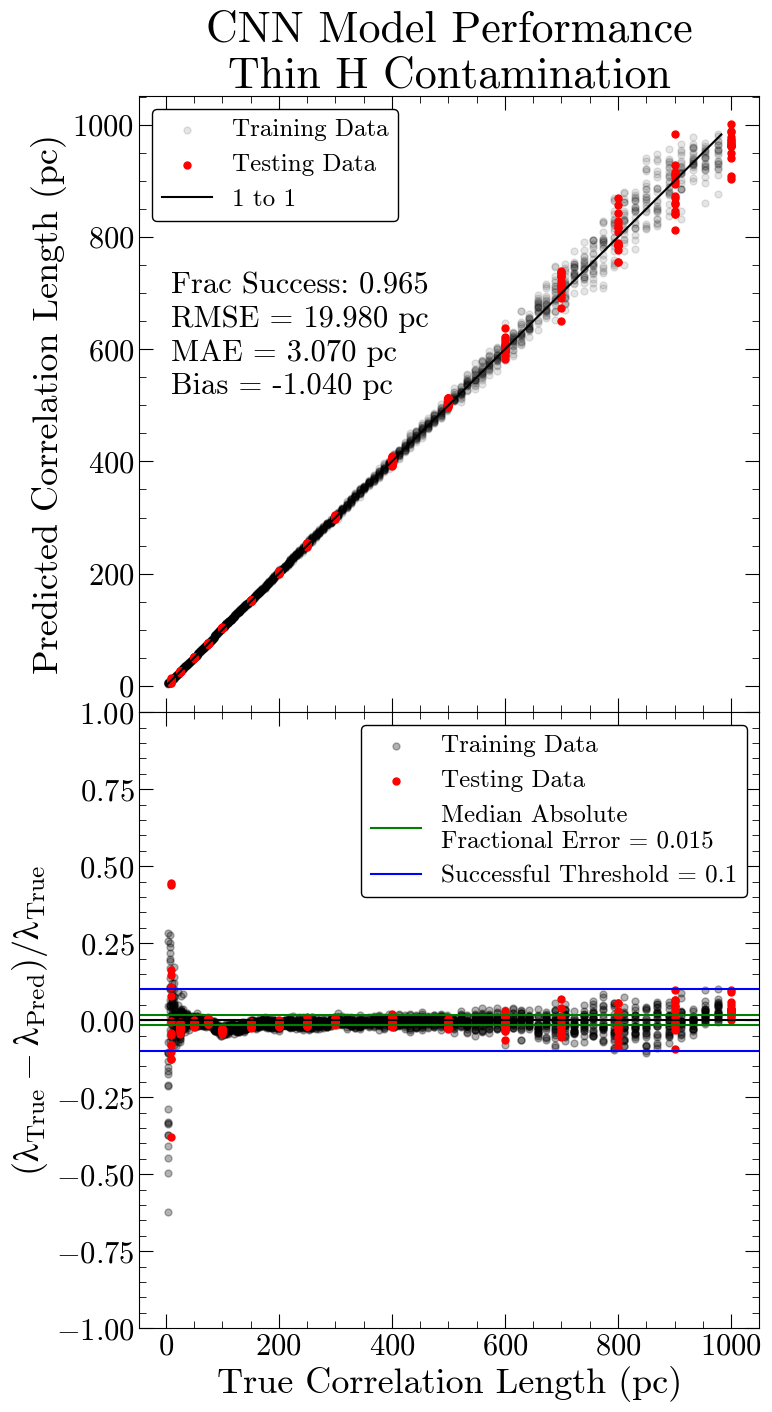

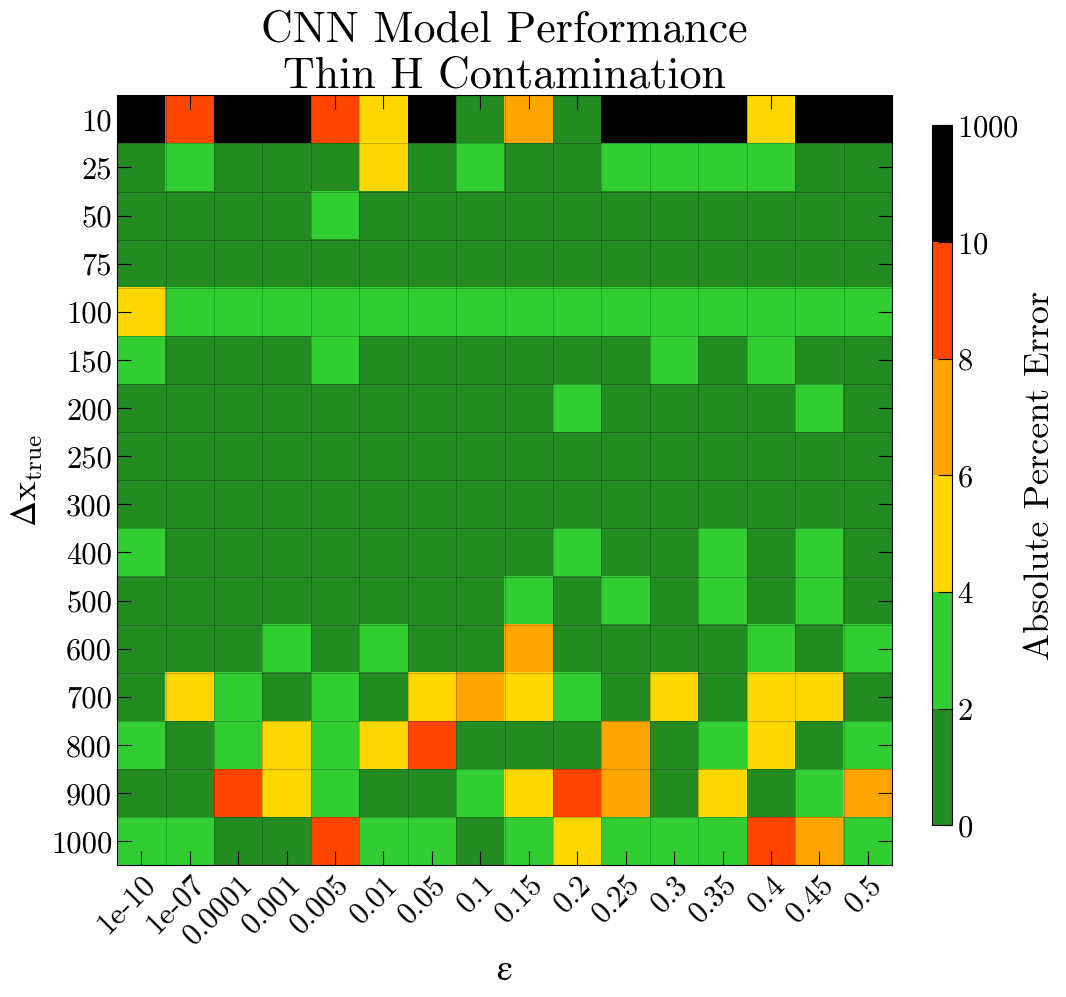

Number of squares with abs percent err>10%,  9


In [91]:
final_plot('01','CNN Model Performance\nThin H Contamination',statdy=60)